In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import bloscpack as bp
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from preprocess_utilities import *
from registration_utilities import *

Setting environment for Precision WorkStation


No vtk


In [2]:
stack_moving = 'atlasV5'
detector_id = 15

In [3]:
# from sklearn.decomposition.pca import PCA

In [4]:
def find_best_jaccard(hm, hf):
    
    aligner = Aligner4({1: hf}, {1: hm}, labelIndexMap_m2f={1:1})

    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[1])

    gradients = compute_gradient({1: hf}, smooth_first=True)

    aligner.load_gradient(gradients=compute_gradient({1: hf}, smooth_first=True))

    T, scores = aligner.optimize(tf_type='rigid', lr1=1, lr2=0.1)

    # Ts = np.array(aligner.Ts)

    # plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
    # plt.title('rotational params');
    # plt.xlabel('Iteration');
    # plt.show();

    # plt.plot(Ts[:, [3,7,11]]);
    # plt.title('translation params');
    # plt.xlabel('Iteration');
    # plt.show();

    # print T.reshape((3,4))
    # plt.figure();
    # plt.plot(scores);
    # plt.show();

    # print T.reshape((3,4))

    transform_parameters = {'centroid_m': aligner.centroid_m,
                           'centroid_f': aligner.centroid_f,
                           'domain_f_origin_wrt_wholebrain': np.zeros((3,)),
                           'domain_m_origin_wrt_wholebrain': np.zeros((3,)),
                           'parameters': T}

    hm_aligned, hm_aligned_origin_wrt_hf = transform_volume_by_alignment_parameters(hm.astype(np.int), 
                                                                                    origin=np.array((0,0,0)), 
                                                                                    transform_parameters=transform_parameters)

    hm_aligned = crop_and_pad_volume(hm_aligned, in_origin=hm_aligned_origin_wrt_hf, out_bbox=hf)
    
    return jaccard_masks(hm_aligned, hf, wrt_min=False)

In [5]:
atlas_spec = dict(name='atlasV5', resolution='10.0um', vol_type='score')

In [6]:
warp_setting = 20

In [7]:
metrics_allStacks_allStructures_allLevels = defaultdict(lambda: defaultdict(dict))
# metrics_allStacks_allStructures = defaultdict(lambda: defaultdict(dict))

# for stack_fixed in ['MD589']:
for stack_fixed in ['MD585','MD589','MD594']:
        
    for structure in all_known_structures_sided:
#     for structure in ['7N_L']:
        
        try:

            annotated_brain_spec = dict(name=stack_fixed, 
                                        vol_type='annotationAsScore', 
                                        resolution='10.0um')

            ann_vol_10um, ann_vol_origin_wrt_wholebrain_10um = \
            DataManager.load_original_volume_v2(stack_spec=annotated_brain_spec, 
                                                structure=structure, 
                                                bbox_wrt='wholebrain',
                                                return_origin_instead_of_bbox=True)

            ####################

            score_brain_spec = dict(name=stack_fixed,
                               vol_type='score',
                               detector_id=15,
                               prep_id=2,
                               resolution='10.0um')

            alignedAtlas_vol_m2f_10um, alignedAtlas_vol_m2f_origin_wrt_wholebrain_10um = \
            DataManager.load_transformed_volume_v2(alignment_spec=dict(stack_m=atlas_spec, 
                                                                       stack_f=score_brain_spec, 
                                                                       warp_setting=warp_setting),
                                                   structure=structure,
                                                   resolution='10.0um',
                                                                 return_origin_instead_of_bbox=True,
                                                                 legacy=True)

            ######################

            hf = ann_vol_10um > 0

    #             xyzs = np.array(np.where(hf))[[1,0,2]]
    #             pca = PCA(n_components=3)
    #             xyzs_transformed = pca.fit_transform(xyzs.T)
    #             principle_axes = pca.components_
    #             annotation_centroid = pca.mean_
    #             principal_axes_lengths_down32 = xyzs_transformed.max(axis=0) - xyzs_transformed[:, 0].min(axis=0)
    #             principal_axes_lengths_um = principal_axes_lengths_down32 * convert_resolution_string_to_voxel_size(resolution='down32', stack=stack_fixed)
    #             print stack_fixed, structure
    #             print 'principal_axes_lengths_um =', principal_axes_lengths_um
    #             del xyzs, xyzs_transformed, pca

            hm = crop_and_pad_volume(alignedAtlas_vol_m2f_10um, 
                                     in_origin=alignedAtlas_vol_m2f_origin_wrt_wholebrain_10um - ann_vol_origin_wrt_wholebrain_10um.astype(np.int),
                                     out_bbox=(0, hf.shape[1]-1, 0, hf.shape[0]-1, 0, hf.shape[2]-1))

    #             display_volume_sections(hf, start_level=0, direction='z')
    #             display_volume_sections(hm, start_level=0, direction='z')

            annVol_centroid_wrt_wholebrain_10um = compute_centroid_3d(hf)

    #             corr = np.corrcoef(hm.flatten(), hf.flatten())[0,1]
            mask = (hm > 0) | (hf > 0)   
            corr = np.corrcoef(hm[mask].flatten(), hf[mask].flatten())[0,1]

    #             mean_diff = np.sqrt(np.mean(np.abs(hm[mask] - hf[mask])**2))
            mean_diff = np.mean(np.abs(hm[mask].astype(np.float) - hf[mask].astype(np.float)))

            print 'correlation =', corr
            print 'mean voxel value difference =', mean_diff

    #             metrics_allStacks_allStructures[stack_fixed][structure] = {'corr': corr, 'mean_diff': mean_diff}

            for level in np.arange(0.1, 1, 0.1):

                alignedAtlas_centroid_wrt_wholebrain_10um = compute_centroid_3d(hm > level)

                centroid_diff_vec_10um = annVol_centroid_wrt_wholebrain_10um - \
                alignedAtlas_centroid_wrt_wholebrain_10um
    #                 centroid_diff_percentage = np.dot(principle_axes, centroid_diff_vec_down32) / principal_axes_lengths_down32
                centroid_diff_norm_10um = np.linalg.norm(centroid_diff_vec_10um)
                centroid_diff_percentage = centroid_diff_norm_10um / get_structure_length_at_direction(hf, centroid_diff_vec_10um)

                centroid_diff_um = np.linalg.norm(centroid_diff_vec_10um) * 10.

                jac = jaccard_masks(hm > level, hf, wrt_min=False)
    #                 best_jac = find_best_jaccard(hm > level, hf)

                print stack_fixed, structure
                print 'level =', float(level)
                print 'jaccard =', jac
    #             'best =', best_jac
    #             print 'corr =', corr,
                print 'centroid_diff_um =', centroid_diff_um, 'um'
                print 'centroid_diff_percentage =', centroid_diff_percentage
                print 

                metrics_allStacks_allStructures_allLevels[stack_fixed][structure][float(level)] = \
        {'corr': corr, 
         'mean_diff': mean_diff, 
         'jac':jac, 
    #          'best_jac': best_jac,
         'centroid_diff_um': centroid_diff_um, 
         'centroid_diff_percentage':centroid_diff_percentage
        }
            
        except Exception as e:
            sys.stderr.write("Cannot evaluate structure %s: %s\n" % (structure, e))
            continue

loaded_cropbox_resolution down32


rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_5N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_5N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_5N_L.bp"
return code: 0


correlation = 0.2871271932620819
mean voxel value difference = 0.39969741935998415
MD585 5N_L
level = 0.1
jaccard = 0.541930998523
centroid_diff_um = 82.44697224015181 um
centroid_diff_percentage = 0.13217072749555472

MD585 5N_L
level = 0.2
jaccard = 0.500923480413
centroid_diff_um = 88.46818800211364 um
centroid_diff_percentage = 0.14048348199455654

MD585 5N_L
level = 0.3
jaccard = 0.467630378971
centroid_diff_um = 91.34646550463744 um
centroid_diff_percentage = 0.1448114880062573

MD585 5N_L
level = 0.4
jaccard = 0.435680510173
centroid_diff_um = 93.31008214106964 um
centroid_diff_percentage = 0.1479413968062017

MD585 5N_L
level = 0.5
jaccard = 0.40735451986
centroid_diff_um = 94.4867798588244 um
centroid_diff_percentage = 0.15044097730320546

MD585 5N_L
level = 0.6
jaccard = 0.372304341061
centroid_diff_um = 97.48278911319045 um
centroid_diff_percentage = 0.15543775818121133

MD585 5N_L
level = 0.7
jaccard = 0.340580863549
centroid_diff_um = 99.09823881063951 um
centroid_diff_per

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_5N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_5N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_5N_R.bp"
return code: 0


correlation = 0.6348330946827352
mean voxel value difference = 0.26963735888351154
MD585 5N_R
level = 0.1
jaccard = 0.666586002887
centroid_diff_um = 36.347014820309596 um
centroid_diff_percentage = 0.07376389438218349

MD585 5N_R
level = 0.2
jaccard = 0.678986243444
centroid_diff_um = 39.056398969071296 um
centroid_diff_percentage = 0.07328451121313724

MD585 5N_R
level = 0.3
jaccard = 0.671649749392
centroid_diff_um = 41.17640785652377 um
centroid_diff_percentage = 0.07361703482428361

MD585 5N_R
level = 0.4
jaccard = 0.651562057383
centroid_diff_um = 43.3993110901696 um
centroid_diff_percentage = 0.0763170844058515

MD585 5N_R
level = 0.5
jaccard = 0.623325980367
centroid_diff_um = 45.65412852879352 um
centroid_diff_percentage = 0.07942565941978655

MD585 5N_R
level = 0.6
jaccard = 0.583439818742
centroid_diff_um = 47.621400619211144 um
centroid_diff_percentage = 0.08240180038718405

MD585 5N_R
level = 0.7
jaccard = 0.533414404347
centroid_diff_um = 49.35431818294785 um
centroid_dif

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_6N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_6N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_6N_L.bp"
return code: 0


correlation = -0.5411692380387604
mean voxel value difference = 0.7150361928486274
MD585 6N_L
level = 0.1
jaccard = 0.148635409377
centroid_diff_um = 91.39119416760623 um
centroid_diff_percentage = 0.42656659850720713

MD585 6N_L
level = 0.2
jaccard = 0.104610733182
centroid_diff_um = 102.31811838362914 um
centroid_diff_percentage = 0.48099649408510464

MD585 6N_L
level = 0.3
jaccard = 0.0755850727388
centroid_diff_um = 109.26394941424023 um
centroid_diff_percentage = 0.5149396160504535

MD585 6N_L
level = 0.4
jaccard = 0.0581185355442
centroid_diff_um = 113.97190927354016 um
centroid_diff_percentage = 0.5397653739456661

MD585 6N_L
level = 0.5
jaccard = 0.0417447606066
centroid_diff_um = 117.83858866893695 um
centroid_diff_percentage = 0.5587341866250813

MD585 6N_L
level = 0.6
jaccard = 0.027856635912
centroid_diff_um = 120.44640043305164 um
centroid_diff_percentage = 0.5737331124626918

MD585 6N_L
level = 0.7
jaccard = 0.0193798449612
centroid_diff_um = 122.96782893938756 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_6N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_6N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_6N_R.bp"
return code: 0


correlation = 0.3305593151590942
mean voxel value difference = 0.47051377578167736
MD585 6N_R
level = 0.1
jaccard = 0.477473498233
centroid_diff_um = 40.756828568487634 um
centroid_diff_percentage = 0.14714019308529952

MD585 6N_R
level = 0.2
jaccard = 0.489422084623
centroid_diff_um = 46.69037291867768 um
centroid_diff_percentage = 0.1679821362310164

MD585 6N_R
level = 0.3
jaccard = 0.450407417814
centroid_diff_um = 52.10823436099921 um
centroid_diff_percentage = 0.1873390782420526

MD585 6N_R
level = 0.4
jaccard = 0.370085722731
centroid_diff_um = 55.87316199025814 um
centroid_diff_percentage = 0.20135985144523957

MD585 6N_R
level = 0.5
jaccard = 0.287947099489
centroid_diff_um = 59.5392721366209 um
centroid_diff_percentage = 0.21537468712877364

MD585 6N_R
level = 0.6
jaccard = 0.18772782503
centroid_diff_um = 62.48098087559664 um
centroid_diff_percentage = 0.22862029229536096

MD585 6N_R
level = 0.7
jaccard = 0.116875190723
centroid_diff_um = 65.14052611112675 um
centroid_diff_pe

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7N_L.bp"
return code: 0


correlation = 0.23753545098551235
mean voxel value difference = 0.4067852419677631
MD585 7N_L
level = 0.1
jaccard = 0.514969229916
centroid_diff_um = 117.49893956298634 um
centroid_diff_percentage = 0.14435758250189307

MD585 7N_L
level = 0.2
jaccard = 0.503134102879
centroid_diff_um = 123.651961531312 um
centroid_diff_percentage = 0.14931440999124948

MD585 7N_L
level = 0.3
jaccard = 0.489558662435
centroid_diff_um = 128.2782050822437 um
centroid_diff_percentage = 0.15321897449459584

MD585 7N_L
level = 0.4
jaccard = 0.477507349881
centroid_diff_um = 131.79799574823332 um
centroid_diff_percentage = 0.15636507996938442

MD585 7N_L
level = 0.5
jaccard = 0.463381561409
centroid_diff_um = 134.62261081717796 um
centroid_diff_percentage = 0.15916733952005194

MD585 7N_L
level = 0.6
jaccard = 0.446653535815
centroid_diff_um = 137.01638771918545 um
centroid_diff_percentage = 0.1618649767747676

MD585 7N_L
level = 0.7
jaccard = 0.428718069615
centroid_diff_um = 139.03305804789127 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7N_R.bp"
return code: 0


correlation = 0.6551329970609537
mean voxel value difference = 0.24949437720966636
MD585 7N_R
level = 0.1
jaccard = 0.699153412974
centroid_diff_um = 59.87092004008928 um
centroid_diff_percentage = 0.05958727913584749

MD585 7N_R
level = 0.2
jaccard = 0.718071621339
centroid_diff_um = 65.24922742740958 um
centroid_diff_percentage = 0.0650854233035681

MD585 7N_R
level = 0.3
jaccard = 0.717292005747
centroid_diff_um = 68.69340891926933 um
centroid_diff_percentage = 0.06868403430796932

MD585 7N_R
level = 0.4
jaccard = 0.702484484326
centroid_diff_um = 72.131619280537 um
centroid_diff_percentage = 0.07221667634096805

MD585 7N_R
level = 0.5
jaccard = 0.678913608314
centroid_diff_um = 74.67266504112956 um
centroid_diff_percentage = 0.07486575209240547

MD585 7N_R
level = 0.6
jaccard = 0.642773944059
centroid_diff_um = 76.38399829772274 um
centroid_diff_percentage = 0.0766832065092618

MD585 7N_R
level = 0.7
jaccard = 0.597949509426
centroid_diff_um = 77.79956609521147 um
centroid_diff_per

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7n_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7n_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7n_L.bp"
return code: 0


correlation = 0.08561773682749374
mean voxel value difference = 0.4082836621521484
MD585 7n_L
level = 0.1
jaccard = 0.285852946429
centroid_diff_um = 53.458319093353815 um
centroid_diff_percentage = 0.07692807802909127

MD585 7n_L
level = 0.2
jaccard = 0.268890777358
centroid_diff_um = 57.34262713675956 um
centroid_diff_percentage = 0.060274045976383

MD585 7n_L
level = 0.3
jaccard = 0.253843441131
centroid_diff_um = 63.19447023719479 um
centroid_diff_percentage = 0.054720120451045226

MD585 7n_L
level = 0.4
jaccard = 0.235081189415
centroid_diff_um = 68.1235240885952 um
centroid_diff_percentage = 0.05367170804521791

MD585 7n_L
level = 0.5
jaccard = 0.216131839443
centroid_diff_um = 73.67472231444725 um
centroid_diff_percentage = 0.053870462756437344

MD585 7n_L
level = 0.6
jaccard = 0.194237049517
centroid_diff_um = 78.91408259291192 um
centroid_diff_percentage = 0.05536477254216358

MD585 7n_L
level = 0.7
jaccard = 0.168821987933
centroid_diff_um = 84.99122804453806 um
centroid_diff

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7n_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7n_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_7n_R.bp"
return code: 0


correlation = 0.520652069975144
mean voxel value difference = 0.2807964688380916
MD585 7n_R
level = 0.1
jaccard = 0.447036154353
centroid_diff_um = 51.46725046351626 um
centroid_diff_percentage = 0.11590941517101637

MD585 7n_R
level = 0.2
jaccard = 0.469642048029
centroid_diff_um = 49.85627124454229 um
centroid_diff_percentage = 0.11359536820344704

MD585 7n_R
level = 0.3
jaccard = 0.4744979679
centroid_diff_um = 49.39401295622913 um
centroid_diff_percentage = 0.09313540873816718

MD585 7n_R
level = 0.4
jaccard = 0.467064521095
centroid_diff_um = 49.26280270318854 um
centroid_diff_percentage = 0.08019818436358601

MD585 7n_R
level = 0.5
jaccard = 0.448033796689
centroid_diff_um = 48.27216173527959 um
centroid_diff_percentage = 0.08042273431256444

MD585 7n_R
level = 0.6
jaccard = 0.416793134477
centroid_diff_um = 46.59560611993426 um
centroid_diff_percentage = 0.08554060705695868

MD585 7n_R
level = 0.7
jaccard = 0.37625038964
centroid_diff_um = 45.48816975435301 um
centroid_diff_perc

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Amb_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Amb_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Amb_L.bp"
return code: 0


correlation = -0.5466851667893714
mean voxel value difference = 0.6467944680110872
MD585 Amb_L
level = 0.1
jaccard = 0.097528830313
centroid_diff_um = 119.48420568295137 um
centroid_diff_percentage = 0.25659669253937123

MD585 Amb_L
level = 0.2
jaccard = 0.0542097083829
centroid_diff_um = 116.14908079529677 um
centroid_diff_percentage = 0.27955907705593036

MD585 Amb_L
level = 0.3
jaccard = 0.0291679459625
centroid_diff_um = 107.18059384305067 um
centroid_diff_percentage = 0.41063324621609865

MD585 Amb_L
level = 0.4
jaccard = 0.0141140147756
centroid_diff_um = 108.52560218445275 um
centroid_diff_percentage = 0.5127337511603973

MD585 Amb_L
level = 0.5
jaccard = 0.00667126754083
centroid_diff_um = 111.01284888658259 um
centroid_diff_percentage = 0.4755452782390204

MD585 Amb_L
level = 0.6
jaccard = 0.00179468772434
centroid_diff_um = 116.36590359136716 um
centroid_diff_percentage = 0.41141708348040823

MD585 Amb_L
level = 0.7
jaccard = 0.0
centroid_diff_um = 121.03047714831277 um
centr

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Amb_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Amb_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Amb_R.bp"
return code: 0


correlation = -0.21223493305396404
mean voxel value difference = 0.748579807620318
MD585 Amb_R
level = 0.1
jaccard = 0.170095179613
centroid_diff_um = 87.2339720100608 um
centroid_diff_percentage = 0.259964914598141

MD585 Amb_R
level = 0.2
jaccard = 0.114955537591
centroid_diff_um = 97.59385061060073 um
centroid_diff_percentage = 0.2824017502008792

MD585 Amb_R
level = 0.3
jaccard = 0.0798129904826
centroid_diff_um = 102.85140475114463 um
centroid_diff_percentage = 0.2956231883552144

MD585 Amb_R
level = 0.4
jaccard = 0.0484724355692
centroid_diff_um = 107.65574373417566 um
centroid_diff_percentage = 0.31190053955069996

MD585 Amb_R
level = 0.5
jaccard = 0.0306812272491
centroid_diff_um = 105.13823847297937 um
centroid_diff_percentage = 0.31169532814380824

MD585 Amb_R
level = 0.6
jaccard = 0.0142857142857
centroid_diff_um = 101.76035020348296 um
centroid_diff_percentage = 0.32524617792620036

MD585 Amb_R
level = 0.7
jaccard = 0.00523377529658
centroid_diff_um = 91.55859690333239 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LC_L.bp"
return code: 0


correlation = 0.35243991960155374
mean voxel value difference = 0.41080182863908443
MD585 LC_L
level = 0.1
jaccard = 0.535956019271
centroid_diff_um = 85.97045328765375 um
centroid_diff_percentage = 0.11653109277684642

MD585 LC_L
level = 0.2
jaccard = 0.498592630502
centroid_diff_um = 91.57684506978416 um
centroid_diff_percentage = 0.12316056689095235

MD585 LC_L
level = 0.3
jaccard = 0.46175074883
centroid_diff_um = 94.69890561263865 um
centroid_diff_percentage = 0.12644525843001375

MD585 LC_L
level = 0.4
jaccard = 0.422601922672
centroid_diff_um = 97.61781422405511 um
centroid_diff_percentage = 0.1297748865101466

MD585 LC_L
level = 0.5
jaccard = 0.381682702742
centroid_diff_um = 100.8914013976836 um
centroid_diff_percentage = 0.13336792313560686

MD585 LC_L
level = 0.6
jaccard = 0.338860797145
centroid_diff_um = 103.30847585176271 um
centroid_diff_percentage = 0.13619610368762386

MD585 LC_L
level = 0.7
jaccard = 0.298388640104
centroid_diff_um = 106.85901114149219 um
centroid_dif

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LC_R.bp"
return code: 0


correlation = 0.36222979865861016
mean voxel value difference = 0.39067575194234494
MD585 LC_R
level = 0.1
jaccard = 0.47348225633
centroid_diff_um = 109.64165384331368 um
centroid_diff_percentage = 0.14913597571279

MD585 LC_R
level = 0.2
jaccard = 0.471966029265
centroid_diff_um = 109.84334255190431 um
centroid_diff_percentage = 0.14947918560499077

MD585 LC_R
level = 0.3
jaccard = 0.457915947035
centroid_diff_um = 109.5009367038237 um
centroid_diff_percentage = 0.14869864253770212

MD585 LC_R
level = 0.4
jaccard = 0.43301955105
centroid_diff_um = 109.37168486683214 um
centroid_diff_percentage = 0.148717165528027

MD585 LC_R
level = 0.5
jaccard = 0.405881798473
centroid_diff_um = 108.62044626224701 um
centroid_diff_percentage = 0.14757409717094414

MD585 LC_R
level = 0.6
jaccard = 0.367236050106
centroid_diff_um = 107.69568039000876 um
centroid_diff_percentage = 0.1467360448051338

MD585 LC_R
level = 0.7
jaccard = 0.315581985835
centroid_diff_um = 104.6655977887322 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LRt_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LRt_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LRt_L.bp"
return code: 0


correlation = -0.27826946525653873
mean voxel value difference = 0.5258938839332372
MD585 LRt_L
level = 0.1
jaccard = 0.158923352553
centroid_diff_um = 195.24308652226023 um
centroid_diff_percentage = 0.32638902010953585

MD585 LRt_L
level = 0.2
jaccard = 0.131951249567
centroid_diff_um = 204.8207285294363 um
centroid_diff_percentage = 0.3285919214839995

MD585 LRt_L
level = 0.3
jaccard = 0.11555923192
centroid_diff_um = 211.35455988461604 um
centroid_diff_percentage = 0.3318139848627922

MD585 LRt_L
level = 0.4
jaccard = 0.0996333137497
centroid_diff_um = 216.67756010280027 um
centroid_diff_percentage = 0.33545716968884987

MD585 LRt_L
level = 0.5
jaccard = 0.0855246690648
centroid_diff_um = 220.38268322799718 um
centroid_diff_percentage = 0.33822404753257274

MD585 LRt_L
level = 0.6
jaccard = 0.0711082881534
centroid_diff_um = 222.77828028469614 um
centroid_diff_percentage = 0.3400953975923085

MD585 LRt_L
level = 0.7
jaccard = 0.0567635944405
centroid_diff_um = 224.4670740556951 um


rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LRt_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LRt_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_LRt_R.bp"
return code: 0


correlation = -0.17756826781350984
mean voxel value difference = 0.5762524793395409
MD585 LRt_R
level = 0.1
jaccard = 0.223711435923
centroid_diff_um = 157.3335562670796 um
centroid_diff_percentage = 0.1309298221180079

MD585 LRt_R
level = 0.2
jaccard = 0.19654840435
centroid_diff_um = 152.86166220103863 um
centroid_diff_percentage = 0.13249557477314441

MD585 LRt_R
level = 0.3
jaccard = 0.176985639471
centroid_diff_um = 149.17351346828315 um
centroid_diff_percentage = 0.13402808782530098

MD585 LRt_R
level = 0.4
jaccard = 0.156997469425
centroid_diff_um = 145.92810053743273 um
centroid_diff_percentage = 0.13507158271535966

MD585 LRt_R
level = 0.5
jaccard = 0.138961345002
centroid_diff_um = 143.50819708255162 um
centroid_diff_percentage = 0.13673620541814735

MD585 LRt_R
level = 0.6
jaccard = 0.120149504452
centroid_diff_um = 143.00483524403853 um
centroid_diff_percentage = 0.13872951535986658

MD585 LRt_R
level = 0.7
jaccard = 0.101070329766
centroid_diff_um = 142.00528023203924 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Pn_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Pn_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Pn_L.bp"
return code: 0


correlation = 0.14038801608904594
mean voxel value difference = 0.46237630119263423
MD585 Pn_L
level = 0.1
jaccard = 0.442411485954
centroid_diff_um = 138.10184730354396 um
centroid_diff_percentage = 0.14689188642943005

MD585 Pn_L
level = 0.2
jaccard = 0.435289369039
centroid_diff_um = 139.83561926941994 um
centroid_diff_percentage = 0.14364872511652615

MD585 Pn_L
level = 0.3
jaccard = 0.425817304214
centroid_diff_um = 141.57179225072193 um
centroid_diff_percentage = 0.14330658692814888

MD585 Pn_L
level = 0.4
jaccard = 0.414352092514
centroid_diff_um = 143.29076273978848 um
centroid_diff_percentage = 0.1442766584157215

MD585 Pn_L
level = 0.5
jaccard = 0.401255874938
centroid_diff_um = 145.31761131841387 um
centroid_diff_percentage = 0.1463002291252712

MD585 Pn_L
level = 0.6
jaccard = 0.384614307518
centroid_diff_um = 148.07586830859034 um
centroid_diff_percentage = 0.1502264588065315

MD585 Pn_L
level = 0.7
jaccard = 0.364055457588
centroid_diff_um = 151.44533506640605 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Pn_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Pn_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Pn_R.bp"
return code: 0


correlation = 0.009181325762376603
mean voxel value difference = 0.499549478042688
MD585 Pn_R
level = 0.1
jaccard = 0.378589779325
centroid_diff_um = 177.54677144170876 um
centroid_diff_percentage = 0.21046790352139122

MD585 Pn_R
level = 0.2
jaccard = 0.371303627325
centroid_diff_um = 173.09299743600002 um
centroid_diff_percentage = 0.2163835480831404

MD585 Pn_R
level = 0.3
jaccard = 0.362021312902
centroid_diff_um = 170.58882471138241 um
centroid_diff_percentage = 0.21839772611054903

MD585 Pn_R
level = 0.4
jaccard = 0.350208082494
centroid_diff_um = 168.30864093052284 um
centroid_diff_percentage = 0.21925906227759698

MD585 Pn_R
level = 0.5
jaccard = 0.335792090839
centroid_diff_um = 166.2647757628838 um
centroid_diff_percentage = 0.21871043443279448

MD585 Pn_R
level = 0.6
jaccard = 0.315257213553
centroid_diff_um = 164.20669723799094 um
centroid_diff_percentage = 0.21623636236586924

MD585 Pn_R
level = 0.7
jaccard = 0.291637945183
centroid_diff_um = 162.390104474924 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Tz_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Tz_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Tz_L.bp"
return code: 0


correlation = 0.49739423292189133
mean voxel value difference = 0.3053111986817955
MD585 Tz_L
level = 0.1
jaccard = 0.483048395762
centroid_diff_um = 56.7256830898416 um
centroid_diff_percentage = 0.06416753599353635

MD585 Tz_L
level = 0.2
jaccard = 0.496796327918
centroid_diff_um = 61.1631903977418 um
centroid_diff_percentage = 0.0696147221503602

MD585 Tz_L
level = 0.3
jaccard = 0.496056136038
centroid_diff_um = 64.06485150159276 um
centroid_diff_percentage = 0.07252441531662056

MD585 Tz_L
level = 0.4
jaccard = 0.482772531402
centroid_diff_um = 66.8047941806134 um
centroid_diff_percentage = 0.07480312094829154

MD585 Tz_L
level = 0.5
jaccard = 0.462260301918
centroid_diff_um = 67.30808780300556 um
centroid_diff_percentage = 0.07538094383328946

MD585 Tz_L
level = 0.6
jaccard = 0.432668456981
centroid_diff_um = 66.74109504170755 um
centroid_diff_percentage = 0.07533921671860411

MD585 Tz_L
level = 0.7
jaccard = 0.386191994181
centroid_diff_um = 66.03293498334047 um
centroid_diff_per

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Tz_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Tz_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Tz_R.bp"
return code: 0


correlation = 0.20480239837800893
mean voxel value difference = 0.4015594574661054
MD585 Tz_R
level = 0.1
jaccard = 0.41188970732
centroid_diff_um = 102.59394414321989 um
centroid_diff_percentage = 0.12825089321694028

MD585 Tz_R
level = 0.2
jaccard = 0.383792974266
centroid_diff_um = 102.66817270346371 um
centroid_diff_percentage = 0.13079263769004684

MD585 Tz_R
level = 0.3
jaccard = 0.354808835106
centroid_diff_um = 103.42517122065155 um
centroid_diff_percentage = 0.1326237689986874

MD585 Tz_R
level = 0.4
jaccard = 0.323436605902
centroid_diff_um = 104.85116158947265 um
centroid_diff_percentage = 0.1345560625715532

MD585 Tz_R
level = 0.5
jaccard = 0.293487037642
centroid_diff_um = 103.99452949286027 um
centroid_diff_percentage = 0.13518711713529669

MD585 Tz_R
level = 0.6
jaccard = 0.260218279065
centroid_diff_um = 104.00975383974517 um
centroid_diff_percentage = 0.13631533082823055

MD585 Tz_R
level = 0.7
jaccard = 0.22736762194
centroid_diff_um = 103.7924044628089 um
centroid_di

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VLL_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VLL_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VLL_L.bp"
return code: 0


correlation = -0.16063859678424786
mean voxel value difference = 0.48533811691204026
MD585 VLL_L
level = 0.1
jaccard = 0.161374651954
centroid_diff_um = 221.2212379180774 um
centroid_diff_percentage = 0.13435187155466935

MD585 VLL_L
level = 0.2
jaccard = 0.148625151042
centroid_diff_um = 191.6811792968398 um
centroid_diff_percentage = 0.12658693129966989

MD585 VLL_L
level = 0.3
jaccard = 0.137550104524
centroid_diff_um = 180.29920177081337 um
centroid_diff_percentage = 0.1264851675523797

MD585 VLL_L
level = 0.4
jaccard = 0.124663384381
centroid_diff_um = 177.44421070650793 um
centroid_diff_percentage = 0.12908730716652664

MD585 VLL_L
level = 0.5
jaccard = 0.113139574858
centroid_diff_um = 177.9314435753646 um
centroid_diff_percentage = 0.13219607426005064

MD585 VLL_L
level = 0.6
jaccard = 0.101101515619
centroid_diff_um = 180.34935981596874 um
centroid_diff_percentage = 0.13661460075814205

MD585 VLL_L
level = 0.7
jaccard = 0.088891174981
centroid_diff_um = 184.48705689604003 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VLL_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VLL_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VLL_R.bp"
return code: 0


correlation = 0.05327833285649755
mean voxel value difference = 0.42771639667010247
MD585 VLL_R
level = 0.1
jaccard = 0.266445990493
centroid_diff_um = 260.69249263189556 um
centroid_diff_percentage = 0.13726381135588742

MD585 VLL_R
level = 0.2
jaccard = 0.252920851664
centroid_diff_um = 269.6771839472071 um
centroid_diff_percentage = 0.1423345015563088

MD585 VLL_R
level = 0.3
jaccard = 0.241031810424
centroid_diff_um = 262.0478157256086 um
centroid_diff_percentage = 0.13933569811988972

MD585 VLL_R
level = 0.4
jaccard = 0.228462787422
centroid_diff_um = 259.0550269511758 um
centroid_diff_percentage = 0.13867546757116156

MD585 VLL_R
level = 0.5
jaccard = 0.21609584072
centroid_diff_um = 258.1524669550755 um
centroid_diff_percentage = 0.13904423612168443

MD585 VLL_R
level = 0.6
jaccard = 0.200781938032
centroid_diff_um = 259.8457351561887 um
centroid_diff_percentage = 0.14086111834836018

MD585 VLL_R
level = 0.7
jaccard = 0.181851551195
centroid_diff_um = 264.27219323870673 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RMC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RMC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RMC_L.bp"
return code: 0


correlation = 0.5453141010481656
mean voxel value difference = 0.29349195829373353
MD585 RMC_L
level = 0.1
jaccard = 0.408796465469
centroid_diff_um = 37.93320326234047 um
centroid_diff_percentage = 0.06431669482515631

MD585 RMC_L
level = 0.2
jaccard = 0.43328061058
centroid_diff_um = 40.98096514494593 um
centroid_diff_percentage = 0.06926124669106958

MD585 RMC_L
level = 0.3
jaccard = 0.447091605712
centroid_diff_um = 40.88514935333065 um
centroid_diff_percentage = 0.069238870694024

MD585 RMC_L
level = 0.4
jaccard = 0.473809294409
centroid_diff_um = 39.96621363741604 um
centroid_diff_percentage = 0.06575800880338331

MD585 RMC_L
level = 0.5
jaccard = 0.484958207234
centroid_diff_um = 42.44377146977456 um
centroid_diff_percentage = 0.06628825691889591

MD585 RMC_L
level = 0.6
jaccard = 0.482085334282
centroid_diff_um = 44.60113105071619 um
centroid_diff_percentage = 0.07075713790107982

MD585 RMC_L
level = 0.7
jaccard = 0.460406253323
centroid_diff_um = 48.251161752889004 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RMC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RMC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RMC_R.bp"
return code: 0


correlation = 0.0071245284635629205
mean voxel value difference = 0.5345379000266606
MD585 RMC_R
level = 0.1
jaccard = 0.377300256231
centroid_diff_um = 161.753540199705 um
centroid_diff_percentage = 0.1868377606109975

MD585 RMC_R
level = 0.2
jaccard = 0.336919504644
centroid_diff_um = 179.34089240269333 um
centroid_diff_percentage = 0.2040857797038613

MD585 RMC_R
level = 0.3
jaccard = 0.300868718032
centroid_diff_um = 195.98741175357043 um
centroid_diff_percentage = 0.21656808481743076

MD585 RMC_R
level = 0.4
jaccard = 0.251904998822
centroid_diff_um = 245.00812829365768 um
centroid_diff_percentage = 0.25171136726756327

MD585 RMC_R
level = 0.5
jaccard = 0.226163278943
centroid_diff_um = 260.3063381900075 um
centroid_diff_percentage = 0.2662680164849711

MD585 RMC_R
level = 0.6
jaccard = 0.20017641597
centroid_diff_um = 271.39994022768593 um
centroid_diff_percentage = 0.2775532461679213

MD585 RMC_R
level = 0.7
jaccard = 0.175367388453
centroid_diff_um = 281.66074524630983 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNC_L.bp"
return code: 0


correlation = 0.04955486190164361
mean voxel value difference = 0.3967459577211385
MD585 SNC_L
level = 0.1
jaccard = 0.227257874788
centroid_diff_um = 64.37860656352933 um
centroid_diff_percentage = 0.16844528689406058

MD585 SNC_L
level = 0.2
jaccard = 0.20841590826
centroid_diff_um = 69.97031118815167 um
centroid_diff_percentage = 0.14715228597739352

MD585 SNC_L
level = 0.3
jaccard = 0.186530052302
centroid_diff_um = 77.38082057403918 um
centroid_diff_percentage = 0.138668447854735

MD585 SNC_L
level = 0.4
jaccard = 0.162222584476
centroid_diff_um = 84.06390253798932 um
centroid_diff_percentage = 0.13870212188713807

MD585 SNC_L
level = 0.5
jaccard = 0.138517314664
centroid_diff_um = 92.27024442204679 um
centroid_diff_percentage = 0.14478519839129128

MD585 SNC_L
level = 0.6
jaccard = 0.104407669237
centroid_diff_um = 104.65507098123703 um
centroid_diff_percentage = 0.1565945231742229

MD585 SNC_L
level = 0.7
jaccard = 0.0612268026633
centroid_diff_um = 132.6911345576471 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNR_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNR_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNR_L.bp"
return code: 0


correlation = 0.5859161135765946
mean voxel value difference = 0.26648524995658507
MD585 SNR_L
level = 0.1
jaccard = 0.646144056064
centroid_diff_um = 77.53384069230185 um
centroid_diff_percentage = 0.07844845494534051

MD585 SNR_L
level = 0.2
jaccard = 0.657354551516
centroid_diff_um = 80.85664461501898 um
centroid_diff_percentage = 0.07658772711146965

MD585 SNR_L
level = 0.3
jaccard = 0.658278680734
centroid_diff_um = 83.50450388222981 um
centroid_diff_percentage = 0.07585022411017889

MD585 SNR_L
level = 0.4
jaccard = 0.651535360156
centroid_diff_um = 86.46921964918705 um
centroid_diff_percentage = 0.07516526275218792

MD585 SNR_L
level = 0.5
jaccard = 0.637422486905
centroid_diff_um = 89.20234142859329 um
centroid_diff_percentage = 0.07426320981793127

MD585 SNR_L
level = 0.6
jaccard = 0.618361216108
centroid_diff_um = 91.54563612714682 um
centroid_diff_percentage = 0.07436797678971978

MD585 SNR_L
level = 0.7
jaccard = 0.595380043694
centroid_diff_um = 94.01204108003311 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNR_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNR_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SNR_R.bp"
return code: 0


correlation = 0.0003052276027726486
mean voxel value difference = 0.5081045511371501
MD585 SNR_R
level = 0.1
jaccard = 0.367580055665
centroid_diff_um = 263.0662648656426 um
centroid_diff_percentage = 0.14220723134418545

MD585 SNR_R
level = 0.2
jaccard = 0.35765208506
centroid_diff_um = 267.16074554364513 um
centroid_diff_percentage = 0.14380001988866786

MD585 SNR_R
level = 0.3
jaccard = 0.349338979522
centroid_diff_um = 269.65140723596994 um
centroid_diff_percentage = 0.14472377468995992

MD585 SNR_R
level = 0.4
jaccard = 0.34039636151
centroid_diff_um = 272.0997804057323 um
centroid_diff_percentage = 0.14522211151114836

MD585 SNR_R
level = 0.5
jaccard = 0.330812198242
centroid_diff_um = 274.5658938726847 um
centroid_diff_percentage = 0.14574135499630753

MD585 SNR_R
level = 0.6
jaccard = 0.320435564797
centroid_diff_um = 276.2885607962141 um
centroid_diff_percentage = 0.14617509823136993

MD585 SNR_R
level = 0.7
jaccard = 0.309183841514
centroid_diff_um = 277.17265299321156 um
cen

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_3N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_3N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_3N_L.bp"
return code: 0


correlation = 0.7610563095251162
mean voxel value difference = 0.2453456568867776
MD585 3N_L
level = 0.1
jaccard = 0.647785039942
centroid_diff_um = 23.061071632806684 um
centroid_diff_percentage = 0.03893842989135666

MD585 3N_L
level = 0.2
jaccard = 0.724036298767
centroid_diff_um = 23.079718661696784 um
centroid_diff_percentage = 0.038695082271629405

MD585 3N_L
level = 0.3
jaccard = 0.749611734254
centroid_diff_um = 22.6847580961684 um
centroid_diff_percentage = 0.03820850506651307

MD585 3N_L
level = 0.4
jaccard = 0.732607184241
centroid_diff_um = 22.423573606469237 um
centroid_diff_percentage = 0.038004225096043835

MD585 3N_L
level = 0.5
jaccard = 0.665147954535
centroid_diff_um = 22.062147912112316 um
centroid_diff_percentage = 0.03747749366874861

MD585 3N_L
level = 0.6
jaccard = 0.574864349611
centroid_diff_um = 21.656791576386038 um
centroid_diff_percentage = 0.037002155041128984

MD585 3N_L
level = 0.7
jaccard = 0.477855592819
centroid_diff_um = 20.36187851548201 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_3N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_3N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_3N_R.bp"
return code: 0


correlation = 0.555403365734781
mean voxel value difference = 0.3145953498023308
MD585 3N_R
level = 0.1
jaccard = 0.612479975589
centroid_diff_um = 32.03990676900949 um
centroid_diff_percentage = 0.05955463690180832

MD585 3N_R
level = 0.2
jaccard = 0.629487287778
centroid_diff_um = 42.75796679632907 um
centroid_diff_percentage = 0.07864211630625075

MD585 3N_R
level = 0.3
jaccard = 0.609815508142
centroid_diff_um = 50.08684619441163 um
centroid_diff_percentage = 0.09280622249752654

MD585 3N_R
level = 0.4
jaccard = 0.583880483395
centroid_diff_um = 55.28933440361933 um
centroid_diff_percentage = 0.10310433808396581

MD585 3N_R
level = 0.5
jaccard = 0.549090909091
centroid_diff_um = 58.57527429360303 um
centroid_diff_percentage = 0.11011490971667928

MD585 3N_R
level = 0.6
jaccard = 0.506636822654
centroid_diff_um = 61.95387739680798 um
centroid_diff_percentage = 0.11714098389443835

MD585 3N_R
level = 0.7
jaccard = 0.456668284528
centroid_diff_um = 64.23771565350505 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_4N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_4N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_4N_L.bp"
return code: 0


correlation = 0.3022639139788781
mean voxel value difference = 0.35630198963379045
MD585 4N_L
level = 0.1
jaccard = 0.376800460918
centroid_diff_um = 42.22618485332053 um
centroid_diff_percentage = 0.1691307447857135

MD585 4N_L
level = 0.2
jaccard = 0.382799325464
centroid_diff_um = 48.79188963704414 um
centroid_diff_percentage = 0.19624582037751281

MD585 4N_L
level = 0.3
jaccard = 0.354160829364
centroid_diff_um = 50.32819000483446 um
centroid_diff_percentage = 0.20093275833659852

MD585 4N_L
level = 0.4
jaccard = 0.271735643247
centroid_diff_um = 52.65798855685067 um
centroid_diff_percentage = 0.20542436991653634

MD585 4N_L
level = 0.5
jaccard = 0.199018920813
centroid_diff_um = 53.925682974070256 um
centroid_diff_percentage = 0.20985220743885388

MD585 4N_L
level = 0.6
jaccard = 0.13646702047
centroid_diff_um = 53.780165307058276 um
centroid_diff_percentage = 0.2076006034702152

MD585 4N_L
level = 0.7
jaccard = 0.0704898446834
centroid_diff_um = 54.41280503567239 um
centroid_diff

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_4N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_4N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_4N_R.bp"
return code: 0


correlation = 0.2145127500144048
mean voxel value difference = 0.41606335165540465
MD585 4N_R
level = 0.1
jaccard = 0.423160816974
centroid_diff_um = 42.656497943772926 um
centroid_diff_percentage = 0.21652555498715453

MD585 4N_R
level = 0.2
jaccard = 0.363636363636
centroid_diff_um = 51.69317219977427 um
centroid_diff_percentage = 0.2640760878005742

MD585 4N_R
level = 0.3
jaccard = 0.315659068385
centroid_diff_um = 55.96688861771856 um
centroid_diff_percentage = 0.28476685423346415

MD585 4N_R
level = 0.4
jaccard = 0.269536605429
centroid_diff_um = 57.37682188037845 um
centroid_diff_percentage = 0.28398999690512233

MD585 4N_R
level = 0.5
jaccard = 0.209648600357
centroid_diff_um = 57.880994473328606 um
centroid_diff_percentage = 0.2851990078292286

MD585 4N_R
level = 0.6
jaccard = 0.144402035623
centroid_diff_um = 57.247487016686435 um
centroid_diff_percentage = 0.2839199011689844

MD585 4N_R
level = 0.7
jaccard = 0.0807781074843
centroid_diff_um = 56.547189190188604 um
centroid_di

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5I_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5I_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5I_L.bp"
return code: 0


correlation = 0.3160482480529587
mean voxel value difference = 0.4518466005453729
MD585 Sp5I_L
level = 0.1
jaccard = 0.531140260423
centroid_diff_um = 129.068559291313 um
centroid_diff_percentage = 0.11503242563746086

MD585 Sp5I_L
level = 0.2
jaccard = 0.505308384445
centroid_diff_um = 141.39780191049726 um
centroid_diff_percentage = 0.12907733168554333

MD585 Sp5I_L
level = 0.3
jaccard = 0.45612497456
centroid_diff_um = 148.62202854516897 um
centroid_diff_percentage = 0.13696353028881106

MD585 Sp5I_L
level = 0.4
jaccard = 0.411129107649
centroid_diff_um = 128.00263413320278 um
centroid_diff_percentage = 0.11204322050648508

MD585 Sp5I_L
level = 0.5
jaccard = 0.324779607736
centroid_diff_um = 120.08194277746551 um
centroid_diff_percentage = 0.1018638511934433

MD585 Sp5I_L
level = 0.6
jaccard = 0.182960510314
centroid_diff_um = 116.58034996498104 um
centroid_diff_percentage = 0.09521385072904205

MD585 Sp5I_L
level = 0.7
jaccard = 0.123452735216
centroid_diff_um = 125.682066091711 um

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5I_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5I_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5I_R.bp"
return code: 0


correlation = -0.005302934987443424
mean voxel value difference = 0.6377705348331506
MD585 Sp5I_R
level = 0.1
jaccard = 0.413362095035
centroid_diff_um = 30.802555352444667 um
centroid_diff_percentage = 0.047989545790118666

MD585 Sp5I_R
level = 0.2
jaccard = 0.356007401958
centroid_diff_um = 34.62141233004018 um
centroid_diff_percentage = 0.07069197634990436

MD585 Sp5I_R
level = 0.3
jaccard = 0.281784940727
centroid_diff_um = 47.538843302460975 um
centroid_diff_percentage = 0.10383275760444223

MD585 Sp5I_R
level = 0.4
jaccard = 0.130499132387
centroid_diff_um = 96.43873046079403 um
centroid_diff_percentage = 0.13228966622915794

MD585 Sp5I_R
level = 0.5
jaccard = 0.056739579877
centroid_diff_um = 116.19484962395775 um
centroid_diff_percentage = 0.15780163695106134

MD585 Sp5I_R
level = 0.6
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD585 Sp5I_R
level = 0.7
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD585 Sp5I_R
level = 0.8
ja

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5O_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5O_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5O_L.bp"
return code: 0


correlation = 0.6017194743579648
mean voxel value difference = 0.37436323271617283
MD585 Sp5O_L
level = 0.1
jaccard = 0.730622707734
centroid_diff_um = 60.369051896844184 um
centroid_diff_percentage = 0.033419405742800945

MD585 Sp5O_L
level = 0.2
jaccard = 0.711957001872
centroid_diff_um = 64.33205789567515 um
centroid_diff_percentage = 0.03551876456093216

MD585 Sp5O_L
level = 0.3
jaccard = 0.65563034491
centroid_diff_um = 73.42736877049076 um
centroid_diff_percentage = 0.040786791933086555

MD585 Sp5O_L
level = 0.4
jaccard = 0.541605557226
centroid_diff_um = 114.38469132381898 um
centroid_diff_percentage = 0.06287873014763123

MD585 Sp5O_L
level = 0.5
jaccard = 0.436309486684
centroid_diff_um = 142.9752434696761 um
centroid_diff_percentage = 0.07848699669604066

MD585 Sp5O_L
level = 0.6
jaccard = 0.300211589309
centroid_diff_um = 125.63565515270524 um
centroid_diff_percentage = 0.06880511880669435

MD585 Sp5O_L
level = 0.7
jaccard = 0.211516300275
centroid_diff_um = 123.235900206059

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5O_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5O_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5O_R.bp"
return code: 0


correlation = -0.11541332789095299
mean voxel value difference = 0.7591434485662538
MD585 Sp5O_R
level = 0.1
jaccard = 0.131396972574
centroid_diff_um = 356.9759658564908 um
centroid_diff_percentage = 0.20878894751738367

MD585 Sp5O_R
level = 0.2
jaccard = 0.0738411367342
centroid_diff_um = 339.34901239519183 um
centroid_diff_percentage = 0.1990266218459762

MD585 Sp5O_R
level = 0.3
jaccard = 0.0347301271106
centroid_diff_um = 253.33666248875315 um
centroid_diff_percentage = 0.14939709692311048

MD585 Sp5O_R
level = 0.4
jaccard = 0.00476932408806
centroid_diff_um = 471.86554305214656 um
centroid_diff_percentage = 0.2789018792251783

MD585 Sp5O_R
level = 0.5
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD585 Sp5O_R
level = 0.6
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD585 Sp5O_R
level = 0.7
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD585 Sp5O_R
level = 0.8
jaccard = 0.0
centroid_diff_um = nan um
cen

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5C_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5C_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_Sp5C_L.bp"
return code: 0


correlation = 0.1520291985209182
mean voxel value difference = 0.4539197132228871
MD585 Sp5C_L
level = 0.1
jaccard = 0.445646937579
centroid_diff_um = 130.9875690808257 um
centroid_diff_percentage = 0.06435412793591598

MD585 Sp5C_L
level = 0.2
jaccard = 0.438429536064
centroid_diff_um = 139.99604799728417 um
centroid_diff_percentage = 0.06862725879103959

MD585 Sp5C_L
level = 0.3
jaccard = 0.426646187086
centroid_diff_um = 145.5646157261344 um
centroid_diff_percentage = 0.07120464844488215

MD585 Sp5C_L
level = 0.4
jaccard = 0.406557717055
centroid_diff_um = 152.8344190983194 um
centroid_diff_percentage = 0.07458637089714186

MD585 Sp5C_L
level = 0.5
jaccard = 0.380564208281
centroid_diff_um = 160.1060303815764 um
centroid_diff_percentage = 0.07792931121188834

MD585 Sp5C_L
level = 0.6
jaccard = 0.352207816595
centroid_diff_um = 167.1715418880545 um
centroid_diff_percentage = 0.0810580085518833

MD585 Sp5C_L
level = 0.7
jaccard = 0.320776375911
centroid_diff_um = 172.9663216599111 um


rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_10.0um_annotationAsScoreVolume/score_volumes/MD585_10.0um_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_10.0um_annotationAsScoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_10.0um_annotationAsScoreVolume/score_volumes/MD585_10.0um_annotationAsScoreVolume_Sp5C_R.bp" "/home/yuncong/CSHL_volumes/MD585/MD585_10.0um_annotationAsScoreVolume/score_volumes/MD585_10.0um_annotationAsScoreVolume_Sp5C_R.bp"
return code: 1
File does not exist: /home/yuncong/CSHL_volumes/MD585/MD585_10.0um_annotationAsScoreVolume/score_volumes/MD585_10.0um_annotationAsScoreVolume_Sp5C_R.bp
Cannot evaluate structure Sp5C_R: [Errno 2] No such file or directory: '/home/yuncong/CSHL_volumes/MD585/MD585_10.0um_annotationAsScoreVolume/score_volumes/MD585_10.0um_annotationAsScoreVolume_Sp5C_R.bp'
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2

loaded_cropbox_resolution down32


return code: 0


correlation = -0.01916480135934403
mean voxel value difference = 0.3935341019693558
MD585 PBG_L
level = 0.1
jaccard = 0.202750307712
centroid_diff_um = 197.42643372764934 um
centroid_diff_percentage = 0.21201759946403406

MD585 PBG_L
level = 0.2
jaccard = 0.181136820926
centroid_diff_um = 214.40827668351466 um
centroid_diff_percentage = 0.22839514379442655

MD585 PBG_L
level = 0.3
jaccard = 0.163386388271
centroid_diff_um = 228.31472478873195 um
centroid_diff_percentage = 0.241994915402576

MD585 PBG_L
level = 0.4
jaccard = 0.141669791276
centroid_diff_um = 236.55089820568602 um
centroid_diff_percentage = 0.2501552695579065

MD585 PBG_L
level = 0.5
jaccard = 0.121232599
centroid_diff_um = 243.74177324381913 um
centroid_diff_percentage = 0.25717421160147125

MD585 PBG_L
level = 0.6
jaccard = 0.0978837902698
centroid_diff_um = 253.2914429298934 um
centroid_diff_percentage = 0.2669027158689308

MD585 PBG_L
level = 0.7
jaccard = 0.0721929280397
centroid_diff_um = 263.4590345796436 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_PBG_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_PBG_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_PBG_R.bp"
return code: 0


correlation = -0.48481627045621867
mean voxel value difference = 0.6559235738456668
MD585 PBG_R
level = 0.1
jaccard = 0.0
centroid_diff_um = 215.65546298574765 um
centroid_diff_percentage = 0.8023485473958233

MD585 PBG_R
level = 0.2
jaccard = 0.0
centroid_diff_um = 224.42892811926382 um
centroid_diff_percentage = 0.8377460389416056

MD585 PBG_R
level = 0.3
jaccard = 0.0
centroid_diff_um = 230.40101325584396 um
centroid_diff_percentage = 0.8569649074853759

MD585 PBG_R
level = 0.4
jaccard = 0.0
centroid_diff_um = 236.85059098442014 um
centroid_diff_percentage = 0.866535531796858

MD585 PBG_R
level = 0.5
jaccard = 0.0
centroid_diff_um = 240.82429230541433 um
centroid_diff_percentage = 0.8864319708848405

MD585 PBG_R
level = 0.6
jaccard = 0.0
centroid_diff_um = 246.97180460280958 um
centroid_diff_percentage = 0.8899582447590114

MD585 PBG_R
level = 0.7
jaccard = 0.0
centroid_diff_um = 253.00150754492523 um
centroid_diff_percentage = 0.8881352726373576

MD585 PBG_R
level = 0.8
jaccard = 0

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_10N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_10N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_10N_L.bp"
return code: 0


correlation = 0.03992237775033919
mean voxel value difference = 0.3910104630862108
MD585 10N_L
level = 0.1
jaccard = 0.25541874193
centroid_diff_um = 184.88919154100768 um
centroid_diff_percentage = 0.15750176140250646

MD585 10N_L
level = 0.2
jaccard = 0.235946666667
centroid_diff_um = 194.68874383904148 um
centroid_diff_percentage = 0.165834329953912

MD585 10N_L
level = 0.3
jaccard = 0.211747067643
centroid_diff_um = 200.94959223945767 um
centroid_diff_percentage = 0.1714092721133339

MD585 10N_L
level = 0.4
jaccard = 0.185468634923
centroid_diff_um = 204.79303733890518 um
centroid_diff_percentage = 0.17547090595293383

MD585 10N_L
level = 0.5
jaccard = 0.156312556085
centroid_diff_um = 211.2594885125851 um
centroid_diff_percentage = 0.18127263331128177

MD585 10N_L
level = 0.6
jaccard = 0.119515377446
centroid_diff_um = 216.3414272832169 um
centroid_diff_percentage = 0.18613102915925173

MD585 10N_L
level = 0.7
jaccard = 0.0729741709312
centroid_diff_um = 224.82869827599146 um
cent

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_10N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_10N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_10N_R.bp"
return code: 0


correlation = 0.19187623808593268
mean voxel value difference = 0.3486824988122951
MD585 10N_R
level = 0.1
jaccard = 0.332244940268
centroid_diff_um = 57.043042773058914 um
centroid_diff_percentage = 0.14137932596010802

MD585 10N_R
level = 0.2
jaccard = 0.31849656799
centroid_diff_um = 65.46517571506963 um
centroid_diff_percentage = 0.11272340740466473

MD585 10N_R
level = 0.3
jaccard = 0.29047156866
centroid_diff_um = 73.96930802294361 um
centroid_diff_percentage = 0.10570813126078342

MD585 10N_R
level = 0.4
jaccard = 0.249190938511
centroid_diff_um = 84.99067576914904 um
centroid_diff_percentage = 0.10607605600952623

MD585 10N_R
level = 0.5
jaccard = 0.200465296627
centroid_diff_um = 96.88082098969181 um
centroid_diff_percentage = 0.1104246987406507

MD585 10N_R
level = 0.6
jaccard = 0.141953095918
centroid_diff_um = 116.0729199102267 um
centroid_diff_percentage = 0.12161203417362124

MD585 10N_R
level = 0.7
jaccard = 0.0770217093337
centroid_diff_um = 142.0396369142997 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCA_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCA_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCA_L.bp"
return code: 0


correlation = 0.17133652343311842
mean voxel value difference = 0.437426681128884
MD585 VCA_L
level = 0.1
jaccard = 0.439821093213
centroid_diff_um = 101.22666803804492 um
centroid_diff_percentage = 0.11454862990479886

MD585 VCA_L
level = 0.2
jaccard = 0.422929709169
centroid_diff_um = 95.07455132001625 um
centroid_diff_percentage = 0.11498530106365462

MD585 VCA_L
level = 0.3
jaccard = 0.404490544031
centroid_diff_um = 90.62996809750531 um
centroid_diff_percentage = 0.1175951339155349

MD585 VCA_L
level = 0.4
jaccard = 0.379141624955
centroid_diff_um = 88.0104658481211 um
centroid_diff_percentage = 0.11983085212228797

MD585 VCA_L
level = 0.5
jaccard = 0.355148653594
centroid_diff_um = 86.99326358837445 um
centroid_diff_percentage = 0.12002142573938979

MD585 VCA_L
level = 0.6
jaccard = 0.329861015423
centroid_diff_um = 86.45099753466155 um
centroid_diff_percentage = 0.11447808270519343

MD585 VCA_L
level = 0.7
jaccard = 0.302387192746
centroid_diff_um = 86.34095317422079 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCA_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCA_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCA_R.bp"
return code: 0


correlation = -0.008847834150162999
mean voxel value difference = 0.5122888276117203
MD585 VCA_R
level = 0.1
jaccard = 0.369797555945
centroid_diff_um = 134.93088397627946 um
centroid_diff_percentage = 0.18759253261236905

MD585 VCA_R
level = 0.2
jaccard = 0.342346403482
centroid_diff_um = 135.21312129410376 um
centroid_diff_percentage = 0.18580151322160285

MD585 VCA_R
level = 0.3
jaccard = 0.320615323178
centroid_diff_um = 135.3942611425303 um
centroid_diff_percentage = 0.18299188999008006

MD585 VCA_R
level = 0.4
jaccard = 0.299190236292
centroid_diff_um = 136.41345038052282 um
centroid_diff_percentage = 0.17853265118208908

MD585 VCA_R
level = 0.5
jaccard = 0.27900677401
centroid_diff_um = 137.40428684882627 um
centroid_diff_percentage = 0.17815295796651978

MD585 VCA_R
level = 0.6
jaccard = 0.25737044539
centroid_diff_um = 138.90492880616188 um
centroid_diff_percentage = 0.17880095565263665

MD585 VCA_R
level = 0.7
jaccard = 0.236178247381
centroid_diff_um = 139.81222256521565 um


rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCP_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCP_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCP_L.bp"
return code: 0


correlation = 0.4608793516353775
mean voxel value difference = 0.3258686770581431
MD585 VCP_L
level = 0.1
jaccard = 0.515382934431
centroid_diff_um = 99.02982096187006 um
centroid_diff_percentage = 0.09244221253104497

MD585 VCP_L
level = 0.2
jaccard = 0.526746102168
centroid_diff_um = 101.26565768422293 um
centroid_diff_percentage = 0.09520885074665365

MD585 VCP_L
level = 0.3
jaccard = 0.526250186292
centroid_diff_um = 100.99442862529168 um
centroid_diff_percentage = 0.09552064663850265

MD585 VCP_L
level = 0.4
jaccard = 0.51815167367
centroid_diff_um = 99.33442942968314 um
centroid_diff_percentage = 0.09453310166862972

MD585 VCP_L
level = 0.5
jaccard = 0.500798829379
centroid_diff_um = 97.33852472347326 um
centroid_diff_percentage = 0.09361981442921002

MD585 VCP_L
level = 0.6
jaccard = 0.47752044662
centroid_diff_um = 92.59909903140213 um
centroid_diff_percentage = 0.08979802640812809

MD585 VCP_L
level = 0.7
jaccard = 0.450228236061
centroid_diff_um = 87.96852647883723 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCP_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCP_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_VCP_R.bp"
return code: 0


correlation = -0.36182278144240576
mean voxel value difference = 0.5782861025937165
MD585 VCP_R
level = 0.1
jaccard = 0.116186853219
centroid_diff_um = 219.22972066273675 um
centroid_diff_percentage = 0.4487962515857054

MD585 VCP_R
level = 0.2
jaccard = 0.103110728985
centroid_diff_um = 218.40289784147933 um
centroid_diff_percentage = 0.44004036787011724

MD585 VCP_R
level = 0.3
jaccard = 0.0932876907289
centroid_diff_um = 217.6730774357241 um
centroid_diff_percentage = 0.435975912171583

MD585 VCP_R
level = 0.4
jaccard = 0.085038909275
centroid_diff_um = 217.0675016006458 um
centroid_diff_percentage = 0.43467979100536036

MD585 VCP_R
level = 0.5
jaccard = 0.0773651121017
centroid_diff_um = 216.14769701740317 um
centroid_diff_percentage = 0.4334317563837729

MD585 VCP_R
level = 0.6
jaccard = 0.0694584520938
centroid_diff_um = 214.4588552414788 um
centroid_diff_percentage = 0.4324522377593907

MD585 VCP_R
level = 0.7
jaccard = 0.0615018342165
centroid_diff_um = 212.82847882032655 um
ce

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_DC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_DC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_DC_L.bp"
return code: 0


correlation = 0.055711033142909455
mean voxel value difference = 0.45864464699259183
MD585 DC_L
level = 0.1
jaccard = 0.345869041024
centroid_diff_um = 108.38058472195615 um
centroid_diff_percentage = 0.19076591381830355

MD585 DC_L
level = 0.2
jaccard = 0.325795356075
centroid_diff_um = 107.71211955441112 um
centroid_diff_percentage = 0.18593550599609288

MD585 DC_L
level = 0.3
jaccard = 0.308243845561
centroid_diff_um = 107.3653482895115 um
centroid_diff_percentage = 0.1839243127097013

MD585 DC_L
level = 0.4
jaccard = 0.285148593857
centroid_diff_um = 109.87208700227498 um
centroid_diff_percentage = 0.18796121155055492

MD585 DC_L
level = 0.5
jaccard = 0.258028897227
centroid_diff_um = 111.68404842529355 um
centroid_diff_percentage = 0.19098590283839187

MD585 DC_L
level = 0.6
jaccard = 0.234227896522
centroid_diff_um = 111.79307724589904 um
centroid_diff_percentage = 0.19158164519961796

MD585 DC_L
level = 0.7
jaccard = 0.212362117506
centroid_diff_um = 111.02125198644575 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_DC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_DC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_DC_R.bp"
return code: 0


correlation = -0.27917740292178284
mean voxel value difference = 0.5746085753674758
MD585 DC_R
level = 0.1
jaccard = 0.191025066106
centroid_diff_um = 229.33215026652084 um
centroid_diff_percentage = 0.2479612336204727

MD585 DC_R
level = 0.2
jaccard = 0.175471823941
centroid_diff_um = 229.04395526434587 um
centroid_diff_percentage = 0.2471585148164026

MD585 DC_R
level = 0.3
jaccard = 0.161152332454
centroid_diff_um = 229.30058164425392 um
centroid_diff_percentage = 0.2469995692796832

MD585 DC_R
level = 0.4
jaccard = 0.139681717246
centroid_diff_um = 231.58434093182723 um
centroid_diff_percentage = 0.2489859901905906

MD585 DC_R
level = 0.5
jaccard = 0.121409297664
centroid_diff_um = 232.4486726896255 um
centroid_diff_percentage = 0.24949325394633748

MD585 DC_R
level = 0.6
jaccard = 0.10475244898
centroid_diff_um = 232.46194907368323 um
centroid_diff_percentage = 0.24944880955145723

MD585 DC_R
level = 0.7
jaccard = 0.0897761772157
centroid_diff_um = 231.94241216130766 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_AP.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_AP.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_AP.bp"
return code: 0


correlation = 0.07480626927066757
mean voxel value difference = 0.5012460189719554
MD585 AP
level = 0.1
jaccard = 0.372805419975
centroid_diff_um = 92.67430380952604 um
centroid_diff_percentage = 0.18797004083791694

MD585 AP
level = 0.2
jaccard = 0.336609045702
centroid_diff_um = 101.19439773468018 um
centroid_diff_percentage = 0.20085851326744175

MD585 AP
level = 0.3
jaccard = 0.300045448911
centroid_diff_um = 106.77242310286148 um
centroid_diff_percentage = 0.21066726054707882

MD585 AP
level = 0.4
jaccard = 0.269595286885
centroid_diff_um = 110.85535766915469 um
centroid_diff_percentage = 0.21859279020953615

MD585 AP
level = 0.5
jaccard = 0.241494652524
centroid_diff_um = 114.83639767271917 um
centroid_diff_percentage = 0.22622058527020603

MD585 AP
level = 0.6
jaccard = 0.205339739812
centroid_diff_um = 120.40780362418069 um
centroid_diff_percentage = 0.23704151559738665

MD585 AP
level = 0.7
jaccard = 0.177915540226
centroid_diff_um = 123.81224099997475 um
centroid_diff_percent

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_12N.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_12N.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_12N.bp"
return code: 0


correlation = 0.5293980073995581
mean voxel value difference = 0.30185863259985
MD585 12N
level = 0.1
jaccard = 0.597481433024
centroid_diff_um = 41.346082360366466 um
centroid_diff_percentage = 0.03134891974393034

MD585 12N
level = 0.2
jaccard = 0.599750212946
centroid_diff_um = 50.99447350131787 um
centroid_diff_percentage = 0.038777967370491793

MD585 12N
level = 0.3
jaccard = 0.592866315053
centroid_diff_um = 55.83545399626725 um
centroid_diff_percentage = 0.04261616562342722

MD585 12N
level = 0.4
jaccard = 0.580272641444
centroid_diff_um = 59.585578337289284 um
centroid_diff_percentage = 0.045627063563698875

MD585 12N
level = 0.5
jaccard = 0.561057010382
centroid_diff_um = 62.09644924911799 um
centroid_diff_percentage = 0.047619897346383375

MD585 12N
level = 0.6
jaccard = 0.536270964716
centroid_diff_um = 62.72350568190462 um
centroid_diff_percentage = 0.04833661821862286

MD585 12N
level = 0.7
jaccard = 0.502775287543
centroid_diff_um = 63.44998839446292 um
centroid_diff_perc

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RtTg.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RtTg.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_RtTg.bp"
return code: 0


correlation = 0.5075000995566706
mean voxel value difference = 0.30931077411279534
MD585 RtTg
level = 0.1
jaccard = 0.552376934876
centroid_diff_um = 126.88952152733228 um
centroid_diff_percentage = 0.09012409589549823

MD585 RtTg
level = 0.2
jaccard = 0.569114968664
centroid_diff_um = 116.18451829769937 um
centroid_diff_percentage = 0.0829994439079818

MD585 RtTg
level = 0.3
jaccard = 0.570521746068
centroid_diff_um = 103.34320881123955 um
centroid_diff_percentage = 0.07481847787953425

MD585 RtTg
level = 0.4
jaccard = 0.562832692256
centroid_diff_um = 93.423372808279 um
centroid_diff_percentage = 0.06917412980658867

MD585 RtTg
level = 0.5
jaccard = 0.550362863788
centroid_diff_um = 87.95870024828102 um
centroid_diff_percentage = 0.06627148154221381

MD585 RtTg
level = 0.6
jaccard = 0.530061401795
centroid_diff_um = 84.2960868866559 um
centroid_diff_percentage = 0.0643676608016374

MD585 RtTg
level = 0.7
jaccard = 0.50049451836
centroid_diff_um = 81.2628639652568 um
centroid_diff_per

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SC.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SC.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_SC.bp"
return code: 0


correlation = 0.7066261352014945
mean voxel value difference = 0.2307192982920064
MD585 SC
level = 0.1
jaccard = 0.651739674732
centroid_diff_um = 156.47694205085625 um
centroid_diff_percentage = 0.05650182245466874

MD585 SC
level = 0.2
jaccard = 0.692126880593
centroid_diff_um = 142.2765033331586 um
centroid_diff_percentage = 0.05069148238450894

MD585 SC
level = 0.3
jaccard = 0.703290463699
centroid_diff_um = 131.87989816847298 um
centroid_diff_percentage = 0.04666815246387033

MD585 SC
level = 0.4
jaccard = 0.697612884323
centroid_diff_um = 121.84749954719322 um
centroid_diff_percentage = 0.04276282018559692

MD585 SC
level = 0.5
jaccard = 0.679342629052
centroid_diff_um = 113.0620254478231 um
centroid_diff_percentage = 0.039111944391767586

MD585 SC
level = 0.6
jaccard = 0.649294632506
centroid_diff_um = 104.62728075580102 um
centroid_diff_percentage = 0.035513805394465976

MD585 SC
level = 0.7
jaccard = 0.607406767927
centroid_diff_um = 97.37191849381702 um
centroid_diff_percenta

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_IC.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_IC.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_IC.bp"
return code: 0


correlation = 0.4053258400430349
mean voxel value difference = 0.34520749193865086
MD585 IC
level = 0.1
jaccard = 0.483698976225
centroid_diff_um = 250.34963693957675 um
centroid_diff_percentage = 0.08371050468630604

MD585 IC
level = 0.2
jaccard = 0.497348530982
centroid_diff_um = 247.91354449367088 um
centroid_diff_percentage = 0.07936641084791343

MD585 IC
level = 0.3
jaccard = 0.496428310133
centroid_diff_um = 247.89761036199133 um
centroid_diff_percentage = 0.0764677499913134

MD585 IC
level = 0.4
jaccard = 0.488255991436
centroid_diff_um = 248.22441203807244 um
centroid_diff_percentage = 0.0743478136880352

MD585 IC
level = 0.5
jaccard = 0.475062586846
centroid_diff_um = 247.3400104040566 um
centroid_diff_percentage = 0.07256797439648625

MD585 IC
level = 0.6
jaccard = 0.45322053426
centroid_diff_um = 245.48728979298218 um
centroid_diff_percentage = 0.07059675671260457

MD585 IC
level = 0.7
jaccard = 0.424380570666
centroid_diff_um = 241.0316737085175 um
centroid_diff_percentage 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_5N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_5N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_5N_L.bp"
return code: 0


correlation = 0.5216645979190392
mean voxel value difference = 0.3071694118256241
MD589 5N_L
level = 0.1
jaccard = 0.62128240558
centroid_diff_um = 68.95266531476312 um
centroid_diff_percentage = 0.08532905952858183

MD589 5N_L
level = 0.2
jaccard = 0.6222781996
centroid_diff_um = 73.25955417874752 um
centroid_diff_percentage = 0.09138149785234226

MD589 5N_L
level = 0.3
jaccard = 0.605652670207
centroid_diff_um = 75.92160267925566 um
centroid_diff_percentage = 0.09525435360546647

MD589 5N_L
level = 0.4
jaccard = 0.580020987182
centroid_diff_um = 78.68401617828847 um
centroid_diff_percentage = 0.0991940539159814

MD589 5N_L
level = 0.5
jaccard = 0.551947788723
centroid_diff_um = 80.20525724829646 um
centroid_diff_percentage = 0.10150378294430101

MD589 5N_L
level = 0.6
jaccard = 0.516375318119
centroid_diff_um = 82.25203898803716 um
centroid_diff_percentage = 0.1046511815536425

MD589 5N_L
level = 0.7
jaccard = 0.477768483367
centroid_diff_um = 84.34048045025148 um
centroid_diff_perce

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_5N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_5N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_5N_R.bp"
return code: 0


correlation = 0.3504541498315152
mean voxel value difference = 0.3924459514066733
MD589 5N_R
level = 0.1
jaccard = 0.59972023742
centroid_diff_um = 94.47240266117304 um
centroid_diff_percentage = 0.11008227992863578

MD589 5N_R
level = 0.2
jaccard = 0.566630492028
centroid_diff_um = 106.67383818371732 um
centroid_diff_percentage = 0.1245494855874014

MD589 5N_R
level = 0.3
jaccard = 0.538457735628
centroid_diff_um = 114.28158389195963 um
centroid_diff_percentage = 0.1336199543776757

MD589 5N_R
level = 0.4
jaccard = 0.506755443645
centroid_diff_um = 120.37791953694375 um
centroid_diff_percentage = 0.14076430153316333

MD589 5N_R
level = 0.5
jaccard = 0.476065024358
centroid_diff_um = 125.01935463662888 um
centroid_diff_percentage = 0.14622205420355677

MD589 5N_R
level = 0.6
jaccard = 0.441221037794
centroid_diff_um = 129.47603053715125 um
centroid_diff_percentage = 0.15154384202826263

MD589 5N_R
level = 0.7
jaccard = 0.406172529012
centroid_diff_um = 133.35783381925677 um
centroid_di

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_6N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_6N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_6N_L.bp"
return code: 0


correlation = -0.35529339545046307
mean voxel value difference = 0.6561349736846351
MD589 6N_L
level = 0.1
jaccard = 0.336602764155
centroid_diff_um = 64.32018799451082 um
centroid_diff_percentage = 0.3031273026308018

MD589 6N_L
level = 0.2
jaccard = 0.256689633072
centroid_diff_um = 75.82707961925539 um
centroid_diff_percentage = 0.34704738307344357

MD589 6N_L
level = 0.3
jaccard = 0.200849617672
centroid_diff_um = 83.91723523079541 um
centroid_diff_percentage = 0.36529178295904857

MD589 6N_L
level = 0.4
jaccard = 0.149409066855
centroid_diff_um = 91.6507538532212 um
centroid_diff_percentage = 0.3913536270599866

MD589 6N_L
level = 0.5
jaccard = 0.118224809021
centroid_diff_um = 97.12882329912647 um
centroid_diff_percentage = 0.4063279713510368

MD589 6N_L
level = 0.6
jaccard = 0.0806207418622
centroid_diff_um = 103.5343272513014 um
centroid_diff_percentage = 0.4267179572530375

MD589 6N_L
level = 0.7
jaccard = 0.0545347928069
centroid_diff_um = 108.97333469403193 um
centroid_diff_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_6N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_6N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_6N_R.bp"
return code: 0


correlation = -0.3792409382981025
mean voxel value difference = 0.5992007529961844
MD589 6N_R
level = 0.1
jaccard = 0.234956051386
centroid_diff_um = 69.20543675122245 um
centroid_diff_percentage = 0.25773800054653007

MD589 6N_R
level = 0.2
jaccard = 0.171557562077
centroid_diff_um = 80.26218437420636 um
centroid_diff_percentage = 0.2980725124397284

MD589 6N_R
level = 0.3
jaccard = 0.133553173949
centroid_diff_um = 88.51485039417936 um
centroid_diff_percentage = 0.3241886489049722

MD589 6N_R
level = 0.4
jaccard = 0.0989106753813
centroid_diff_um = 94.60902108056655 um
centroid_diff_percentage = 0.3444596763403638

MD589 6N_R
level = 0.5
jaccard = 0.0708587517597
centroid_diff_um = 100.21736669125477 um
centroid_diff_percentage = 0.36284939786424597

MD589 6N_R
level = 0.6
jaccard = 0.0440220110055
centroid_diff_um = 108.4606422555729 um
centroid_diff_percentage = 0.3890752626252502

MD589 6N_R
level = 0.7
jaccard = 0.022869022869
centroid_diff_um = 113.56566813702227 um
centroid_dif

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7N_L.bp"
return code: 0


correlation = 0.1263492674241351
mean voxel value difference = 0.4476273086345517
MD589 7N_L
level = 0.1
jaccard = 0.504012247291
centroid_diff_um = 106.3212660687096 um
centroid_diff_percentage = 0.1775607190421226

MD589 7N_L
level = 0.2
jaccard = 0.483468825751
centroid_diff_um = 112.34325679756364 um
centroid_diff_percentage = 0.1916617186312992

MD589 7N_L
level = 0.3
jaccard = 0.465462192744
centroid_diff_um = 116.39373422751233 um
centroid_diff_percentage = 0.20152453755868469

MD589 7N_L
level = 0.4
jaccard = 0.446219754759
centroid_diff_um = 119.73598656814501 um
centroid_diff_percentage = 0.20977970240241256

MD589 7N_L
level = 0.5
jaccard = 0.427265148052
centroid_diff_um = 122.688048835701 um
centroid_diff_percentage = 0.2176265081291649

MD589 7N_L
level = 0.6
jaccard = 0.405578965729
centroid_diff_um = 125.26211805194413 um
centroid_diff_percentage = 0.22535728632962404

MD589 7N_L
level = 0.7
jaccard = 0.383152148336
centroid_diff_um = 127.62551054703587 um
centroid_diff

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7N_R.bp"
return code: 0


correlation = 0.0578455594951617
mean voxel value difference = 0.47486237214117855
MD589 7N_R
level = 0.1
jaccard = 0.465392841195
centroid_diff_um = 133.95870541709945 um
centroid_diff_percentage = 0.2164142723187406

MD589 7N_R
level = 0.2
jaccard = 0.444032373732
centroid_diff_um = 140.31268065415495 um
centroid_diff_percentage = 0.22958742402600607

MD589 7N_R
level = 0.3
jaccard = 0.427628790832
centroid_diff_um = 144.43560438998765 um
centroid_diff_percentage = 0.2388986188546524

MD589 7N_R
level = 0.4
jaccard = 0.411422786224
centroid_diff_um = 147.91129951217863 um
centroid_diff_percentage = 0.24512747177762353

MD589 7N_R
level = 0.5
jaccard = 0.393350511774
centroid_diff_um = 151.06154406518266 um
centroid_diff_percentage = 0.25133086202680477

MD589 7N_R
level = 0.6
jaccard = 0.371581840793
centroid_diff_um = 154.04787924288098 um
centroid_diff_percentage = 0.2582222137337058

MD589 7N_R
level = 0.7
jaccard = 0.350421599443
centroid_diff_um = 156.2698522994285 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7n_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7n_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7n_L.bp"
return code: 0


correlation = 0.5532545944400145
mean voxel value difference = 0.2740999287684045
MD589 7n_L
level = 0.1
jaccard = 0.47036059665
centroid_diff_um = 91.84691137669901 um
centroid_diff_percentage = 0.05843918501606473

MD589 7n_L
level = 0.2
jaccard = 0.50667579275
centroid_diff_um = 100.78847486279045 um
centroid_diff_percentage = 0.06192286938824066

MD589 7n_L
level = 0.3
jaccard = 0.513678693144
centroid_diff_um = 108.55144660730079 um
centroid_diff_percentage = 0.0653689351288827

MD589 7n_L
level = 0.4
jaccard = 0.505125009823
centroid_diff_um = 116.41889426204077 um
centroid_diff_percentage = 0.06923570531811118

MD589 7n_L
level = 0.5
jaccard = 0.484632522039
centroid_diff_um = 122.74592177417374 um
centroid_diff_percentage = 0.07239597351128049

MD589 7n_L
level = 0.6
jaccard = 0.446684531183
centroid_diff_um = 128.8577959015433 um
centroid_diff_percentage = 0.07558937300059926

MD589 7n_L
level = 0.7
jaccard = 0.3936632516
centroid_diff_um = 134.3854644538694 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7n_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7n_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_7n_R.bp"
return code: 0


correlation = 0.6058678843271692
mean voxel value difference = 0.25604845221531286
MD589 7n_R
level = 0.1
jaccard = 0.489150593472
centroid_diff_um = 48.475105733014004 um
centroid_diff_percentage = 0.047368468227733204

MD589 7n_R
level = 0.2
jaccard = 0.51995838527
centroid_diff_um = 56.51912422305435 um
centroid_diff_percentage = 0.04419240142008933

MD589 7n_R
level = 0.3
jaccard = 0.525986421119
centroid_diff_um = 64.0331527556622 um
centroid_diff_percentage = 0.04529686695660201

MD589 7n_R
level = 0.4
jaccard = 0.524737453477
centroid_diff_um = 73.32978624823033 um
centroid_diff_percentage = 0.0484202843030225

MD589 7n_R
level = 0.5
jaccard = 0.511820045065
centroid_diff_um = 80.43161054207357 um
centroid_diff_percentage = 0.05136994039354701

MD589 7n_R
level = 0.6
jaccard = 0.482139710169
centroid_diff_um = 87.2071239544477 um
centroid_diff_percentage = 0.05439481897553487

MD589 7n_R
level = 0.7
jaccard = 0.433102208526
centroid_diff_um = 94.4606022805242 um
centroid_diff_pe

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Amb_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Amb_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Amb_L.bp"
return code: 0


correlation = -0.49714726814940224
mean voxel value difference = 0.7097303850948617
MD589 Amb_L
level = 0.1
jaccard = 0.0540583386176
centroid_diff_um = 80.26295127443674 um
centroid_diff_percentage = 0.46817041829942174

MD589 Amb_L
level = 0.2
jaccard = 0.0132750798185
centroid_diff_um = 89.81320930094165 um
centroid_diff_percentage = 0.49189725412509444

MD589 Amb_L
level = 0.3
jaccard = 0.0044154009184
centroid_diff_um = 95.57654711395364 um
centroid_diff_percentage = 0.5429535154742787

MD589 Amb_L
level = 0.4
jaccard = 0.00146145414688
centroid_diff_um = 98.83248750231516 um
centroid_diff_percentage = 0.674613108634983

MD589 Amb_L
level = 0.5
jaccard = 0.00018688095683
centroid_diff_um = 102.65176839569943 um
centroid_diff_percentage = 0.7082797948375258

MD589 Amb_L
level = 0.6
jaccard = 0.0
centroid_diff_um = 105.55955563685389 um
centroid_diff_percentage = 0.7207692336690997

MD589 Amb_L
level = 0.7
jaccard = 0.0
centroid_diff_um = 109.69593451004582 um
centroid_diff_percenta

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Amb_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Amb_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Amb_R.bp"
return code: 0


correlation = -0.3810175645859777
mean voxel value difference = 0.8125416881633255
MD589 Amb_R
level = 0.1
jaccard = 0.100269438029
centroid_diff_um = 78.37090584637978 um
centroid_diff_percentage = 0.20420699990112381

MD589 Amb_R
level = 0.2
jaccard = 0.0348278622898
centroid_diff_um = 88.41190684353938 um
centroid_diff_percentage = 0.23805614010010337

MD589 Amb_R
level = 0.3
jaccard = 0.0113848064583
centroid_diff_um = 86.12688956606726 um
centroid_diff_percentage = 0.26215660903178195

MD589 Amb_R
level = 0.4
jaccard = 0.0
centroid_diff_um = 97.10967521329634 um
centroid_diff_percentage = 0.27038617927576486

MD589 Amb_R
level = 0.5
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD589 Amb_R
level = 0.6
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD589 Amb_R
level = 0.7
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD589 Amb_R
level = 0.8
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage =

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LC_L.bp"
return code: 0


correlation = 0.38682188185379696
mean voxel value difference = 0.36823939330672706
MD589 LC_L
level = 0.1
jaccard = 0.544690817444
centroid_diff_um = 62.40328897535196 um
centroid_diff_percentage = 0.0964818223031995

MD589 LC_L
level = 0.2
jaccard = 0.513141461519
centroid_diff_um = 64.03710108444999 um
centroid_diff_percentage = 0.10095205830972272

MD589 LC_L
level = 0.3
jaccard = 0.471633689371
centroid_diff_um = 63.8458917499302 um
centroid_diff_percentage = 0.10289883577636075

MD589 LC_L
level = 0.4
jaccard = 0.423677902849
centroid_diff_um = 64.09827693177759 um
centroid_diff_percentage = 0.10587961986044286

MD589 LC_L
level = 0.5
jaccard = 0.377599347615
centroid_diff_um = 63.49386974753394 um
centroid_diff_percentage = 0.10756155705948509

MD589 LC_L
level = 0.6
jaccard = 0.329709793264
centroid_diff_um = 62.184600847632794 um
centroid_diff_percentage = 0.10839404682843728

MD589 LC_L
level = 0.7
jaccard = 0.279028770996
centroid_diff_um = 60.8097406867057 um
centroid_diff_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LC_R.bp"
return code: 0


correlation = 0.45738364936346043
mean voxel value difference = 0.33989238543040995
MD589 LC_R
level = 0.1
jaccard = 0.525151392814
centroid_diff_um = 93.54448541422113 um
centroid_diff_percentage = 0.11550948042977793

MD589 LC_R
level = 0.2
jaccard = 0.519251108261
centroid_diff_um = 100.32690146798238 um
centroid_diff_percentage = 0.12382949081635028

MD589 LC_R
level = 0.3
jaccard = 0.501856047823
centroid_diff_um = 103.83667374161519 um
centroid_diff_percentage = 0.12811571017021164

MD589 LC_R
level = 0.4
jaccard = 0.476502370151
centroid_diff_um = 107.15095563178642 um
centroid_diff_percentage = 0.1322969639419436

MD589 LC_R
level = 0.5
jaccard = 0.442910178681
centroid_diff_um = 109.3278375930154 um
centroid_diff_percentage = 0.13505376278460435

MD589 LC_R
level = 0.6
jaccard = 0.392851196093
centroid_diff_um = 113.18498494166897 um
centroid_diff_percentage = 0.1397920245211294

MD589 LC_R
level = 0.7
jaccard = 0.331603097218
centroid_diff_um = 113.15496232111505 um
centroid_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LRt_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LRt_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LRt_L.bp"
return code: 0


correlation = 0.4847996746418766
mean voxel value difference = 0.31678561291785445
MD589 LRt_L
level = 0.1
jaccard = 0.532717276433
centroid_diff_um = 102.93509600679668 um
centroid_diff_percentage = 0.09168522804171797

MD589 LRt_L
level = 0.2
jaccard = 0.539765227396
centroid_diff_um = 106.08789808616642 um
centroid_diff_percentage = 0.09558517726720608

MD589 LRt_L
level = 0.3
jaccard = 0.516404323914
centroid_diff_um = 105.76072988255156 um
centroid_diff_percentage = 0.0962327664953664

MD589 LRt_L
level = 0.4
jaccard = 0.487332761717
centroid_diff_um = 104.94790455166827 um
centroid_diff_percentage = 0.09606979342209526

MD589 LRt_L
level = 0.5
jaccard = 0.453200210909
centroid_diff_um = 103.31923611323575 um
centroid_diff_percentage = 0.09528211027896166

MD589 LRt_L
level = 0.6
jaccard = 0.41224031843
centroid_diff_um = 104.12668194043007 um
centroid_diff_percentage = 0.09608157737977432

MD589 LRt_L
level = 0.7
jaccard = 0.368330767947
centroid_diff_um = 105.11683377361756 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LRt_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LRt_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_LRt_R.bp"
return code: 0


correlation = 0.19595533687598649
mean voxel value difference = 0.42697419173367845
MD589 LRt_R
level = 0.1
jaccard = 0.412714151116
centroid_diff_um = 98.0601660600861 um
centroid_diff_percentage = 0.16071831949635454

MD589 LRt_R
level = 0.2
jaccard = 0.390543557164
centroid_diff_um = 100.32216320762063 um
centroid_diff_percentage = 0.16834598260014205

MD589 LRt_R
level = 0.3
jaccard = 0.365516399588
centroid_diff_um = 104.342515783669 um
centroid_diff_percentage = 0.1675045255299608

MD589 LRt_R
level = 0.4
jaccard = 0.339190843432
centroid_diff_um = 108.60342120091453 um
centroid_diff_percentage = 0.16060276330950146

MD589 LRt_R
level = 0.5
jaccard = 0.310279110975
centroid_diff_um = 112.51503449849545 um
centroid_diff_percentage = 0.15719228789502562

MD589 LRt_R
level = 0.6
jaccard = 0.275626709659
centroid_diff_um = 117.02411692642897 um
centroid_diff_percentage = 0.15750713867700505

MD589 LRt_R
level = 0.7
jaccard = 0.240813124595
centroid_diff_um = 121.00577160861613 um
cen

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Pn_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Pn_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Pn_L.bp"
return code: 0


correlation = 0.29968462916860383
mean voxel value difference = 0.3849182025819343
MD589 Pn_L
level = 0.1
jaccard = 0.504080764127
centroid_diff_um = 129.84180546957458 um
centroid_diff_percentage = 0.12862057615243142

MD589 Pn_L
level = 0.2
jaccard = 0.500740704893
centroid_diff_um = 137.58190858105775 um
centroid_diff_percentage = 0.1289305589367465

MD589 Pn_L
level = 0.3
jaccard = 0.493826883551
centroid_diff_um = 142.32542204281626 um
centroid_diff_percentage = 0.13056101352131863

MD589 Pn_L
level = 0.4
jaccard = 0.486246388293
centroid_diff_um = 145.48551205180172 um
centroid_diff_percentage = 0.13157995708323258

MD589 Pn_L
level = 0.5
jaccard = 0.475952452603
centroid_diff_um = 147.91768161952388 um
centroid_diff_percentage = 0.13251928363507537

MD589 Pn_L
level = 0.6
jaccard = 0.462184404904
centroid_diff_um = 150.27027855552012 um
centroid_diff_percentage = 0.13378969527954374

MD589 Pn_L
level = 0.7
jaccard = 0.444838463009
centroid_diff_um = 152.02211688664045 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Pn_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Pn_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Pn_R.bp"
return code: 0


correlation = 0.39247023585384916
mean voxel value difference = 0.34586242197771816
MD589 Pn_R
level = 0.1
jaccard = 0.533958760388
centroid_diff_um = 108.6659641539693 um
centroid_diff_percentage = 0.11005747886176737

MD589 Pn_R
level = 0.2
jaccard = 0.529403928339
centroid_diff_um = 110.53805715283572 um
centroid_diff_percentage = 0.1045552411141751

MD589 Pn_R
level = 0.3
jaccard = 0.521328578421
centroid_diff_um = 110.9256239995557 um
centroid_diff_percentage = 0.10247813660399178

MD589 Pn_R
level = 0.4
jaccard = 0.513591759348
centroid_diff_um = 110.64690797258037 um
centroid_diff_percentage = 0.10090460143637389

MD589 Pn_R
level = 0.5
jaccard = 0.503254420828
centroid_diff_um = 110.61061879045766 um
centroid_diff_percentage = 0.10034254200907242

MD589 Pn_R
level = 0.6
jaccard = 0.488059528399
centroid_diff_um = 110.26645876929884 um
centroid_diff_percentage = 0.09950051062597448

MD589 Pn_R
level = 0.7
jaccard = 0.467648587319
centroid_diff_um = 110.07143384374665 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Tz_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Tz_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Tz_L.bp"
return code: 0


correlation = -0.41933145697723034
mean voxel value difference = 0.5868114035172405
MD589 Tz_L
level = 0.1
jaccard = 0.160216271885
centroid_diff_um = 167.41066193953162 um
centroid_diff_percentage = 0.23835593099252633

MD589 Tz_L
level = 0.2
jaccard = 0.119998660729
centroid_diff_um = 165.0613145879069 um
centroid_diff_percentage = 0.24299142499026458

MD589 Tz_L
level = 0.3
jaccard = 0.0916855001784
centroid_diff_um = 163.54384554131713 um
centroid_diff_percentage = 0.24591617667612772

MD589 Tz_L
level = 0.4
jaccard = 0.067995207164
centroid_diff_um = 162.2349095407334 um
centroid_diff_percentage = 0.24841530706221238

MD589 Tz_L
level = 0.5
jaccard = 0.048585960801
centroid_diff_um = 160.8990022112768 um
centroid_diff_percentage = 0.24847005312501402

MD589 Tz_L
level = 0.6
jaccard = 0.0299509533704
centroid_diff_um = 160.1847984960851 um
centroid_diff_percentage = 0.24889272044641572

MD589 Tz_L
level = 0.7
jaccard = 0.0156424412466
centroid_diff_um = 160.06461193776494 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Tz_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Tz_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Tz_R.bp"
return code: 0


correlation = -0.5531587196176484
mean voxel value difference = 0.6376806882557533
MD589 Tz_R
level = 0.1
jaccard = 0.105793834863
centroid_diff_um = 177.02566734556666 um
centroid_diff_percentage = 0.2661625353513751

MD589 Tz_R
level = 0.2
jaccard = 0.0612784494607
centroid_diff_um = 180.73653386061264 um
centroid_diff_percentage = 0.27433300681047446

MD589 Tz_R
level = 0.3
jaccard = 0.034813984705
centroid_diff_um = 183.50139202293565 um
centroid_diff_percentage = 0.27939293717634667

MD589 Tz_R
level = 0.4
jaccard = 0.0191702880111
centroid_diff_um = 185.91608736609064 um
centroid_diff_percentage = 0.28212674481338657

MD589 Tz_R
level = 0.5
jaccard = 0.0105248618785
centroid_diff_um = 185.266847000282 um
centroid_diff_percentage = 0.28407610156848134

MD589 Tz_R
level = 0.6
jaccard = 0.00459472196041
centroid_diff_um = 185.8064920162098 um
centroid_diff_percentage = 0.28634290957386566

MD589 Tz_R
level = 0.7
jaccard = 0.00157778479015
centroid_diff_um = 184.8950367180582 um
cent

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VLL_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VLL_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VLL_L.bp"
return code: 0


correlation = -0.1090256727832546
mean voxel value difference = 0.5026426420877498
MD589 VLL_L
level = 0.1
jaccard = 0.246192160668
centroid_diff_um = 208.45639067183996 um
centroid_diff_percentage = 0.08799482867291569

MD589 VLL_L
level = 0.2
jaccard = 0.219387260509
centroid_diff_um = 253.19927139789203 um
centroid_diff_percentage = 0.10275018261538611

MD589 VLL_L
level = 0.3
jaccard = 0.195592048045
centroid_diff_um = 273.699208405052 um
centroid_diff_percentage = 0.10983925706137651

MD589 VLL_L
level = 0.4
jaccard = 0.172679676345
centroid_diff_um = 284.17720484294875 um
centroid_diff_percentage = 0.11354618707275145

MD589 VLL_L
level = 0.5
jaccard = 0.150331176452
centroid_diff_um = 291.0953608007164 um
centroid_diff_percentage = 0.11602731251118988

MD589 VLL_L
level = 0.6
jaccard = 0.127943088594
centroid_diff_um = 292.1330873432401 um
centroid_diff_percentage = 0.1164384987336878

MD589 VLL_L
level = 0.7
jaccard = 0.104494436616
centroid_diff_um = 287.18827178206806 um
cent

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VLL_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VLL_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VLL_R.bp"
return code: 0


correlation = 0.06251013288340806
mean voxel value difference = 0.40185308012020393
MD589 VLL_R
level = 0.1
jaccard = 0.265691858045
centroid_diff_um = 172.88531861121749 um
centroid_diff_percentage = 0.09375865894155855

MD589 VLL_R
level = 0.2
jaccard = 0.248964453806
centroid_diff_um = 192.19988234579577 um
centroid_diff_percentage = 0.09929985351059005

MD589 VLL_R
level = 0.3
jaccard = 0.229126781389
centroid_diff_um = 191.9707688534009 um
centroid_diff_percentage = 0.09901534447530119

MD589 VLL_R
level = 0.4
jaccard = 0.208936509068
centroid_diff_um = 192.72464118765475 um
centroid_diff_percentage = 0.09950980384482443

MD589 VLL_R
level = 0.5
jaccard = 0.190109326632
centroid_diff_um = 193.54175993031453 um
centroid_diff_percentage = 0.100039997420285

MD589 VLL_R
level = 0.6
jaccard = 0.170702351088
centroid_diff_um = 195.34093651715528 um
centroid_diff_percentage = 0.10091449961072754

MD589 VLL_R
level = 0.7
jaccard = 0.14984081042
centroid_diff_um = 200.4748998456101 um
cen

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RMC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RMC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RMC_L.bp"
return code: 0


correlation = 0.429568516768108
mean voxel value difference = 0.34593970070422536
MD589 RMC_L
level = 0.1
jaccard = 0.491584126368
centroid_diff_um = 59.75003860734656 um
centroid_diff_percentage = 0.11770219143079297

MD589 RMC_L
level = 0.2
jaccard = 0.495028918312
centroid_diff_um = 65.28031488394154 um
centroid_diff_percentage = 0.13035707828567933

MD589 RMC_L
level = 0.3
jaccard = 0.491322452991
centroid_diff_um = 69.44386213846919 um
centroid_diff_percentage = 0.14188346409693914

MD589 RMC_L
level = 0.4
jaccard = 0.483483146067
centroid_diff_um = 72.00828408685783 um
centroid_diff_percentage = 0.1549544592955035

MD589 RMC_L
level = 0.5
jaccard = 0.463149518819
centroid_diff_um = 72.82579828229238 um
centroid_diff_percentage = 0.16036744481453302

MD589 RMC_L
level = 0.6
jaccard = 0.432900087712
centroid_diff_um = 73.415533385177 um
centroid_diff_percentage = 0.16142057160065548

MD589 RMC_L
level = 0.7
jaccard = 0.394025057291
centroid_diff_um = 74.87855683578844 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RMC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RMC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RMC_R.bp"
return code: 0


correlation = 0.6055705215195321
mean voxel value difference = 0.3147604368747365
MD589 RMC_R
level = 0.1
jaccard = 0.661111676583
centroid_diff_um = 37.20738612981786 um
centroid_diff_percentage = 0.06065767182530094

MD589 RMC_R
level = 0.2
jaccard = 0.655416776496
centroid_diff_um = 40.021066508945175 um
centroid_diff_percentage = 0.06919214528106685

MD589 RMC_R
level = 0.3
jaccard = 0.629153777337
centroid_diff_um = 41.767560085347775 um
centroid_diff_percentage = 0.07501269466500751

MD589 RMC_R
level = 0.4
jaccard = 0.58505845452
centroid_diff_um = 45.10528295827938 um
centroid_diff_percentage = 0.07649863874554587

MD589 RMC_R
level = 0.5
jaccard = 0.525661111902
centroid_diff_um = 50.38297443008879 um
centroid_diff_percentage = 0.07654375265291999

MD589 RMC_R
level = 0.6
jaccard = 0.452449637585
centroid_diff_um = 54.89867942731428 um
centroid_diff_percentage = 0.07901940467061304

MD589 RMC_R
level = 0.7
jaccard = 0.376122905438
centroid_diff_um = 58.95866840963204 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNC_L.bp"
return code: 0


correlation = -0.21369440555982053
mean voxel value difference = 0.40706807337177175
MD589 SNC_L
level = 0.1
jaccard = 0.139409679649
centroid_diff_um = 102.13523750615947 um
centroid_diff_percentage = 0.25955738490430147

MD589 SNC_L
level = 0.2
jaccard = 0.104093200637
centroid_diff_um = 109.4194814395039 um
centroid_diff_percentage = 0.20164319969514555

MD589 SNC_L
level = 0.3
jaccard = 0.0762447981841
centroid_diff_um = 119.06963779248304 um
centroid_diff_percentage = 0.18215542401460907

MD589 SNC_L
level = 0.4
jaccard = 0.0522650320137
centroid_diff_um = 128.39425052702083 um
centroid_diff_percentage = 0.17371746656431677

MD589 SNC_L
level = 0.5
jaccard = 0.0331655992681
centroid_diff_um = 142.5038732947638 um
centroid_diff_percentage = 0.16979359648652856

MD589 SNC_L
level = 0.6
jaccard = 0.0166594970865
centroid_diff_um = 167.45261818805344 um
centroid_diff_percentage = 0.17267391000038482

MD589 SNC_L
level = 0.7
jaccard = 0.00524665824879
centroid_diff_um = 225.22484046787

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNR_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNR_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNR_L.bp"
return code: 0


correlation = 0.29456079184808237
mean voxel value difference = 0.38049577569086585
MD589 SNR_L
level = 0.1
jaccard = 0.526007865915
centroid_diff_um = 128.29021821994692 um
centroid_diff_percentage = 0.11954635425676556

MD589 SNR_L
level = 0.2
jaccard = 0.520859686942
centroid_diff_um = 134.47204565440717 um
centroid_diff_percentage = 0.12396828447127763

MD589 SNR_L
level = 0.3
jaccard = 0.514054226414
centroid_diff_um = 139.6132499333532 um
centroid_diff_percentage = 0.12792478364454754

MD589 SNR_L
level = 0.4
jaccard = 0.502980586182
centroid_diff_um = 145.28014159508038 um
centroid_diff_percentage = 0.13093676149701897

MD589 SNR_L
level = 0.5
jaccard = 0.489655622027
centroid_diff_um = 150.41088228932227 um
centroid_diff_percentage = 0.1330361557979908

MD589 SNR_L
level = 0.6
jaccard = 0.47396569905
centroid_diff_um = 155.71962806486385 um
centroid_diff_percentage = 0.13590719037891708

MD589 SNR_L
level = 0.7
jaccard = 0.457130549517
centroid_diff_um = 160.73760921441794 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNR_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNR_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SNR_R.bp"
return code: 0


correlation = 0.463294806806285
mean voxel value difference = 0.3128894430917671
MD589 SNR_R
level = 0.1
jaccard = 0.601061919384
centroid_diff_um = 72.18643029404477 um
centroid_diff_percentage = 0.05597178375154813

MD589 SNR_R
level = 0.2
jaccard = 0.609548840122
centroid_diff_um = 81.87742637950356 um
centroid_diff_percentage = 0.05953382341551892

MD589 SNR_R
level = 0.3
jaccard = 0.603682172228
centroid_diff_um = 89.91040491147699 um
centroid_diff_percentage = 0.06268042636247277

MD589 SNR_R
level = 0.4
jaccard = 0.590059189941
centroid_diff_um = 99.62448237420718 um
centroid_diff_percentage = 0.06618663435216544

MD589 SNR_R
level = 0.5
jaccard = 0.570979572397
centroid_diff_um = 108.18556359831726 um
centroid_diff_percentage = 0.06955510807432333

MD589 SNR_R
level = 0.6
jaccard = 0.549515564154
centroid_diff_um = 114.91645106197711 um
centroid_diff_percentage = 0.07265173320852418

MD589 SNR_R
level = 0.7
jaccard = 0.525174797936
centroid_diff_um = 121.39159114801743 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_3N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_3N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_3N_L.bp"
return code: 0


correlation = 0.4482583030898472
mean voxel value difference = 0.34730208918042504
MD589 3N_L
level = 0.1
jaccard = 0.530703191559
centroid_diff_um = 67.02626937282544 um
centroid_diff_percentage = 0.12159809462852453

MD589 3N_L
level = 0.2
jaccard = 0.537990728669
centroid_diff_um = 73.41339495374703 um
centroid_diff_percentage = 0.1332802686458771

MD589 3N_L
level = 0.3
jaccard = 0.533117111485
centroid_diff_um = 76.62898610075605 um
centroid_diff_percentage = 0.13934196521107864

MD589 3N_L
level = 0.4
jaccard = 0.515294019726
centroid_diff_um = 78.87384897721142 um
centroid_diff_percentage = 0.14319251086882243

MD589 3N_L
level = 0.5
jaccard = 0.489750131973
centroid_diff_um = 78.90724883060768 um
centroid_diff_percentage = 0.14333228975448517

MD589 3N_L
level = 0.6
jaccard = 0.454044975273
centroid_diff_um = 77.62850612460176 um
centroid_diff_percentage = 0.14073178594016264

MD589 3N_L
level = 0.7
jaccard = 0.400879335613
centroid_diff_um = 76.52307339647572 um
centroid_diff_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_4N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_4N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_4N_L.bp"
return code: 0


correlation = 0.12303068520283389
mean voxel value difference = 0.4239337442596326
MD589 4N_L
level = 0.1
jaccard = 0.459125475285
centroid_diff_um = 18.94477405757692 um
centroid_diff_percentage = 0.1592233302847449

MD589 4N_L
level = 0.2
jaccard = 0.343537414966
centroid_diff_um = 33.62798070302097 um
centroid_diff_percentage = 0.28419126852090315

MD589 4N_L
level = 0.3
jaccard = 0.234335839599
centroid_diff_um = 41.358565388570966 um
centroid_diff_percentage = 0.36404989463130116

MD589 4N_L
level = 0.4
jaccard = 0.145480225989
centroid_diff_um = 46.79503502665307 um
centroid_diff_percentage = 0.4129166052966305

MD589 4N_L
level = 0.5
jaccard = 0.0743550834598
centroid_diff_um = 51.90102244066211 um
centroid_diff_percentage = 0.45935303918196385

MD589 4N_L
level = 0.6
jaccard = 0.0334448160535
centroid_diff_um = 55.89754857538526 um
centroid_diff_percentage = 0.5022116725694408

MD589 4N_L
level = 0.7
jaccard = 0.00174825174825
centroid_diff_um = 64.68116344711284 um
centroid_di

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_4N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_4N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_4N_R.bp"
return code: 0


correlation = -0.1435488700010592
mean voxel value difference = 0.4577529543922061
MD589 4N_R
level = 0.1
jaccard = 0.296489398679
centroid_diff_um = 37.59357950118003 um
centroid_diff_percentage = 0.28604005319519976

MD589 4N_R
level = 0.2
jaccard = 0.20523138833
centroid_diff_um = 49.424916946665874 um
centroid_diff_percentage = 0.3767353524116599

MD589 4N_R
level = 0.3
jaccard = 0.166819012797
centroid_diff_um = 54.85965858146901 um
centroid_diff_percentage = 0.4202844127071499

MD589 4N_R
level = 0.4
jaccard = 0.120184899846
centroid_diff_um = 59.9909613814017 um
centroid_diff_percentage = 0.46094306838734805

MD589 4N_R
level = 0.5
jaccard = 0.0839201877934
centroid_diff_um = 63.9332313089166 um
centroid_diff_percentage = 0.4898582572279185

MD589 4N_R
level = 0.6
jaccard = 0.043137254902
centroid_diff_um = 66.90815587709571 um
centroid_diff_percentage = 0.5131778226622429

MD589 4N_R
level = 0.7
jaccard = 0.0151953690304
centroid_diff_um = 70.25250600089927 um
centroid_diff_per

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5I_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5I_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5I_L.bp"
return code: 0


correlation = 0.27559053446111753
mean voxel value difference = 0.48514386822883615
MD589 Sp5I_L
level = 0.1
jaccard = 0.501188377281
centroid_diff_um = 301.35282531856956 um
centroid_diff_percentage = 0.13790659633038935

MD589 Sp5I_L
level = 0.2
jaccard = 0.43822156269
centroid_diff_um = 356.50682228221547 um
centroid_diff_percentage = 0.16368485424750148

MD589 Sp5I_L
level = 0.3
jaccard = 0.426656740721
centroid_diff_um = 347.7418954440182 um
centroid_diff_percentage = 0.1595380773555867

MD589 Sp5I_L
level = 0.4
jaccard = 0.343027181923
centroid_diff_um = 361.73117665380937 um
centroid_diff_percentage = 0.16643654123997748

MD589 Sp5I_L
level = 0.5
jaccard = 0.270607910513
centroid_diff_um = 373.9231021355815 um
centroid_diff_percentage = 0.17253627780100914

MD589 Sp5I_L
level = 0.6
jaccard = 0.16054801392
centroid_diff_um = 359.25213200251005 um
centroid_diff_percentage = 0.1679328712557137

MD589 Sp5I_L
level = 0.7
jaccard = 0.11237723754
centroid_diff_um = 351.25246881723575 u

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5I_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5I_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5I_R.bp"
return code: 0


correlation = 0.2992393366111749
mean voxel value difference = 0.5318338377429794
MD589 Sp5I_R
level = 0.1
jaccard = 0.612079089736
centroid_diff_um = 103.2405473636115 um
centroid_diff_percentage = 0.09194772168432144

MD589 Sp5I_R
level = 0.2
jaccard = 0.506367612654
centroid_diff_um = 133.05073987723046 um
centroid_diff_percentage = 0.1273060338319011

MD589 Sp5I_R
level = 0.3
jaccard = 0.438240877452
centroid_diff_um = 142.78155831747262 um
centroid_diff_percentage = 0.14035612753285107

MD589 Sp5I_R
level = 0.4
jaccard = 0.36288826468
centroid_diff_um = 105.97854302354945 um
centroid_diff_percentage = 0.11344021615751486

MD589 Sp5I_R
level = 0.5
jaccard = 0.249935377746
centroid_diff_um = 91.61999786520953 um
centroid_diff_percentage = 0.11639552155984877

MD589 Sp5I_R
level = 0.6
jaccard = 0.0845357304747
centroid_diff_um = 171.217893027669 um
centroid_diff_percentage = 0.18819682907936303

MD589 Sp5I_R
level = 0.7
jaccard = 0.0409021069177
centroid_diff_um = 196.60907385676697 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5O_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5O_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5O_L.bp"
return code: 0


correlation = 0.31144550040443975
mean voxel value difference = 0.3883483260923866
MD589 Sp5O_L
level = 0.1
jaccard = 0.416209466597
centroid_diff_um = 185.41076136378237 um
centroid_diff_percentage = 0.07268429137354356

MD589 Sp5O_L
level = 0.2
jaccard = 0.410701519574
centroid_diff_um = 203.6024805024087 um
centroid_diff_percentage = 0.07779822872459229

MD589 Sp5O_L
level = 0.3
jaccard = 0.402413212235
centroid_diff_um = 220.12318635861402 um
centroid_diff_percentage = 0.08281000929576456

MD589 Sp5O_L
level = 0.4
jaccard = 0.393299054786
centroid_diff_um = 262.7420306986743 um
centroid_diff_percentage = 0.09774618987754956

MD589 Sp5O_L
level = 0.5
jaccard = 0.362561335164
centroid_diff_um = 296.33164369324055 um
centroid_diff_percentage = 0.11027764469103388

MD589 Sp5O_L
level = 0.6
jaccard = 0.310849565507
centroid_diff_um = 282.3865965143923 um
centroid_diff_percentage = 0.10559330110776531

MD589 Sp5O_L
level = 0.7
jaccard = 0.25001647908
centroid_diff_um = 283.5081784272587 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5O_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5O_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5O_R.bp"
return code: 0


correlation = 0.22122122999700844
mean voxel value difference = 0.5748538760403253
MD589 Sp5O_R
level = 0.1
jaccard = 0.47983797261
centroid_diff_um = 133.48844745548763 um
centroid_diff_percentage = 0.09838822794181815

MD589 Sp5O_R
level = 0.2
jaccard = 0.422149834646
centroid_diff_um = 142.02287244799004 um
centroid_diff_percentage = 0.1006115142762855

MD589 Sp5O_R
level = 0.3
jaccard = 0.368010971991
centroid_diff_um = 153.68789645303136 um
centroid_diff_percentage = 0.10172744046792627

MD589 Sp5O_R
level = 0.4
jaccard = 0.294829465187
centroid_diff_um = 189.26087491501465 um
centroid_diff_percentage = 0.1118396549268845

MD589 Sp5O_R
level = 0.5
jaccard = 0.219146576192
centroid_diff_um = 229.34678440341585 um
centroid_diff_percentage = 0.1312329466793907

MD589 Sp5O_R
level = 0.6
jaccard = 0.137282604619
centroid_diff_um = 191.1750734588476 um
centroid_diff_percentage = 0.11907799876794997

MD589 Sp5O_R
level = 0.7
jaccard = 0.0785768319339
centroid_diff_um = 169.1535590758123 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5C_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5C_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5C_L.bp"
return code: 0


correlation = -0.21340148477260565
mean voxel value difference = 0.6035945776048354
MD589 Sp5C_L
level = 0.1
jaccard = 0.289861219433
centroid_diff_um = 225.53435825959528 um
centroid_diff_percentage = 0.2142381920342572

MD589 Sp5C_L
level = 0.2
jaccard = 0.264809786789
centroid_diff_um = 220.68482243548988 um
centroid_diff_percentage = 0.21074227534936146

MD589 Sp5C_L
level = 0.3
jaccard = 0.247801540721
centroid_diff_um = 212.8307381562323 um
centroid_diff_percentage = 0.20482292775621003

MD589 Sp5C_L
level = 0.4
jaccard = 0.230367140978
centroid_diff_um = 205.18085675325892 um
centroid_diff_percentage = 0.2005701851906559

MD589 Sp5C_L
level = 0.5
jaccard = 0.212298739915
centroid_diff_um = 197.447157617608 um
centroid_diff_percentage = 0.19708374591149452

MD589 Sp5C_L
level = 0.6
jaccard = 0.192293223887
centroid_diff_um = 193.36631194098084 um
centroid_diff_percentage = 0.19547148168124495

MD589 Sp5C_L
level = 0.7
jaccard = 0.171784747038
centroid_diff_um = 189.9387283153072 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5C_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5C_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_Sp5C_R.bp"
return code: 0


correlation = 0.26727624919627857
mean voxel value difference = 0.43852024201515755
MD589 Sp5C_R
level = 0.1
jaccard = 0.500477832434
centroid_diff_um = 156.1575071597991 um
centroid_diff_percentage = 0.13034466622827656

MD589 Sp5C_R
level = 0.2
jaccard = 0.492925863045
centroid_diff_um = 151.9188799607324 um
centroid_diff_percentage = 0.12252354964636196

MD589 Sp5C_R
level = 0.3
jaccard = 0.47789468882
centroid_diff_um = 146.61491475754497 um
centroid_diff_percentage = 0.11229717676798813

MD589 Sp5C_R
level = 0.4
jaccard = 0.458955351527
centroid_diff_um = 141.4935625655001 um
centroid_diff_percentage = 0.1048900713119035

MD589 Sp5C_R
level = 0.5
jaccard = 0.436818522198
centroid_diff_um = 135.5431828285917 um
centroid_diff_percentage = 0.09758871085913895

MD589 Sp5C_R
level = 0.6
jaccard = 0.404250288262
centroid_diff_um = 131.88854821295737 um
centroid_diff_percentage = 0.0933848270581995

MD589 Sp5C_R
level = 0.7
jaccard = 0.365130293436
centroid_diff_um = 129.98384566633484 u

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_PBG_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_PBG_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_PBG_L.bp"
return code: 0


correlation = -0.2037898523542367
mean voxel value difference = 0.4451567976748739
MD589 PBG_L
level = 0.1
jaccard = 0.181645168112
centroid_diff_um = 90.06857506702774 um
centroid_diff_percentage = 0.4466428923757838

MD589 PBG_L
level = 0.2
jaccard = 0.14155655817
centroid_diff_um = 95.53490252583427 um
centroid_diff_percentage = 0.4960963270941835

MD589 PBG_L
level = 0.3
jaccard = 0.106614717081
centroid_diff_um = 99.39532932866946 um
centroid_diff_percentage = 0.5333504204059323

MD589 PBG_L
level = 0.4
jaccard = 0.0761867930001
centroid_diff_um = 102.09271119923244 um
centroid_diff_percentage = 0.5589602787545827

MD589 PBG_L
level = 0.5
jaccard = 0.053838902273
centroid_diff_um = 104.22781511852173 um
centroid_diff_percentage = 0.5843721496133752

MD589 PBG_L
level = 0.6
jaccard = 0.030265245976
centroid_diff_um = 106.6262305075121 um
centroid_diff_percentage = 0.616453628495974

MD589 PBG_L
level = 0.7
jaccard = 0.0123655249165
centroid_diff_um = 108.46320870726217 um
centroid_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_PBG_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_PBG_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_PBG_R.bp"
return code: 0


correlation = 0.43211991999841415
mean voxel value difference = 0.2741333055211153
MD589 PBG_R
level = 0.1
jaccard = 0.354293105164
centroid_diff_um = 64.88328296925624 um
centroid_diff_percentage = 0.10081306520592032

MD589 PBG_R
level = 0.2
jaccard = 0.375446593569
centroid_diff_um = 78.02525628344705 um
centroid_diff_percentage = 0.10633960780838368

MD589 PBG_R
level = 0.3
jaccard = 0.373479231157
centroid_diff_um = 89.78103007016637 um
centroid_diff_percentage = 0.11602631928149977

MD589 PBG_R
level = 0.4
jaccard = 0.353008502289
centroid_diff_um = 98.09343915379026 um
centroid_diff_percentage = 0.12397446807136162

MD589 PBG_R
level = 0.5
jaccard = 0.308928410219
centroid_diff_um = 105.19208896798804 um
centroid_diff_percentage = 0.13160022818126352

MD589 PBG_R
level = 0.6
jaccard = 0.256768730924
centroid_diff_um = 111.86179128241113 um
centroid_diff_percentage = 0.1386941318603287

MD589 PBG_R
level = 0.7
jaccard = 0.19890260631
centroid_diff_um = 116.87188098835433 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_10N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_10N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_10N_L.bp"
return code: 0


correlation = 0.6255156932308342
mean voxel value difference = 0.23206112759728129
MD589 10N_L
level = 0.1
jaccard = 0.396645219297
centroid_diff_um = 65.93214309335848 um
centroid_diff_percentage = 0.059394326500019815

MD589 10N_L
level = 0.2
jaccard = 0.456328111248
centroid_diff_um = 66.61318369363565 um
centroid_diff_percentage = 0.061527354103785306

MD589 10N_L
level = 0.3
jaccard = 0.500208838025
centroid_diff_um = 65.99174871763483 um
centroid_diff_percentage = 0.06262988019235069

MD589 10N_L
level = 0.4
jaccard = 0.518495267529
centroid_diff_um = 66.72556248593057 um
centroid_diff_percentage = 0.06502577783056324

MD589 10N_L
level = 0.5
jaccard = 0.50045814693
centroid_diff_um = 67.01362116583843 um
centroid_diff_percentage = 0.06732612340000106

MD589 10N_L
level = 0.6
jaccard = 0.424038010324
centroid_diff_um = 67.20950076035697 um
centroid_diff_percentage = 0.07113646788323569

MD589 10N_L
level = 0.7
jaccard = 0.287720804711
centroid_diff_um = 72.34302757940843 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_10N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_10N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_10N_R.bp"
return code: 0


correlation = 0.5353171315235236
mean voxel value difference = 0.2283886585622273
MD589 10N_R
level = 0.1
jaccard = 0.33577893582
centroid_diff_um = 34.73083461662033 um
centroid_diff_percentage = 0.06983154192423395

MD589 10N_R
level = 0.2
jaccard = 0.39244135026
centroid_diff_um = 40.52762618204531 um
centroid_diff_percentage = 0.056444660536863804

MD589 10N_R
level = 0.3
jaccard = 0.422587542501
centroid_diff_um = 44.96836381498219 um
centroid_diff_percentage = 0.05252838912603294

MD589 10N_R
level = 0.4
jaccard = 0.418650146723
centroid_diff_um = 49.3741124725711 um
centroid_diff_percentage = 0.05252980874492466

MD589 10N_R
level = 0.5
jaccard = 0.381938083898
centroid_diff_um = 55.670164504830744 um
centroid_diff_percentage = 0.0527116133227025

MD589 10N_R
level = 0.6
jaccard = 0.316174215315
centroid_diff_um = 65.60270273781937 um
centroid_diff_percentage = 0.05543386303838126

MD589 10N_R
level = 0.7
jaccard = 0.218357271095
centroid_diff_um = 80.32557260640016 um
centroid_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCA_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCA_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCA_L.bp"
return code: 0


correlation = 0.1947566565298152
mean voxel value difference = 0.41934911597526237
MD589 VCA_L
level = 0.1
jaccard = 0.380344191544
centroid_diff_um = 204.68172136914217 um
centroid_diff_percentage = 0.1947226173003116

MD589 VCA_L
level = 0.2
jaccard = 0.377823776137
centroid_diff_um = 206.70983743484788 um
centroid_diff_percentage = 0.19426463618650097

MD589 VCA_L
level = 0.3
jaccard = 0.376499217799
centroid_diff_um = 207.134328355457 um
centroid_diff_percentage = 0.19317268263263854

MD589 VCA_L
level = 0.4
jaccard = 0.374117327539
centroid_diff_um = 205.26588014522957 um
centroid_diff_percentage = 0.19058773188878378

MD589 VCA_L
level = 0.5
jaccard = 0.368726638997
centroid_diff_um = 205.7522005386926 um
centroid_diff_percentage = 0.1905761703387699

MD589 VCA_L
level = 0.6
jaccard = 0.360717246403
centroid_diff_um = 207.50397101875305 um
centroid_diff_percentage = 0.19182867828026354

MD589 VCA_L
level = 0.7
jaccard = 0.351085632964
centroid_diff_um = 208.3569472295615 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCA_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCA_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCA_R.bp"
return code: 0


correlation = 0.03502031401737288
mean voxel value difference = 0.47102106302391095
MD589 VCA_R
level = 0.1
jaccard = 0.3025160856
centroid_diff_um = 201.92798773716916 um
centroid_diff_percentage = 0.23256351652318932

MD589 VCA_R
level = 0.2
jaccard = 0.297916835936
centroid_diff_um = 202.2416546712209 um
centroid_diff_percentage = 0.23035170183184428

MD589 VCA_R
level = 0.3
jaccard = 0.292043749789
centroid_diff_um = 201.6978498785803 um
centroid_diff_percentage = 0.22848095478088662

MD589 VCA_R
level = 0.4
jaccard = 0.283971959652
centroid_diff_um = 200.06892755885647 um
centroid_diff_percentage = 0.22649309093466824

MD589 VCA_R
level = 0.5
jaccard = 0.272629234653
centroid_diff_um = 200.56940682187138 um
centroid_diff_percentage = 0.22678140669172253

MD589 VCA_R
level = 0.6
jaccard = 0.259642314758
centroid_diff_um = 201.58356523180007 um
centroid_diff_percentage = 0.22780757312440794

MD589 VCA_R
level = 0.7
jaccard = 0.247448064296
centroid_diff_um = 201.39225448578642 um
ce

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCP_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCP_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCP_L.bp"
return code: 0


correlation = 0.31975606974836607
mean voxel value difference = 0.39041248840957576
MD589 VCP_L
level = 0.1
jaccard = 0.476179164542
centroid_diff_um = 131.8382033518213 um
centroid_diff_percentage = 0.11858559595706007

MD589 VCP_L
level = 0.2
jaccard = 0.437545726894
centroid_diff_um = 149.83858592143 um
centroid_diff_percentage = 0.13841873576613034

MD589 VCP_L
level = 0.3
jaccard = 0.407360994703
centroid_diff_um = 158.77762148802202 um
centroid_diff_percentage = 0.14705607184249134

MD589 VCP_L
level = 0.4
jaccard = 0.384279698431
centroid_diff_um = 163.3498656422131 um
centroid_diff_percentage = 0.15057472635007735

MD589 VCP_L
level = 0.5
jaccard = 0.364369184636
centroid_diff_um = 166.5051015980939 um
centroid_diff_percentage = 0.15247661711236485

MD589 VCP_L
level = 0.6
jaccard = 0.341963885304
centroid_diff_um = 170.162301645654 um
centroid_diff_percentage = 0.15463822585140732

MD589 VCP_L
level = 0.7
jaccard = 0.317880857343
centroid_diff_um = 171.8727821198844 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCP_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCP_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_VCP_R.bp"
return code: 0


correlation = 0.2725362731440182
mean voxel value difference = 0.3698406341116003
MD589 VCP_R
level = 0.1
jaccard = 0.376185964962
centroid_diff_um = 121.54025568651788 um
centroid_diff_percentage = 0.1435288029594372

MD589 VCP_R
level = 0.2
jaccard = 0.375617213302
centroid_diff_um = 128.56644289114422 um
centroid_diff_percentage = 0.1447163145911907

MD589 VCP_R
level = 0.3
jaccard = 0.364538341712
centroid_diff_um = 133.16128925391763 um
centroid_diff_percentage = 0.1454461511709976

MD589 VCP_R
level = 0.4
jaccard = 0.349180327869
centroid_diff_um = 136.637499223567 um
centroid_diff_percentage = 0.1462494619226738

MD589 VCP_R
level = 0.5
jaccard = 0.330227306201
centroid_diff_um = 139.96995055133064 um
centroid_diff_percentage = 0.1470851178753643

MD589 VCP_R
level = 0.6
jaccard = 0.30644963145
centroid_diff_um = 143.698109298551 um
centroid_diff_percentage = 0.1485577780757495

MD589 VCP_R
level = 0.7
jaccard = 0.279645320617
centroid_diff_um = 145.8467995793798 um
centroid_dif

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_DC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_DC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_DC_L.bp"
return code: 0


correlation = 0.35332794283335245
mean voxel value difference = 0.3576382478471628
MD589 DC_L
level = 0.1
jaccard = 0.438838700998
centroid_diff_um = 127.88672692581345 um
centroid_diff_percentage = 0.10545032732322784

MD589 DC_L
level = 0.2
jaccard = 0.43958588096
centroid_diff_um = 131.41381686183843 um
centroid_diff_percentage = 0.12336348770579801

MD589 DC_L
level = 0.3
jaccard = 0.438631371131
centroid_diff_um = 137.14955705055814 um
centroid_diff_percentage = 0.129960327796434

MD589 DC_L
level = 0.4
jaccard = 0.433882818895
centroid_diff_um = 142.25502722708907 um
centroid_diff_percentage = 0.1355550924637997

MD589 DC_L
level = 0.5
jaccard = 0.428266099472
centroid_diff_um = 145.9343412863739 um
centroid_diff_percentage = 0.13898263462803542

MD589 DC_L
level = 0.6
jaccard = 0.418108897511
centroid_diff_um = 146.7688670259681 um
centroid_diff_percentage = 0.1413085554268176

MD589 DC_L
level = 0.7
jaccard = 0.39520322978
centroid_diff_um = 147.40748638458217 um
centroid_diff_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_DC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_DC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_DC_R.bp"
return code: 0


correlation = 0.294054051642845
mean voxel value difference = 0.3867767001884767
MD589 DC_R
level = 0.1
jaccard = 0.485298411522
centroid_diff_um = 153.16480957355463 um
centroid_diff_percentage = 0.12913835605736768

MD589 DC_R
level = 0.2
jaccard = 0.467233696338
centroid_diff_um = 169.51933715297264 um
centroid_diff_percentage = 0.14294577068737285

MD589 DC_R
level = 0.3
jaccard = 0.449215678566
centroid_diff_um = 181.55092195984494 um
centroid_diff_percentage = 0.1530746366007154

MD589 DC_R
level = 0.4
jaccard = 0.4290679824
centroid_diff_um = 190.80874388438613 um
centroid_diff_percentage = 0.16087477223489782

MD589 DC_R
level = 0.5
jaccard = 0.408659267137
centroid_diff_um = 197.4087524382749 um
centroid_diff_percentage = 0.16647930694299648

MD589 DC_R
level = 0.6
jaccard = 0.386827810063
centroid_diff_um = 201.46262603920803 um
centroid_diff_percentage = 0.17017230886338838

MD589 DC_R
level = 0.7
jaccard = 0.3623381226
centroid_diff_um = 203.7147346485747 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_AP.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_AP.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_AP.bp"
return code: 0


correlation = 0.7004358234491689
mean voxel value difference = 0.2519345264906338
MD589 AP
level = 0.1
jaccard = 0.599469750208
centroid_diff_um = 48.15952510148893 um
centroid_diff_percentage = 0.08567709666758486

MD589 AP
level = 0.2
jaccard = 0.647281447896
centroid_diff_um = 45.647934190856745 um
centroid_diff_percentage = 0.08339444801413594

MD589 AP
level = 0.3
jaccard = 0.651887530361
centroid_diff_um = 46.873581774944526 um
centroid_diff_percentage = 0.08556864861454758

MD589 AP
level = 0.4
jaccard = 0.643839261953
centroid_diff_um = 47.817831074706106 um
centroid_diff_percentage = 0.0877663787566014

MD589 AP
level = 0.5
jaccard = 0.605461832417
centroid_diff_um = 49.42274300035268 um
centroid_diff_percentage = 0.09015053709502156

MD589 AP
level = 0.6
jaccard = 0.531658968437
centroid_diff_um = 52.69986840984323 um
centroid_diff_percentage = 0.09476394891445152

MD589 AP
level = 0.7
jaccard = 0.453761333007
centroid_diff_um = 54.71602289878898 um
centroid_diff_percentage =

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_12N.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_12N.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_12N.bp"
return code: 0


correlation = 0.7566301153208853
mean voxel value difference = 0.21319851801566272
MD589 12N
level = 0.1
jaccard = 0.637105504963
centroid_diff_um = 43.7178444428237 um
centroid_diff_percentage = 0.03626328961086756

MD589 12N
level = 0.2
jaccard = 0.694428702435
centroid_diff_um = 48.362884876485666 um
centroid_diff_percentage = 0.04055717977906689

MD589 12N
level = 0.3
jaccard = 0.715583613073
centroid_diff_um = 52.1849149853679 um
centroid_diff_percentage = 0.043905270288573564

MD589 12N
level = 0.4
jaccard = 0.71487390633
centroid_diff_um = 56.52236684209359 um
centroid_diff_percentage = 0.04752968468821506

MD589 12N
level = 0.5
jaccard = 0.703783556059
centroid_diff_um = 58.79377398384297 um
centroid_diff_percentage = 0.04933059047405281

MD589 12N
level = 0.6
jaccard = 0.676533942138
centroid_diff_um = 60.032253743652404 um
centroid_diff_percentage = 0.050445449039788086

MD589 12N
level = 0.7
jaccard = 0.630773320927
centroid_diff_um = 60.70237757451955 um
centroid_diff_perce

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RtTg.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RtTg.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_RtTg.bp"
return code: 0


correlation = 0.4574138026549014
mean voxel value difference = 0.32020874497878676
MD589 RtTg
level = 0.1
jaccard = 0.44735028023
centroid_diff_um = 181.15020424436426 um
centroid_diff_percentage = 0.12035027104019694

MD589 RtTg
level = 0.2
jaccard = 0.468136313044
centroid_diff_um = 170.66159582768745 um
centroid_diff_percentage = 0.11151251787316489

MD589 RtTg
level = 0.3
jaccard = 0.482967260671
centroid_diff_um = 154.5679320110655 um
centroid_diff_percentage = 0.09911796447183764

MD589 RtTg
level = 0.4
jaccard = 0.490368303058
centroid_diff_um = 141.80758933093222 um
centroid_diff_percentage = 0.0892949854386094

MD589 RtTg
level = 0.5
jaccard = 0.489842838066
centroid_diff_um = 134.98975138289518 um
centroid_diff_percentage = 0.08367292163673498

MD589 RtTg
level = 0.6
jaccard = 0.484528423203
centroid_diff_um = 131.08299986784513 um
centroid_diff_percentage = 0.08021594123330489

MD589 RtTg
level = 0.7
jaccard = 0.475578289708
centroid_diff_um = 128.9801396457724 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SC.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SC.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD589_prep2_detector15_down32_scoreVolume_SC.bp"
return code: 0


correlation = 0.7171901243487536
mean voxel value difference = 0.22564031386182362
MD589 SC
level = 0.1
jaccard = 0.664767934394
centroid_diff_um = 115.91938296064406 um
centroid_diff_percentage = 0.040294309743342395

MD589 SC
level = 0.2
jaccard = 0.699335681464
centroid_diff_um = 97.23822251238481 um
centroid_diff_percentage = 0.03458356104077953

MD589 SC
level = 0.3
jaccard = 0.708784977804
centroid_diff_um = 89.72516644877868 um
centroid_diff_percentage = 0.03182521849569232

MD589 SC
level = 0.4
jaccard = 0.705650931815
centroid_diff_um = 86.99863582442899 um
centroid_diff_percentage = 0.03126896898030638

MD589 SC
level = 0.5
jaccard = 0.691149736469
centroid_diff_um = 87.70202063886579 um
centroid_diff_percentage = 0.03266729306057148

MD589 SC
level = 0.6
jaccard = 0.661620040206
centroid_diff_um = 91.30923547072686 um
centroid_diff_percentage = 0.03572470248922495

MD589 SC
level = 0.7
jaccard = 0.619744683161
centroid_diff_um = 97.02467897870443 um
centroid_diff_percentage 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_5N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_5N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_5N_L.bp"
return code: 0


correlation = 0.24987332406194618
mean voxel value difference = 0.40956968907797137
MD594 5N_L
level = 0.1
jaccard = 0.431763506626
centroid_diff_um = 114.73290403468954 um
centroid_diff_percentage = 0.18312061652031245

MD594 5N_L
level = 0.2
jaccard = 0.429706919905
centroid_diff_um = 115.43904090921825 um
centroid_diff_percentage = 0.18449605035541883

MD594 5N_L
level = 0.3
jaccard = 0.42101112697
centroid_diff_um = 115.97528078846337 um
centroid_diff_percentage = 0.18603377524035447

MD594 5N_L
level = 0.4
jaccard = 0.409545537205
centroid_diff_um = 116.36534644133314 um
centroid_diff_percentage = 0.18738291914303767

MD594 5N_L
level = 0.5
jaccard = 0.394760808303
centroid_diff_um = 116.76413222562849 um
centroid_diff_percentage = 0.18900524921140946

MD594 5N_L
level = 0.6
jaccard = 0.3737529395
centroid_diff_um = 117.69483847503713 um
centroid_diff_percentage = 0.1913046819984849

MD594 5N_L
level = 0.7
jaccard = 0.350279786462
centroid_diff_um = 118.08945748080454 um
centroid_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_5N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_5N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_5N_R.bp"
return code: 0


correlation = 0.5177435729473869
mean voxel value difference = 0.3052655688006339
MD594 5N_R
level = 0.1
jaccard = 0.557130145876
centroid_diff_um = 67.62324753307574 um
centroid_diff_percentage = 0.11324767147241735

MD594 5N_R
level = 0.2
jaccard = 0.571995061239
centroid_diff_um = 70.02808215314732 um
centroid_diff_percentage = 0.11820112561673964

MD594 5N_R
level = 0.3
jaccard = 0.572773157718
centroid_diff_um = 71.42291540194273 um
centroid_diff_percentage = 0.12152820219631101

MD594 5N_R
level = 0.4
jaccard = 0.565856771018
centroid_diff_um = 72.27280761745162 um
centroid_diff_percentage = 0.12412253602277545

MD594 5N_R
level = 0.5
jaccard = 0.552241486788
centroid_diff_um = 73.25859253712389 um
centroid_diff_percentage = 0.1267312485791229

MD594 5N_R
level = 0.6
jaccard = 0.530147495219
centroid_diff_um = 74.08017460528022 um
centroid_diff_percentage = 0.12949265711529817

MD594 5N_R
level = 0.7
jaccard = 0.499607789639
centroid_diff_um = 75.07493918907372 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_6N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_6N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_6N_L.bp"
return code: 0


correlation = 0.08906631894921593
mean voxel value difference = 0.4605604963011096
MD594 6N_L
level = 0.1
jaccard = 0.33216957606
centroid_diff_um = 68.73740959789805 um
centroid_diff_percentage = 0.21407634470784828

MD594 6N_L
level = 0.2
jaccard = 0.340223700977
centroid_diff_um = 74.66545714251176 um
centroid_diff_percentage = 0.23259827766268074

MD594 6N_L
level = 0.3
jaccard = 0.325379266751
centroid_diff_um = 80.34790128075807 um
centroid_diff_percentage = 0.2502342277323109

MD594 6N_L
level = 0.4
jaccard = 0.307759677702
centroid_diff_um = 84.73860195788293 um
centroid_diff_percentage = 0.26380755049558435

MD594 6N_L
level = 0.5
jaccard = 0.285026943803
centroid_diff_um = 87.63439825257498 um
centroid_diff_percentage = 0.2728248568076351

MD594 6N_L
level = 0.6
jaccard = 0.25277486911
centroid_diff_um = 90.50359720920326 um
centroid_diff_percentage = 0.28175195718451385

MD594 6N_L
level = 0.7
jaccard = 0.20244173141
centroid_diff_um = 92.34043248929758 um
centroid_diff_perc

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_6N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_6N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_6N_R.bp"
return code: 0


correlation = 0.4525997899932487
mean voxel value difference = 0.36983887182485053
MD594 6N_R
level = 0.1
jaccard = 0.506288501027
centroid_diff_um = 31.757812590692012 um
centroid_diff_percentage = 0.15272668130375414

MD594 6N_R
level = 0.2
jaccard = 0.508903187191
centroid_diff_um = 36.99968928197983 um
centroid_diff_percentage = 0.17123565980460972

MD594 6N_R
level = 0.3
jaccard = 0.487690504103
centroid_diff_um = 40.52689261907232 um
centroid_diff_percentage = 0.18656271282354372

MD594 6N_R
level = 0.4
jaccard = 0.449278045168
centroid_diff_um = 42.51638768460645 um
centroid_diff_percentage = 0.1958851250539181

MD594 6N_R
level = 0.5
jaccard = 0.40309299056
centroid_diff_um = 42.376829526177566 um
centroid_diff_percentage = 0.19515092932507266

MD594 6N_R
level = 0.6
jaccard = 0.319563356164
centroid_diff_um = 40.913864741069126 um
centroid_diff_percentage = 0.18879243631711742

MD594 6N_R
level = 0.7
jaccard = 0.232840432576
centroid_diff_um = 41.59404648959662 um
centroid_dif

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7N_L.bp"
return code: 0


correlation = 0.5023072071209232
mean voxel value difference = 0.3088245502672426
MD594 7N_L
level = 0.1
jaccard = 0.642113836905
centroid_diff_um = 78.07622157946227 um
centroid_diff_percentage = 0.10163525835738632

MD594 7N_L
level = 0.2
jaccard = 0.628652027489
centroid_diff_um = 78.96163102854698 um
centroid_diff_percentage = 0.10216144662990158

MD594 7N_L
level = 0.3
jaccard = 0.607534022112
centroid_diff_um = 78.56517283938845 um
centroid_diff_percentage = 0.10130317611910764

MD594 7N_L
level = 0.4
jaccard = 0.582683547009
centroid_diff_um = 78.37208119821851 um
centroid_diff_percentage = 0.10085158593242098

MD594 7N_L
level = 0.5
jaccard = 0.559116118168
centroid_diff_um = 77.49934134012214 um
centroid_diff_percentage = 0.09938441695766492

MD594 7N_L
level = 0.6
jaccard = 0.532519445829
centroid_diff_um = 75.88532123585873 um
centroid_diff_percentage = 0.09678763705237946

MD594 7N_L
level = 0.7
jaccard = 0.501095714912
centroid_diff_um = 74.70814661879405 um
centroid_diff_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7N_R.bp"
return code: 0


correlation = 0.15477805335537487
mean voxel value difference = 0.4446192061652032
MD594 7N_R
level = 0.1
jaccard = 0.495505230903
centroid_diff_um = 108.78468502372813 um
centroid_diff_percentage = 0.2051539652500791

MD594 7N_R
level = 0.2
jaccard = 0.479759834715
centroid_diff_um = 113.11088785316748 um
centroid_diff_percentage = 0.2132843130617378

MD594 7N_R
level = 0.3
jaccard = 0.465437188623
centroid_diff_um = 116.0961025788397 um
centroid_diff_percentage = 0.2177786824068642

MD594 7N_R
level = 0.4
jaccard = 0.450714230624
centroid_diff_um = 118.07931010826279 um
centroid_diff_percentage = 0.22156668561808307

MD594 7N_R
level = 0.5
jaccard = 0.434393360844
centroid_diff_um = 119.79951212094755 um
centroid_diff_percentage = 0.2251241578179639

MD594 7N_R
level = 0.6
jaccard = 0.414991359693
centroid_diff_um = 121.45268434482232 um
centroid_diff_percentage = 0.22823675537426005

MD594 7N_R
level = 0.7
jaccard = 0.394839049437
centroid_diff_um = 122.22217776765925 um
centroid_di

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7n_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7n_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7n_L.bp"
return code: 0


correlation = 0.5279640486190744
mean voxel value difference = 0.28421899551819996
MD594 7n_L
level = 0.1
jaccard = 0.465094970999
centroid_diff_um = 49.80464761297966 um
centroid_diff_percentage = 0.0698117202994365

MD594 7n_L
level = 0.2
jaccard = 0.489074390075
centroid_diff_um = 47.937847514248645 um
centroid_diff_percentage = 0.0774863425542537

MD594 7n_L
level = 0.3
jaccard = 0.493748410397
centroid_diff_um = 45.43354992043922 um
centroid_diff_percentage = 0.09111983263524379

MD594 7n_L
level = 0.4
jaccard = 0.481828478431
centroid_diff_um = 43.5876334388161 um
centroid_diff_percentage = 0.07140603186798823

MD594 7n_L
level = 0.5
jaccard = 0.456660408382
centroid_diff_um = 42.74630371487835 um
centroid_diff_percentage = 0.06003924101978511

MD594 7n_L
level = 0.6
jaccard = 0.420976940853
centroid_diff_um = 42.11806291601079 um
centroid_diff_percentage = 0.04787156130824505

MD594 7n_L
level = 0.7
jaccard = 0.373103007038
centroid_diff_um = 41.89778016909849 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7n_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7n_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_7n_R.bp"
return code: 0


correlation = 0.6462374861935981
mean voxel value difference = 0.24900010463858827
MD594 7n_R
level = 0.1
jaccard = 0.541155657354
centroid_diff_um = 38.116444151041 um
centroid_diff_percentage = 0.023674470322805466

MD594 7n_R
level = 0.2
jaccard = 0.59375031705
centroid_diff_um = 28.711068740245178 um
centroid_diff_percentage = 0.01824441897222953

MD594 7n_R
level = 0.3
jaccard = 0.594603958736
centroid_diff_um = 22.694383795551335 um
centroid_diff_percentage = 0.015102950707764701

MD594 7n_R
level = 0.4
jaccard = 0.567998083718
centroid_diff_um = 18.920334018861936 um
centroid_diff_percentage = 0.013616852470159257

MD594 7n_R
level = 0.5
jaccard = 0.52654772547
centroid_diff_um = 15.505228357308944 um
centroid_diff_percentage = 0.014746895979864037

MD594 7n_R
level = 0.6
jaccard = 0.471002702915
centroid_diff_um = 15.284990099014976 um
centroid_diff_percentage = 0.02038943887572002

MD594 7n_R
level = 0.7
jaccard = 0.405745184184
centroid_diff_um = 15.005280781552768 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Amb_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Amb_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Amb_L.bp"
return code: 0


correlation = 0.20431503007858295
mean voxel value difference = 0.5370317984701649
MD594 Amb_L
level = 0.1
jaccard = 0.435716801691
centroid_diff_um = 52.326495512643376 um
centroid_diff_percentage = 0.12298613268140654

MD594 Amb_L
level = 0.2
jaccard = 0.383732243627
centroid_diff_um = 54.81342502166921 um
centroid_diff_percentage = 0.13870290956888795

MD594 Amb_L
level = 0.3
jaccard = 0.318200924758
centroid_diff_um = 53.36881436955708 um
centroid_diff_percentage = 0.1442712652124484

MD594 Amb_L
level = 0.4
jaccard = 0.252465483235
centroid_diff_um = 53.000109475297805 um
centroid_diff_percentage = 0.15286527272799919

MD594 Amb_L
level = 0.5
jaccard = 0.186823104693
centroid_diff_um = 50.09058913893242 um
centroid_diff_percentage = 0.159958344440978

MD594 Amb_L
level = 0.6
jaccard = 0.10708589656
centroid_diff_um = 51.833915914239405 um
centroid_diff_percentage = 0.18751954607471427

MD594 Amb_L
level = 0.7
jaccard = 0.0604195166439
centroid_diff_um = 53.406455564377836 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Amb_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Amb_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Amb_R.bp"
return code: 0


correlation = -0.40308162466487024
mean voxel value difference = 0.6693991869044927
MD594 Amb_R
level = 0.1
jaccard = 0.214181712289
centroid_diff_um = 57.580844846801725 um
centroid_diff_percentage = 0.3318013885767131

MD594 Amb_R
level = 0.2
jaccard = 0.140156754265
centroid_diff_um = 69.67193256244155 um
centroid_diff_percentage = 0.32339052697764387

MD594 Amb_R
level = 0.3
jaccard = 0.0993809058325
centroid_diff_um = 78.19422800225577 um
centroid_diff_percentage = 0.32336489107780186

MD594 Amb_R
level = 0.4
jaccard = 0.070396191124
centroid_diff_um = 85.85250353137249 um
centroid_diff_percentage = 0.33311910712389475

MD594 Amb_R
level = 0.5
jaccard = 0.049823943662
centroid_diff_um = 90.77318652925142 um
centroid_diff_percentage = 0.3492537272042439

MD594 Amb_R
level = 0.6
jaccard = 0.0297247706422
centroid_diff_um = 93.27255840037881 um
centroid_diff_percentage = 0.37372531894475

MD594 Amb_R
level = 0.7
jaccard = 0.014742014742
centroid_diff_um = 101.13680434697491 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LC_L.bp"
return code: 0


correlation = 0.49994114542732465
mean voxel value difference = 0.3385684262912653
MD594 LC_L
level = 0.1
jaccard = 0.565287851539
centroid_diff_um = 57.10397119823682 um
centroid_diff_percentage = 0.10275289827629343

MD594 LC_L
level = 0.2
jaccard = 0.551977799313
centroid_diff_um = 61.07653977818997 um
centroid_diff_percentage = 0.10985541619762529

MD594 LC_L
level = 0.3
jaccard = 0.52594027594
centroid_diff_um = 62.5320085158997 um
centroid_diff_percentage = 0.11249459092140528

MD594 LC_L
level = 0.4
jaccard = 0.48863607951
centroid_diff_um = 64.86865905454296 um
centroid_diff_percentage = 0.1160912585504694

MD594 LC_L
level = 0.5
jaccard = 0.446041285602
centroid_diff_um = 67.99678385054114 um
centroid_diff_percentage = 0.12056339122092491

MD594 LC_L
level = 0.6
jaccard = 0.391002521897
centroid_diff_um = 72.33116510501604 um
centroid_diff_percentage = 0.12690132290849615

MD594 LC_L
level = 0.7
jaccard = 0.327423036241
centroid_diff_um = 75.48606533181868 um
centroid_diff_per

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LC_R.bp"
return code: 0


correlation = 0.6092273424459735
mean voxel value difference = 0.25836457728118284
MD594 LC_R
level = 0.1
jaccard = 0.463809913264
centroid_diff_um = 39.62455581097102 um
centroid_diff_percentage = 0.06219865301606305

MD594 LC_R
level = 0.2
jaccard = 0.512806665638
centroid_diff_um = 46.258764547467415 um
centroid_diff_percentage = 0.07437492980830403

MD594 LC_R
level = 0.3
jaccard = 0.530901899194
centroid_diff_um = 51.59409369218277 um
centroid_diff_percentage = 0.08498445518996509

MD594 LC_R
level = 0.4
jaccard = 0.533478847018
centroid_diff_um = 56.8297731139332 um
centroid_diff_percentage = 0.09396554798402137

MD594 LC_R
level = 0.5
jaccard = 0.511196105702
centroid_diff_um = 61.518634525778204 um
centroid_diff_percentage = 0.10249467317894999

MD594 LC_R
level = 0.6
jaccard = 0.466897527554
centroid_diff_um = 66.28714404956068 um
centroid_diff_percentage = 0.11085340762022128

MD594 LC_R
level = 0.7
jaccard = 0.404107698979
centroid_diff_um = 70.62449946899704 um
centroid_dif

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LRt_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LRt_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LRt_L.bp"
return code: 0


correlation = 0.1393629159317035
mean voxel value difference = 0.4290418861269464
MD594 LRt_L
level = 0.1
jaccard = 0.35721259865
centroid_diff_um = 92.3524558345027 um
centroid_diff_percentage = 0.10125789089615234

MD594 LRt_L
level = 0.2
jaccard = 0.3288988374
centroid_diff_um = 90.13099823026778 um
centroid_diff_percentage = 0.10698886595027113

MD594 LRt_L
level = 0.3
jaccard = 0.306932101364
centroid_diff_um = 88.5943267127976 um
centroid_diff_percentage = 0.10959498683951621

MD594 LRt_L
level = 0.4
jaccard = 0.283095514028
centroid_diff_um = 87.25893262500838 um
centroid_diff_percentage = 0.11435224686754766

MD594 LRt_L
level = 0.5
jaccard = 0.258286480436
centroid_diff_um = 85.96705290832693 um
centroid_diff_percentage = 0.1182550305036876

MD594 LRt_L
level = 0.6
jaccard = 0.232832745572
centroid_diff_um = 84.8385639613406 um
centroid_diff_percentage = 0.11927659867406622

MD594 LRt_L
level = 0.7
jaccard = 0.202432452815
centroid_diff_um = 83.55113496277751 um
centroid_diff_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LRt_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LRt_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_LRt_R.bp"
return code: 0


correlation = 0.12550011480644044
mean voxel value difference = 0.46038032555423164
MD594 LRt_R
level = 0.1
jaccard = 0.412974556451
centroid_diff_um = 50.78882077316743 um
centroid_diff_percentage = 0.0786842080708395

MD594 LRt_R
level = 0.2
jaccard = 0.367134682714
centroid_diff_um = 54.8765118649376 um
centroid_diff_percentage = 0.06867867693858468

MD594 LRt_R
level = 0.3
jaccard = 0.329080927581
centroid_diff_um = 58.984047528267055 um
centroid_diff_percentage = 0.06628155168104861

MD594 LRt_R
level = 0.4
jaccard = 0.29089040361
centroid_diff_um = 63.96572381056132 um
centroid_diff_percentage = 0.06542943026975105

MD594 LRt_R
level = 0.5
jaccard = 0.256421937971
centroid_diff_um = 66.84630730223807 um
centroid_diff_percentage = 0.0652385820282179

MD594 LRt_R
level = 0.6
jaccard = 0.222943082856
centroid_diff_um = 67.61593215111469 um
centroid_diff_percentage = 0.063858333182733

MD594 LRt_R
level = 0.7
jaccard = 0.190561633119
centroid_diff_um = 68.95857741546958 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Pn_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Pn_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Pn_L.bp"
return code: 0


correlation = 0.4774594971435985
mean voxel value difference = 0.3150741530917642
MD594 Pn_L
level = 0.1
jaccard = 0.565806373875
centroid_diff_um = 78.14653330840143 um
centroid_diff_percentage = 0.08217994677068222

MD594 Pn_L
level = 0.2
jaccard = 0.580234417363
centroid_diff_um = 82.9626762491834 um
centroid_diff_percentage = 0.08302324796702194

MD594 Pn_L
level = 0.3
jaccard = 0.581724725372
centroid_diff_um = 85.05449817200895 um
centroid_diff_percentage = 0.08323744565162024

MD594 Pn_L
level = 0.4
jaccard = 0.575930737532
centroid_diff_um = 85.20234986845695 um
centroid_diff_percentage = 0.08163273698300391

MD594 Pn_L
level = 0.5
jaccard = 0.561257138099
centroid_diff_um = 84.81254343610657 um
centroid_diff_percentage = 0.07996677158205517

MD594 Pn_L
level = 0.6
jaccard = 0.538423503098
centroid_diff_um = 83.29454289700656 um
centroid_diff_percentage = 0.07789225215213316

MD594 Pn_L
level = 0.7
jaccard = 0.511741592472
centroid_diff_um = 81.34747147381367 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Pn_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Pn_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Pn_R.bp"
return code: 0


correlation = 0.1940937517161614
mean voxel value difference = 0.4282978282159276
MD594 Pn_R
level = 0.1
jaccard = 0.444022788476
centroid_diff_um = 124.44793314304343 um
centroid_diff_percentage = 0.14284493921311253

MD594 Pn_R
level = 0.2
jaccard = 0.439523568724
centroid_diff_um = 127.50003403074507 um
centroid_diff_percentage = 0.13970679347879741

MD594 Pn_R
level = 0.3
jaccard = 0.430392149851
centroid_diff_um = 129.41746952745876 um
centroid_diff_percentage = 0.13917469153230194

MD594 Pn_R
level = 0.4
jaccard = 0.421823236332
centroid_diff_um = 129.99487502022222 um
centroid_diff_percentage = 0.1378904572573114

MD594 Pn_R
level = 0.5
jaccard = 0.410077130737
centroid_diff_um = 130.9341247453736 um
centroid_diff_percentage = 0.13790652221143632

MD594 Pn_R
level = 0.6
jaccard = 0.394211699806
centroid_diff_um = 132.2054934298829 um
centroid_diff_percentage = 0.13924332022964173

MD594 Pn_R
level = 0.7
jaccard = 0.377033496735
centroid_diff_um = 133.70262584629788 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Tz_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Tz_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Tz_L.bp"
return code: 0


correlation = -0.03967873442084242
mean voxel value difference = 0.516676249234531
MD594 Tz_L
level = 0.1
jaccard = 0.388411191952
centroid_diff_um = 121.93832318344789 um
centroid_diff_percentage = 0.16594304691639908

MD594 Tz_L
level = 0.2
jaccard = 0.345307161735
centroid_diff_um = 130.37899151159786 um
centroid_diff_percentage = 0.17782730820964032

MD594 Tz_L
level = 0.3
jaccard = 0.312309291486
centroid_diff_um = 137.81890245132138 um
centroid_diff_percentage = 0.1870774403185915

MD594 Tz_L
level = 0.4
jaccard = 0.286418487959
centroid_diff_um = 142.85982982812362 um
centroid_diff_percentage = 0.1926022759592466

MD594 Tz_L
level = 0.5
jaccard = 0.264048170449
centroid_diff_um = 144.03723158384827 um
centroid_diff_percentage = 0.19384957720322032

MD594 Tz_L
level = 0.6
jaccard = 0.238639672341
centroid_diff_um = 148.12930495700985 um
centroid_diff_percentage = 0.1979836186755162

MD594 Tz_L
level = 0.7
jaccard = 0.212423828642
centroid_diff_um = 152.40758661049153 um
centroid_

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Tz_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Tz_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Tz_R.bp"
return code: 0


correlation = -0.3639291016314114
mean voxel value difference = 0.6970671292718645
MD594 Tz_R
level = 0.1
jaccard = 0.298800417246
centroid_diff_um = 111.89796601058029 um
centroid_diff_percentage = 0.14670248200886593

MD594 Tz_R
level = 0.2
jaccard = 0.234091195478
centroid_diff_um = 122.96861553769837 um
centroid_diff_percentage = 0.1602806878181217

MD594 Tz_R
level = 0.3
jaccard = 0.185545045459
centroid_diff_um = 133.6157503910082 um
centroid_diff_percentage = 0.17230808039793447

MD594 Tz_R
level = 0.4
jaccard = 0.144583045015
centroid_diff_um = 145.48597012316603 um
centroid_diff_percentage = 0.18454182812199577

MD594 Tz_R
level = 0.5
jaccard = 0.11226022319
centroid_diff_um = 152.03692952219583 um
centroid_diff_percentage = 0.19258453691731678

MD594 Tz_R
level = 0.6
jaccard = 0.0813622913725
centroid_diff_um = 157.805719674552 um
centroid_diff_percentage = 0.20003633934254478

MD594 Tz_R
level = 0.7
jaccard = 0.052431073757
centroid_diff_um = 165.02112510646486 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VLL_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VLL_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VLL_L.bp"
return code: 0


correlation = 0.07201625654984042
mean voxel value difference = 0.43212596318567975
MD594 VLL_L
level = 0.1
jaccard = 0.317183244475
centroid_diff_um = 229.61149717879852 um
centroid_diff_percentage = 0.12287452914669009

MD594 VLL_L
level = 0.2
jaccard = 0.300933783848
centroid_diff_um = 238.7232156821993 um
centroid_diff_percentage = 0.12994887986301587

MD594 VLL_L
level = 0.3
jaccard = 0.279938506223
centroid_diff_um = 235.04141117971486 um
centroid_diff_percentage = 0.13036966245148865

MD594 VLL_L
level = 0.4
jaccard = 0.258463640045
centroid_diff_um = 235.9930347252673 um
centroid_diff_percentage = 0.13248395049441514

MD594 VLL_L
level = 0.5
jaccard = 0.236795020895
centroid_diff_um = 235.21129316887544 um
centroid_diff_percentage = 0.1337266261408447

MD594 VLL_L
level = 0.6
jaccard = 0.209077421095
centroid_diff_um = 238.61632015188707 um
centroid_diff_percentage = 0.13704034802979204

MD594 VLL_L
level = 0.7
jaccard = 0.176964619833
centroid_diff_um = 244.87676369423832 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VLL_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VLL_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VLL_R.bp"
return code: 0


correlation = 0.17143044847556307
mean voxel value difference = 0.4160975433636934
MD594 VLL_R
level = 0.1
jaccard = 0.355905327407
centroid_diff_um = 234.7270934535697 um
centroid_diff_percentage = 0.12711283391607675

MD594 VLL_R
level = 0.2
jaccard = 0.34462159079
centroid_diff_um = 242.17444166738278 um
centroid_diff_percentage = 0.13200547619441066

MD594 VLL_R
level = 0.3
jaccard = 0.328959555418
centroid_diff_um = 237.0601052694882 um
centroid_diff_percentage = 0.1304317718914485

MD594 VLL_R
level = 0.4
jaccard = 0.310816439878
centroid_diff_um = 235.51694738195062 um
centroid_diff_percentage = 0.13092183817748396

MD594 VLL_R
level = 0.5
jaccard = 0.292928284865
centroid_diff_um = 237.4910938087223 um
centroid_diff_percentage = 0.13311216408967308

MD594 VLL_R
level = 0.6
jaccard = 0.273125898902
centroid_diff_um = 240.4440026933401 um
centroid_diff_percentage = 0.13612118546945343

MD594 VLL_R
level = 0.7
jaccard = 0.24559813091
centroid_diff_um = 248.23968985264432 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RMC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RMC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RMC_L.bp"
return code: 0


correlation = 0.5563681430138062
mean voxel value difference = 0.29976573641165155
MD594 RMC_L
level = 0.1
jaccard = 0.521412844606
centroid_diff_um = 52.39045882855301 um
centroid_diff_percentage = 0.12100776889665943

MD594 RMC_L
level = 0.2
jaccard = 0.537856233874
centroid_diff_um = 51.523181420507846 um
centroid_diff_percentage = 0.10911148729902265

MD594 RMC_L
level = 0.3
jaccard = 0.542576643084
centroid_diff_um = 50.60209813073695 um
centroid_diff_percentage = 0.09892030748909351

MD594 RMC_L
level = 0.4
jaccard = 0.53729720571
centroid_diff_um = 51.53464869281124 um
centroid_diff_percentage = 0.08403215242443798

MD594 RMC_L
level = 0.5
jaccard = 0.516244008979
centroid_diff_um = 55.454796517027525 um
centroid_diff_percentage = 0.0811166331625522

MD594 RMC_L
level = 0.6
jaccard = 0.473798918231
centroid_diff_um = 60.712666100037566 um
centroid_diff_percentage = 0.084589780310061

MD594 RMC_L
level = 0.7
jaccard = 0.416718519731
centroid_diff_um = 65.82627580870816 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RMC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RMC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RMC_R.bp"
return code: 0


correlation = 0.5038640724695402
mean voxel value difference = 0.3152117078920541
MD594 RMC_R
level = 0.1
jaccard = 0.50387892258
centroid_diff_um = 82.00524970312418 um
centroid_diff_percentage = 0.12077542069745725

MD594 RMC_R
level = 0.2
jaccard = 0.517209489821
centroid_diff_um = 88.91812249098453 um
centroid_diff_percentage = 0.11964395315609822

MD594 RMC_R
level = 0.3
jaccard = 0.515038320345
centroid_diff_um = 95.07891810335619 um
centroid_diff_percentage = 0.11983263858354634

MD594 RMC_R
level = 0.4
jaccard = 0.50362035225
centroid_diff_um = 102.9712940591377 um
centroid_diff_percentage = 0.12129190527310185

MD594 RMC_R
level = 0.5
jaccard = 0.482733459414
centroid_diff_um = 109.55806151707236 um
centroid_diff_percentage = 0.1241525140116229

MD594 RMC_R
level = 0.6
jaccard = 0.450684974549
centroid_diff_um = 115.63651168207431 um
centroid_diff_percentage = 0.1277953062927111

MD594 RMC_R
level = 0.7
jaccard = 0.409757778653
centroid_diff_um = 119.71098512422982 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNC_L.bp"
return code: 0


correlation = -0.3054739679637507
mean voxel value difference = 0.3805933029493238
MD594 SNC_L
level = 0.1
jaccard = 0.0468165555375
centroid_diff_um = 163.53631653198113 um
centroid_diff_percentage = 0.19723084153473078

MD594 SNC_L
level = 0.2
jaccard = 0.0365625734903
centroid_diff_um = 158.01091691178513 um
centroid_diff_percentage = 0.20367741091586822

MD594 SNC_L
level = 0.3
jaccard = 0.0301670010537
centroid_diff_um = 153.58373462467193 um
centroid_diff_percentage = 0.20669768757962856

MD594 SNC_L
level = 0.4
jaccard = 0.0245076805171
centroid_diff_um = 150.11555819703443 um
centroid_diff_percentage = 0.20660076615549522

MD594 SNC_L
level = 0.5
jaccard = 0.0202121995741
centroid_diff_um = 144.11031578997276 um
centroid_diff_percentage = 0.21679740749619625

MD594 SNC_L
level = 0.6
jaccard = 0.0142564415573
centroid_diff_um = 136.75284566911878 um
centroid_diff_percentage = 0.2658576481607745

MD594 SNC_L
level = 0.7
jaccard = 0.009720198925
centroid_diff_um = 133.860326582405

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNC_R.bp"
return code: 0


correlation = -0.11261130854842777
mean voxel value difference = 0.3482081177613379
MD594 SNC_R
level = 0.1
jaccard = 0.123859142552
centroid_diff_um = 162.5802388434599 um
centroid_diff_percentage = 0.24944154109282918

MD594 SNC_R
level = 0.2
jaccard = 0.109052359882
centroid_diff_um = 163.86335211438984 um
centroid_diff_percentage = 0.293943205344162

MD594 SNC_R
level = 0.3
jaccard = 0.0921438411812
centroid_diff_um = 167.7504431947456 um
centroid_diff_percentage = 0.287587233219543

MD594 SNC_R
level = 0.4
jaccard = 0.0775903614458
centroid_diff_um = 171.72031040760413 um
centroid_diff_percentage = 0.2794364280165256

MD594 SNC_R
level = 0.5
jaccard = 0.0653121452894
centroid_diff_um = 178.68697115058634 um
centroid_diff_percentage = 0.2769403416788215

MD594 SNC_R
level = 0.6
jaccard = 0.051354798407
centroid_diff_um = 193.31025528860962 um
centroid_diff_percentage = 0.26013396902610675

MD594 SNC_R
level = 0.7
jaccard = 0.0326187699943
centroid_diff_um = 232.25777409735755 um
ce

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNR_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNR_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNR_L.bp"
return code: 0


correlation = 0.220104895963862
mean voxel value difference = 0.4152023392452631
MD594 SNR_L
level = 0.1
jaccard = 0.503429900568
centroid_diff_um = 111.21083748732113 um
centroid_diff_percentage = 0.11684788142182893

MD594 SNR_L
level = 0.2
jaccard = 0.488440254382
centroid_diff_um = 112.15610640513827 um
centroid_diff_percentage = 0.10730669847105775

MD594 SNR_L
level = 0.3
jaccard = 0.474838104039
centroid_diff_um = 112.42505628238257 um
centroid_diff_percentage = 0.1012347186449511

MD594 SNR_L
level = 0.4
jaccard = 0.461186999529
centroid_diff_um = 112.12487471298519 um
centroid_diff_percentage = 0.09502002284344162

MD594 SNR_L
level = 0.5
jaccard = 0.448024741092
centroid_diff_um = 111.65670122031017 um
centroid_diff_percentage = 0.0906410788086165

MD594 SNR_L
level = 0.6
jaccard = 0.433189133738
centroid_diff_um = 110.3496616976619 um
centroid_diff_percentage = 0.08814581580792752

MD594 SNR_L
level = 0.7
jaccard = 0.415589342274
centroid_diff_um = 109.24711103077796 um
cent

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNR_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNR_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SNR_R.bp"
return code: 0


correlation = 0.5233490745915073
mean voxel value difference = 0.29717570776126323
MD594 SNR_R
level = 0.1
jaccard = 0.645151329323
centroid_diff_um = 72.64112855770234 um
centroid_diff_percentage = 0.0764172209545682

MD594 SNR_R
level = 0.2
jaccard = 0.645617275181
centroid_diff_um = 72.62961401420563 um
centroid_diff_percentage = 0.07340753879025566

MD594 SNR_R
level = 0.3
jaccard = 0.637308284739
centroid_diff_um = 72.93846958872646 um
centroid_diff_percentage = 0.07161047036876353

MD594 SNR_R
level = 0.4
jaccard = 0.622374881586
centroid_diff_um = 72.58543501667857 um
centroid_diff_percentage = 0.06881083446215772

MD594 SNR_R
level = 0.5
jaccard = 0.605481499296
centroid_diff_um = 71.77784308855747 um
centroid_diff_percentage = 0.06655418497041612

MD594 SNR_R
level = 0.6
jaccard = 0.584481518566
centroid_diff_um = 71.86307679313089 um
centroid_diff_percentage = 0.06556807530929855

MD594 SNR_R
level = 0.7
jaccard = 0.557094180035
centroid_diff_um = 72.01688039049108 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_3N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_3N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_3N_L.bp"
return code: 0


correlation = 0.7480691260118438
mean voxel value difference = 0.2488775218649938
MD594 3N_L
level = 0.1
jaccard = 0.624848463856
centroid_diff_um = 9.677567494778845 um
centroid_diff_percentage = 0.03289865354837441

MD594 3N_L
level = 0.2
jaccard = 0.689933694997
centroid_diff_um = 11.137504200095734 um
centroid_diff_percentage = 0.025023554349363687

MD594 3N_L
level = 0.3
jaccard = 0.714126708517
centroid_diff_um = 13.15484549104693 um
centroid_diff_percentage = 0.02737814458424152

MD594 3N_L
level = 0.4
jaccard = 0.712638154733
centroid_diff_um = 14.293435254817528 um
centroid_diff_percentage = 0.028746963350318292

MD594 3N_L
level = 0.5
jaccard = 0.686613452641
centroid_diff_um = 15.318116286540583 um
centroid_diff_percentage = 0.030164394869473657

MD594 3N_L
level = 0.6
jaccard = 0.627750384391
centroid_diff_um = 15.60515790237416 um
centroid_diff_percentage = 0.030694963117617952

MD594 3N_L
level = 0.7
jaccard = 0.53612763656
centroid_diff_um = 16.616766818464356 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_3N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_3N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_3N_R.bp"
return code: 0


correlation = 0.6855552993241871
mean voxel value difference = 0.29014057134488724
MD594 3N_R
level = 0.1
jaccard = 0.698752114384
centroid_diff_um = 19.3177764830642 um
centroid_diff_percentage = 0.047041662890071154

MD594 3N_R
level = 0.2
jaccard = 0.73879106916
centroid_diff_um = 22.080641126390734 um
centroid_diff_percentage = 0.046449117250770326

MD594 3N_R
level = 0.3
jaccard = 0.725737402302
centroid_diff_um = 24.173639602982334 um
centroid_diff_percentage = 0.048569996419298184

MD594 3N_R
level = 0.4
jaccard = 0.671328958162
centroid_diff_um = 26.705070411256322 um
centroid_diff_percentage = 0.05185545708669461

MD594 3N_R
level = 0.5
jaccard = 0.601647197243
centroid_diff_um = 28.577415374670267 um
centroid_diff_percentage = 0.054013831777255016

MD594 3N_R
level = 0.6
jaccard = 0.516325920867
centroid_diff_um = 29.78635506871968 um
centroid_diff_percentage = 0.0553493453590544

MD594 3N_R
level = 0.7
jaccard = 0.424324440435
centroid_diff_um = 31.692472217316976 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_4N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_4N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_4N_L.bp"
return code: 0


correlation = 0.3796266295504284
mean voxel value difference = 0.3501521284069608
MD594 4N_L
level = 0.1
jaccard = 0.447200566974
centroid_diff_um = 34.97261275320459 um
centroid_diff_percentage = 0.15325370929161208

MD594 4N_L
level = 0.2
jaccard = 0.426567656766
centroid_diff_um = 40.62302339117985 um
centroid_diff_percentage = 0.17950062589111954

MD594 4N_L
level = 0.3
jaccard = 0.392186553604
centroid_diff_um = 43.76678180477547 um
centroid_diff_percentage = 0.1936900509156069

MD594 4N_L
level = 0.4
jaccard = 0.356822107081
centroid_diff_um = 46.055011701511184 um
centroid_diff_percentage = 0.20574000504894627

MD594 4N_L
level = 0.5
jaccard = 0.286573899962
centroid_diff_um = 49.01845430798823 um
centroid_diff_percentage = 0.2213240016353548

MD594 4N_L
level = 0.6
jaccard = 0.186270574067
centroid_diff_um = 52.22120167097749 um
centroid_diff_percentage = 0.2361256503738313

MD594 4N_L
level = 0.7
jaccard = 0.0913705583756
centroid_diff_um = 54.39368374023394 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_4N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_4N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_4N_R.bp"
return code: 0


correlation = 0.3509812480261923
mean voxel value difference = 0.38738150268027205
MD594 4N_R
level = 0.1
jaccard = 0.498227521753
centroid_diff_um = 35.277959795840424 um
centroid_diff_percentage = 0.18185132409066745

MD594 4N_R
level = 0.2
jaccard = 0.468864468864
centroid_diff_um = 40.005623770953406 um
centroid_diff_percentage = 0.20869136930196466

MD594 4N_R
level = 0.3
jaccard = 0.410593389088
centroid_diff_um = 44.28186035453987 um
centroid_diff_percentage = 0.23092758959551424

MD594 4N_R
level = 0.4
jaccard = 0.341755888651
centroid_diff_um = 47.23901455911489 um
centroid_diff_percentage = 0.24812895414506475

MD594 4N_R
level = 0.5
jaccard = 0.258152173913
centroid_diff_um = 51.396024066582704 um
centroid_diff_percentage = 0.2724098294280777

MD594 4N_R
level = 0.6
jaccard = 0.177287973167
centroid_diff_um = 53.962277497364965 um
centroid_diff_percentage = 0.2857347996643953

MD594 4N_R
level = 0.7
jaccard = 0.097033685269
centroid_diff_um = 57.53314036625932 um
centroid_di

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5I_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5I_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5I_L.bp"
return code: 0


correlation = 0.34856351172796984
mean voxel value difference = 0.5107610318473963
MD594 Sp5I_L
level = 0.1
jaccard = 0.60762991178
centroid_diff_um = 104.88450289532312 um
centroid_diff_percentage = 0.10374360364586516

MD594 Sp5I_L
level = 0.2
jaccard = 0.476109646811
centroid_diff_um = 134.68270445186783 um
centroid_diff_percentage = 0.137693153497427

MD594 Sp5I_L
level = 0.3
jaccard = 0.397482114137
centroid_diff_um = 144.74406639727073 um
centroid_diff_percentage = 0.14970893093925156

MD594 Sp5I_L
level = 0.4
jaccard = 0.261154282721
centroid_diff_um = 62.76728425805417 um
centroid_diff_percentage = 0.07942210670763256

MD594 Sp5I_L
level = 0.5
jaccard = 0.145252023799
centroid_diff_um = 48.406801726108284 um
centroid_diff_percentage = 0.06866544353682093

MD594 Sp5I_L
level = 0.6
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD594 Sp5I_L
level = 0.7
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD594 Sp5I_L
level = 0.8
jaccard

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5I_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5I_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5I_R.bp"
return code: 0


correlation = 0.14937653698964504
mean voxel value difference = 0.5049822530216668
MD594 Sp5I_R
level = 0.1
jaccard = 0.523797103706
centroid_diff_um = 156.94657379475467 um
centroid_diff_percentage = 0.21501935320742596

MD594 Sp5I_R
level = 0.2
jaccard = 0.422332654136
centroid_diff_um = 190.38311019733814 um
centroid_diff_percentage = 0.24960379307637257

MD594 Sp5I_R
level = 0.3
jaccard = 0.36326619275
centroid_diff_um = 204.62990867682296 um
centroid_diff_percentage = 0.26144322587957

MD594 Sp5I_R
level = 0.4
jaccard = 0.360446298878
centroid_diff_um = 176.0493021255735 um
centroid_diff_percentage = 0.21664780925637

MD594 Sp5I_R
level = 0.5
jaccard = 0.319746499755
centroid_diff_um = 165.53656170998022 um
centroid_diff_percentage = 0.20350698194308692

MD594 Sp5I_R
level = 0.6
jaccard = 0.177718106388
centroid_diff_um = 208.67577931350044 um
centroid_diff_percentage = 0.2491298424260968

MD594 Sp5I_R
level = 0.7
jaccard = 0.126486091654
centroid_diff_um = 224.28746603015503 um
c

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5O_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5O_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5O_L.bp"
return code: 0


correlation = -0.05774959927770932
mean voxel value difference = 0.7512348709274023
MD594 Sp5O_L
level = 0.1
jaccard = 0.151085163756
centroid_diff_um = 324.2635590134639 um
centroid_diff_percentage = 0.17448352514512258

MD594 Sp5O_L
level = 0.2
jaccard = 0.0916357177458
centroid_diff_um = 467.06093904742096 um
centroid_diff_percentage = 0.25050914513990946

MD594 Sp5O_L
level = 0.3
jaccard = 0.0633863372688
centroid_diff_um = 480.98394885302093 um
centroid_diff_percentage = 0.25845923950322824

MD594 Sp5O_L
level = 0.4
jaccard = 0.0384297634456
centroid_diff_um = 488.2260599458778 um
centroid_diff_percentage = 0.26331251108105735

MD594 Sp5O_L
level = 0.5
jaccard = 0.0156745454797
centroid_diff_um = 496.00210402332215 um
centroid_diff_percentage = 0.26931615517281254

MD594 Sp5O_L
level = 0.6
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD594 Sp5O_L
level = 0.7
jaccard = 0.0
centroid_diff_um = nan um
centroid_diff_percentage = nan

MD594 Sp5O_L
level = 0.8


rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5O_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5O_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5O_R.bp"
return code: 0


correlation = 0.6662018843508205
mean voxel value difference = 0.2943081438429868
MD594 Sp5O_R
level = 0.1
jaccard = 0.582603519251
centroid_diff_um = 161.48528278378046 um
centroid_diff_percentage = 0.08807393715596921

MD594 Sp5O_R
level = 0.2
jaccard = 0.624523132413
centroid_diff_um = 143.86473580144474 um
centroid_diff_percentage = 0.07809753694856411

MD594 Sp5O_R
level = 0.3
jaccard = 0.649727860994
centroid_diff_um = 124.10202812954488 um
centroid_diff_percentage = 0.06751660664536223

MD594 Sp5O_R
level = 0.4
jaccard = 0.647435530905
centroid_diff_um = 80.60032713247418 um
centroid_diff_percentage = 0.04981583193133992

MD594 Sp5O_R
level = 0.5
jaccard = 0.563177084112
centroid_diff_um = 66.67613279327117 um
centroid_diff_percentage = 0.058977196479487175

MD594 Sp5O_R
level = 0.6
jaccard = 0.354936693633
centroid_diff_um = 98.90108975066204 um
centroid_diff_percentage = 0.06082761657558761

MD594 Sp5O_R
level = 0.7
jaccard = 0.229439540444
centroid_diff_um = 104.0422360830720

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5C_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5C_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5C_L.bp"
return code: 0


correlation = -0.19735736859951122
mean voxel value difference = 0.5965928254321182
MD594 Sp5C_L
level = 0.1
jaccard = 0.287246321571
centroid_diff_um = 284.3413728404081 um
centroid_diff_percentage = 0.11821410184942073

MD594 Sp5C_L
level = 0.2
jaccard = 0.26203838069
centroid_diff_um = 288.1517710653414 um
centroid_diff_percentage = 0.11791354091065764

MD594 Sp5C_L
level = 0.3
jaccard = 0.241672703283
centroid_diff_um = 289.31211801795695 um
centroid_diff_percentage = 0.11655171820330232

MD594 Sp5C_L
level = 0.4
jaccard = 0.223245551617
centroid_diff_um = 291.8482702645972 um
centroid_diff_percentage = 0.11591386758790434

MD594 Sp5C_L
level = 0.5
jaccard = 0.205498327262
centroid_diff_um = 294.0232464629687 um
centroid_diff_percentage = 0.11500274604289745

MD594 Sp5C_L
level = 0.6
jaccard = 0.186547436324
centroid_diff_um = 296.72450175696184 um
centroid_diff_percentage = 0.11459594912680846

MD594 Sp5C_L
level = 0.7
jaccard = 0.166718892258
centroid_diff_um = 296.5914047244883 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5C_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5C_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_Sp5C_R.bp"
return code: 0


correlation = -0.16966321157805903
mean voxel value difference = 0.5545098437995538
MD594 Sp5C_R
level = 0.1
jaccard = 0.255838810249
centroid_diff_um = 219.86659990619384 um
centroid_diff_percentage = 0.17407977263327035

MD594 Sp5C_R
level = 0.2
jaccard = 0.245780219168
centroid_diff_um = 212.69925780326008 um
centroid_diff_percentage = 0.1724597562919522

MD594 Sp5C_R
level = 0.3
jaccard = 0.239127149163
centroid_diff_um = 204.6492046133588 um
centroid_diff_percentage = 0.1688490569424377

MD594 Sp5C_R
level = 0.4
jaccard = 0.228792139701
centroid_diff_um = 197.51432690003008 um
centroid_diff_percentage = 0.1677170691235956

MD594 Sp5C_R
level = 0.5
jaccard = 0.216039058254
centroid_diff_um = 190.81986549573082 um
centroid_diff_percentage = 0.1662969141285645

MD594 Sp5C_R
level = 0.6
jaccard = 0.198647819287
centroid_diff_um = 186.20662526426173 um
centroid_diff_percentage = 0.16770099943707586

MD594 Sp5C_R
level = 0.7
jaccard = 0.178058241257
centroid_diff_um = 182.7535498043953 

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_PBG_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_PBG_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_PBG_L.bp"
return code: 0


correlation = 0.35077008725338366
mean voxel value difference = 0.3938554028470304
MD594 PBG_L
level = 0.1
jaccard = 0.440290331416
centroid_diff_um = 169.970154673146 um
centroid_diff_percentage = 0.17506582990861747

MD594 PBG_L
level = 0.2
jaccard = 0.404527559055
centroid_diff_um = 195.37004777766896 um
centroid_diff_percentage = 0.20134660438764496

MD594 PBG_L
level = 0.3
jaccard = 0.350782751991
centroid_diff_um = 212.2047137302765 um
centroid_diff_percentage = 0.21878520746153698

MD594 PBG_L
level = 0.4
jaccard = 0.287521988311
centroid_diff_um = 224.06248393891718 um
centroid_diff_percentage = 0.23111983807243325

MD594 PBG_L
level = 0.5
jaccard = 0.22727536064
centroid_diff_um = 231.89583793835845 um
centroid_diff_percentage = 0.2393405882832505

MD594 PBG_L
level = 0.6
jaccard = 0.168134836739
centroid_diff_um = 242.1168603535762 um
centroid_diff_percentage = 0.25000551998689297

MD594 PBG_L
level = 0.7
jaccard = 0.11353115727
centroid_diff_um = 254.44827669884614 um
centro

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_PBG_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_PBG_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_PBG_R.bp"
return code: 0


correlation = 0.3794511121796362
mean voxel value difference = 0.369547156363402
MD594 PBG_R
level = 0.1
jaccard = 0.457898054755
centroid_diff_um = 125.04970610364232 um
centroid_diff_percentage = 0.12832099940644212

MD594 PBG_R
level = 0.2
jaccard = 0.408808582722
centroid_diff_um = 147.5394948243591 um
centroid_diff_percentage = 0.1511873924966161

MD594 PBG_R
level = 0.3
jaccard = 0.343497956027
centroid_diff_um = 162.95372572405722 um
centroid_diff_percentage = 0.16714843419966835

MD594 PBG_R
level = 0.4
jaccard = 0.289782048277
centroid_diff_um = 171.64721422070468 um
centroid_diff_percentage = 0.17616188208226163

MD594 PBG_R
level = 0.5
jaccard = 0.236050978718
centroid_diff_um = 179.23255701977268 um
centroid_diff_percentage = 0.18408555524876125

MD594 PBG_R
level = 0.6
jaccard = 0.1796875
centroid_diff_um = 189.3637688110657 um
centroid_diff_percentage = 0.1946714922821537

MD594 PBG_R
level = 0.7
jaccard = 0.126814362108
centroid_diff_um = 196.77284803157576 um
centroid_d

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_10N_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_10N_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_10N_L.bp"
return code: 0


correlation = 0.2526559209254442
mean voxel value difference = 0.3088987353493466
MD594 10N_L
level = 0.1
jaccard = 0.268940092166
centroid_diff_um = 73.18012366340926 um
centroid_diff_percentage = 0.06936163748266179

MD594 10N_L
level = 0.2
jaccard = 0.278607702858
centroid_diff_um = 73.86883767377999 um
centroid_diff_percentage = 0.07018364249247934

MD594 10N_L
level = 0.3
jaccard = 0.277588119826
centroid_diff_um = 73.58314733861582 um
centroid_diff_percentage = 0.06998014075283654

MD594 10N_L
level = 0.4
jaccard = 0.263018322083
centroid_diff_um = 72.84749533119269 um
centroid_diff_percentage = 0.06987793436902126

MD594 10N_L
level = 0.5
jaccard = 0.241273266793
centroid_diff_um = 72.06140369043646 um
centroid_diff_percentage = 0.06970349319611877

MD594 10N_L
level = 0.6
jaccard = 0.206822003363
centroid_diff_um = 70.05233401152532 um
centroid_diff_percentage = 0.06973658448889737

MD594 10N_L
level = 0.7
jaccard = 0.160018833658
centroid_diff_um = 71.1574437383403 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_10N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_10N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_10N_R.bp"
return code: 0


correlation = 0.5907237019648852
mean voxel value difference = 0.23617319995701533
MD594 10N_R
level = 0.1
jaccard = 0.368228636826
centroid_diff_um = 42.06567172726742 um
centroid_diff_percentage = 0.04897983520107286

MD594 10N_R
level = 0.2
jaccard = 0.428663497946
centroid_diff_um = 44.68751347398589 um
centroid_diff_percentage = 0.04969435554471666

MD594 10N_R
level = 0.3
jaccard = 0.453486169003
centroid_diff_um = 45.21266548198505 um
centroid_diff_percentage = 0.04922156848568601

MD594 10N_R
level = 0.4
jaccard = 0.461559597736
centroid_diff_um = 47.23106233265281 um
centroid_diff_percentage = 0.04998163226886709

MD594 10N_R
level = 0.5
jaccard = 0.446363128145
centroid_diff_um = 48.266812619484305 um
centroid_diff_percentage = 0.05047437227510366

MD594 10N_R
level = 0.6
jaccard = 0.389220725101
centroid_diff_um = 49.590246193680485 um
centroid_diff_percentage = 0.05155351900078606

MD594 10N_R
level = 0.7
jaccard = 0.28671063604
centroid_diff_um = 50.44979600906593 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCA_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCA_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCA_L.bp"
return code: 0


correlation = -0.26074652912535584
mean voxel value difference = 0.577709484028505
MD594 VCA_L
level = 0.1
jaccard = 0.183009737889
centroid_diff_um = 224.5644683186094 um
centroid_diff_percentage = 0.26206553574252944

MD594 VCA_L
level = 0.2
jaccard = 0.170357108886
centroid_diff_um = 219.70361056555834 um
centroid_diff_percentage = 0.25980564655342453

MD594 VCA_L
level = 0.3
jaccard = 0.160969579705
centroid_diff_um = 214.34597943892982 um
centroid_diff_percentage = 0.2570714165872922

MD594 VCA_L
level = 0.4
jaccard = 0.153052729129
centroid_diff_um = 207.62247302014603 um
centroid_diff_percentage = 0.2532564092230455

MD594 VCA_L
level = 0.5
jaccard = 0.144910367552
centroid_diff_um = 204.598330610839 um
centroid_diff_percentage = 0.2520118360204225

MD594 VCA_L
level = 0.6
jaccard = 0.137037779132
centroid_diff_um = 201.9657174029692 um
centroid_diff_percentage = 0.2507952679701791

MD594 VCA_L
level = 0.7
jaccard = 0.129522193757
centroid_diff_um = 198.97192972273308 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCA_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCA_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCA_R.bp"
return code: 0


correlation = -0.4823958639515193
mean voxel value difference = 0.6575433651180926
MD594 VCA_R
level = 0.1
jaccard = 0.101336337306
centroid_diff_um = 275.3511390095357 um
centroid_diff_percentage = 0.43749841878980755

MD594 VCA_R
level = 0.2
jaccard = 0.0892731904691
centroid_diff_um = 274.0104024110105 um
centroid_diff_percentage = 0.4366249617880451

MD594 VCA_R
level = 0.3
jaccard = 0.0811856969941
centroid_diff_um = 271.1436956034242 um
centroid_diff_percentage = 0.4342992317511872

MD594 VCA_R
level = 0.4
jaccard = 0.0742073330178
centroid_diff_um = 266.46526964001345 um
centroid_diff_percentage = 0.4304072663266987

MD594 VCA_R
level = 0.5
jaccard = 0.0673221112578
centroid_diff_um = 263.9342439808357 um
centroid_diff_percentage = 0.4284511890827616

MD594 VCA_R
level = 0.6
jaccard = 0.059644524237
centroid_diff_um = 262.15531172594297 um
centroid_diff_percentage = 0.4275510379405026

MD594 VCA_R
level = 0.7
jaccard = 0.0523299986152
centroid_diff_um = 259.90345894686175 um
cen

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCP_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCP_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCP_L.bp"
return code: 0


correlation = 0.040249961980287394
mean voxel value difference = 0.45913313686233154
MD594 VCP_L
level = 0.1
jaccard = 0.311910356304
centroid_diff_um = 104.46757520757504 um
centroid_diff_percentage = 0.22621124130143586

MD594 VCP_L
level = 0.2
jaccard = 0.290602086631
centroid_diff_um = 113.03175403751608 um
centroid_diff_percentage = 0.20858278179784207

MD594 VCP_L
level = 0.3
jaccard = 0.270828120011
centroid_diff_um = 117.63395700398662 um
centroid_diff_percentage = 0.1932709947254106

MD594 VCP_L
level = 0.4
jaccard = 0.249166613968
centroid_diff_um = 120.11281393321335 um
centroid_diff_percentage = 0.18455437448170406

MD594 VCP_L
level = 0.5
jaccard = 0.227622059362
centroid_diff_um = 121.49949440498035 um
centroid_diff_percentage = 0.17760368262284026

MD594 VCP_L
level = 0.6
jaccard = 0.204743329085
centroid_diff_um = 122.7892983867264 um
centroid_diff_percentage = 0.17155734248122495

MD594 VCP_L
level = 0.7
jaccard = 0.181047602729
centroid_diff_um = 124.2628086159817 um


rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCP_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCP_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_VCP_R.bp"
return code: 0


correlation = -0.2419936711001232
mean voxel value difference = 0.5744527307969712
MD594 VCP_R
level = 0.1
jaccard = 0.181593370837
centroid_diff_um = 272.1852424494316 um
centroid_diff_percentage = 0.2820582764751783

MD594 VCP_R
level = 0.2
jaccard = 0.175538882934
centroid_diff_um = 274.9292167191927 um
centroid_diff_percentage = 0.29283270585770005

MD594 VCP_R
level = 0.3
jaccard = 0.167702442623
centroid_diff_um = 275.34424304651554 um
centroid_diff_percentage = 0.30043014045266325

MD594 VCP_R
level = 0.4
jaccard = 0.15882196162
centroid_diff_um = 274.59330217433865 um
centroid_diff_percentage = 0.3033835479842012

MD594 VCP_R
level = 0.5
jaccard = 0.148530146338
centroid_diff_um = 273.334150979037 um
centroid_diff_percentage = 0.30532588423899637

MD594 VCP_R
level = 0.6
jaccard = 0.136257349333
centroid_diff_um = 270.8803384359931 um
centroid_diff_percentage = 0.30682301515221105

MD594 VCP_R
level = 0.7
jaccard = 0.124246791984
centroid_diff_um = 268.0487387007835 um
centroid

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_DC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_DC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_DC_L.bp"
return code: 0


correlation = -0.09438270156312417
mean voxel value difference = 0.5009467029452298
MD594 DC_L
level = 0.1
jaccard = 0.256398821138
centroid_diff_um = 162.10261266680214 um
centroid_diff_percentage = 0.18950743631810468

MD594 DC_L
level = 0.2
jaccard = 0.241205602132
centroid_diff_um = 163.17555173330203 um
centroid_diff_percentage = 0.18503098864219458

MD594 DC_L
level = 0.3
jaccard = 0.226526035037
centroid_diff_um = 164.84854718237327 um
centroid_diff_percentage = 0.18287675639124973

MD594 DC_L
level = 0.4
jaccard = 0.211112951918
centroid_diff_um = 165.02110116408343 um
centroid_diff_percentage = 0.1823840785154547

MD594 DC_L
level = 0.5
jaccard = 0.191944209719
centroid_diff_um = 164.66498058830982 um
centroid_diff_percentage = 0.1832461290062199

MD594 DC_L
level = 0.6
jaccard = 0.172173984189
centroid_diff_um = 164.68274491878844 um
centroid_diff_percentage = 0.18348833705059006

MD594 DC_L
level = 0.7
jaccard = 0.153593716376
centroid_diff_um = 162.76191242904673 um
centroi

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_DC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_DC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_DC_R.bp"
return code: 0


correlation = -0.5601628786364855
mean voxel value difference = 0.6681640889409864
MD594 DC_R
level = 0.1
jaccard = 0.0781471510604
centroid_diff_um = 245.84800222101333 um
centroid_diff_percentage = 0.2920855241786367

MD594 DC_R
level = 0.2
jaccard = 0.0594474733967
centroid_diff_um = 246.05207171940094 um
centroid_diff_percentage = 0.29414564382114516

MD594 DC_R
level = 0.3
jaccard = 0.0464704562933
centroid_diff_um = 246.3721945919783 um
centroid_diff_percentage = 0.29705197080932494

MD594 DC_R
level = 0.4
jaccard = 0.0356707935864
centroid_diff_um = 246.11600830558447 um
centroid_diff_percentage = 0.3030413971983202

MD594 DC_R
level = 0.5
jaccard = 0.027138055521
centroid_diff_um = 246.42709354399477 um
centroid_diff_percentage = 0.3084420857164012

MD594 DC_R
level = 0.6
jaccard = 0.0198406579286
centroid_diff_um = 245.92719346175505 um
centroid_diff_percentage = 0.3133273972134946

MD594 DC_R
level = 0.7
jaccard = 0.0149790794979
centroid_diff_um = 244.25138763679567 um
centr

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_AP.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_AP.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_AP.bp"
return code: 0


correlation = 0.7366130714398728
mean voxel value difference = 0.23943393083992554
MD594 AP
level = 0.1
jaccard = 0.584309133489
centroid_diff_um = 7.84362929919002 um
centroid_diff_percentage = 0.016704266090244595

MD594 AP
level = 0.2
jaccard = 0.660614670316
centroid_diff_um = 7.8107406609897065 um
centroid_diff_percentage = 0.01980601806592113

MD594 AP
level = 0.3
jaccard = 0.689571512424
centroid_diff_um = 8.24222393146789 um
centroid_diff_percentage = 0.019429045105625584

MD594 AP
level = 0.4
jaccard = 0.675997794461
centroid_diff_um = 7.966379215884646 um
centroid_diff_percentage = 0.016969022487010627

MD594 AP
level = 0.5
jaccard = 0.61437995307
centroid_diff_um = 9.080442380242356 um
centroid_diff_percentage = 0.01767817924950014

MD594 AP
level = 0.6
jaccard = 0.521193163788
centroid_diff_um = 11.026245772847982 um
centroid_diff_percentage = 0.01958856768370282

MD594 AP
level = 0.7
jaccard = 0.425501695226
centroid_diff_um = 10.888422663572225 um
centroid_diff_percentage

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_12N.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_12N.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_12N.bp"
return code: 0


correlation = 0.5308253616800437
mean voxel value difference = 0.2965205266612683
MD594 12N
level = 0.1
jaccard = 0.579649741875
centroid_diff_um = 104.95222432819932 um
centroid_diff_percentage = 0.08129280768053924

MD594 12N
level = 0.2
jaccard = 0.591228455374
centroid_diff_um = 105.23222137364476 um
centroid_diff_percentage = 0.08121223388283547

MD594 12N
level = 0.3
jaccard = 0.580822411864
centroid_diff_um = 106.46398328517235 um
centroid_diff_percentage = 0.08179567473765537

MD594 12N
level = 0.4
jaccard = 0.55484507839
centroid_diff_um = 108.50480974553557 um
centroid_diff_percentage = 0.08323418214809741

MD594 12N
level = 0.5
jaccard = 0.526079441372
centroid_diff_um = 109.39126158542051 um
centroid_diff_percentage = 0.08375477434872397

MD594 12N
level = 0.6
jaccard = 0.491210178998
centroid_diff_um = 110.89721730974026 um
centroid_diff_percentage = 0.08484542542929426

MD594 12N
level = 0.7
jaccard = 0.453836849886
centroid_diff_um = 111.48314621757348 um
centroid_diff_p

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RtTg.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RtTg.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_RtTg.bp"
return code: 0


correlation = 0.627614741686322
mean voxel value difference = 0.2588068176083882
MD594 RtTg
level = 0.1
jaccard = 0.573338800298
centroid_diff_um = 99.58439492996538 um
centroid_diff_percentage = 0.0691435513564997

MD594 RtTg
level = 0.2
jaccard = 0.604742769984
centroid_diff_um = 94.79417262664029 um
centroid_diff_percentage = 0.06498604902401824

MD594 RtTg
level = 0.3
jaccard = 0.623015001269
centroid_diff_um = 84.83268371536232 um
centroid_diff_percentage = 0.057510044997667965

MD594 RtTg
level = 0.4
jaccard = 0.633420614571
centroid_diff_um = 76.20384383491083 um
centroid_diff_percentage = 0.05166535611860584

MD594 RtTg
level = 0.5
jaccard = 0.632421796127
centroid_diff_um = 71.70101540761821 um
centroid_diff_percentage = 0.04742056529507106

MD594 RtTg
level = 0.6
jaccard = 0.621026487108
centroid_diff_um = 69.5485402640925 um
centroid_diff_percentage = 0.04405580336488931

MD594 RtTg
level = 0.7
jaccard = 0.597859676646
centroid_diff_um = 69.10115660855399 um
centroid_diff_pe

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SC.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SC.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_SC.bp"
return code: 0


correlation = 0.7812459432291882
mean voxel value difference = 0.20053017396905057
MD594 SC
level = 0.1
jaccard = 0.670807350806
centroid_diff_um = 89.26932668556356 um
centroid_diff_percentage = 0.03689464529790258

MD594 SC
level = 0.2
jaccard = 0.734272002397
centroid_diff_um = 74.85191838676123 um
centroid_diff_percentage = 0.03140872603231291

MD594 SC
level = 0.3
jaccard = 0.763626697974
centroid_diff_um = 64.02394462424166 um
centroid_diff_percentage = 0.02731340218943237

MD594 SC
level = 0.4
jaccard = 0.766708760868
centroid_diff_um = 53.75148615313382 um
centroid_diff_percentage = 0.023621475862949267

MD594 SC
level = 0.5
jaccard = 0.743232191399
centroid_diff_um = 45.92364340395499 um
centroid_diff_percentage = 0.020381426571731826

MD594 SC
level = 0.6
jaccard = 0.698754312188
centroid_diff_um = 40.67475594900765 um
centroid_diff_percentage = 0.015998671015028144

MD594 SC
level = 0.7
jaccard = 0.643211100313
centroid_diff_um = 39.63424920247728 um
centroid_diff_percentage

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_IC.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes"
return code: 0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_IC.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_warp20_MD594_prep2_detector15_down32_scoreVolume_IC.bp"
return code: 0


correlation = 0.540158061920532
mean voxel value difference = 0.2947056092195523
MD594 IC
level = 0.1
jaccard = 0.562595242325
centroid_diff_um = 201.2495640753694 um
centroid_diff_percentage = 0.10318056068415529

MD594 IC
level = 0.2
jaccard = 0.576720969971
centroid_diff_um = 204.53606321224197 um
centroid_diff_percentage = 0.10400498369086908

MD594 IC
level = 0.3
jaccard = 0.576660614535
centroid_diff_um = 205.5265450290297 um
centroid_diff_percentage = 0.1033375371473541

MD594 IC
level = 0.4
jaccard = 0.571037040336
centroid_diff_um = 205.52232347378182 um
centroid_diff_percentage = 0.10218477251012231

MD594 IC
level = 0.5
jaccard = 0.562997480308
centroid_diff_um = 205.02783810033887 um
centroid_diff_percentage = 0.10079719437229114

MD594 IC
level = 0.6
jaccard = 0.551739662336
centroid_diff_um = 203.0248174852277 um
centroid_diff_percentage = 0.09898958690367698

MD594 IC
level = 0.7
jaccard = 0.536355809874
centroid_diff_um = 199.1350686364943 um
centroid_diff_percentage = 

In [8]:
metrics_allStacks_allStructures_allLevels.default_factory = None

In [ ]:
if warp_setting == 20:
    fp = '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/global_registration_metrics_allStacks_allStructures_allLevels.json'
elif warp_setting == 17:
    fp = '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/local_registration_metrics_allStacks_allStructures_allLevels.json'

In [ ]:
create_parent_dir_if_not_exists(fp)
save_data(metrics_allStacks_allStructures_allLevels, fp)

# Global registration metrics

In [86]:
global_registration_metrics_allStacks_allStructures_allLevels = \
load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/global_registration_metrics_allStacks_allStructures_allLevels.json')

## Jaccard

In [81]:
global_jaccard_all_stacks_all_structures = \
{stack: {s: np.nanmax([v['jac'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in global_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [82]:
print 'Median Jaccard index between aligned atlas and expert annotation:', np.median([y for x in global_jaccard_all_stacks_all_structures.values() for y in x.values()])

Median Jaccard index between aligned atlas and expert annotation: 0.45254931086441036


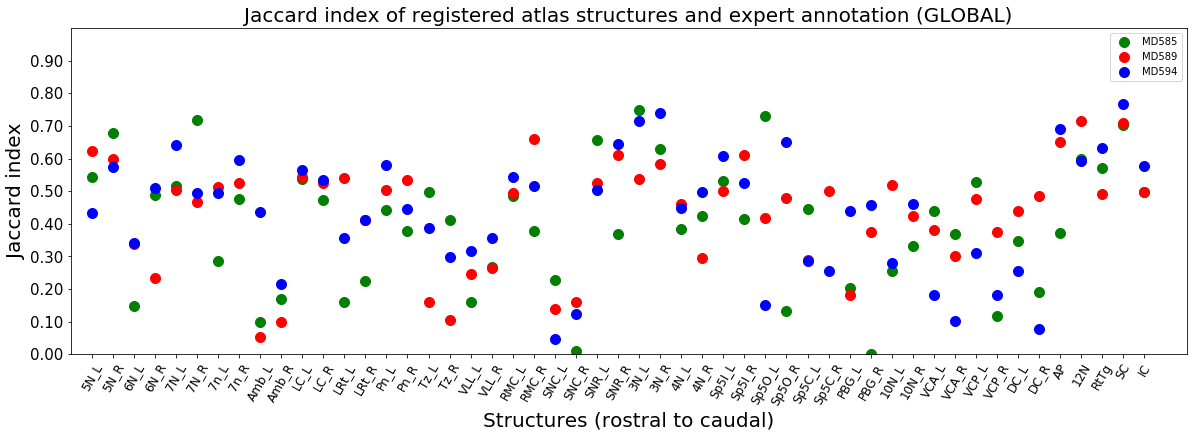

In [83]:
plot_by_stack_by_structure(global_jaccard_all_stacks_all_structures, 
                           structures=all_known_structures_sided,
                           yticks=np.arange(0, 1., 0.1), 
                           yticklabel_fmt='%.2f',
                           ylabel='Jaccard index',
                           xlabel='Structures (rostral to caudal)',
                          title='Jaccard index of registered atlas structures and expert annotation (GLOBAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

## Centroid error

In [44]:
diff_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_um'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in global_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [45]:
print 'Median centroid error:', np.median([y for x in diff_all_stacks_all_structures.values() for y in x.values()]), 'um'

Median centroid error: 92.3507757411921 um


In [46]:
# Only show motor nuclei (for use together with CHAT figure).

diff_all_stacks_all_structures_motor_nuclei_only = {stack: {s: data_all_structures[s] 
                                                            for s in ['5N_L', '5N_R', '6N_L', '6N_R',
                                      '7N_L', '7N_R', 'Amb_L', 'Amb_R',
                                      '10N_L', '10N_R', '12N']} 
 for stack, data_all_structures in diff_all_stacks_all_structures.iteritems()}

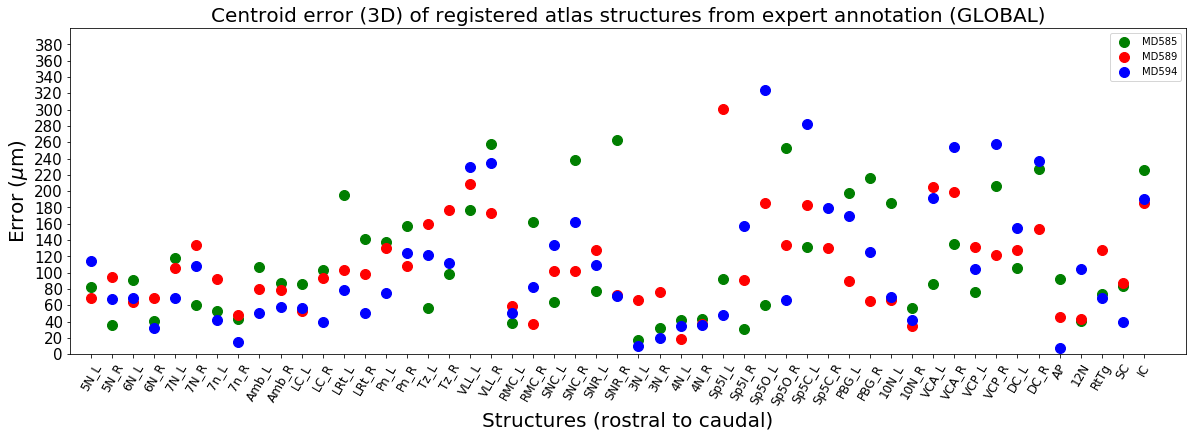

In [47]:
plot_by_stack_by_structure(diff_all_stacks_all_structures, 
                           structures=all_known_structures_sided,
                           yticks=np.arange(0, 400, 20), 
                           yticklabel_fmt='%d',
                           ylabel='Error ($\mu$m)',
                           xlabel='Structures (rostral to caudal)',
                          title='Centroid error (3D) of registered atlas structures from expert annotation (GLOBAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

## Centroid error normalized

In [55]:
diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_percentage'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in global_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

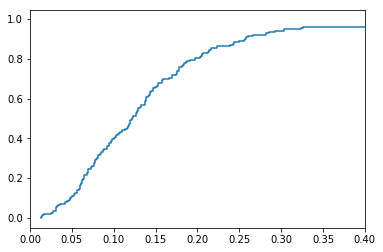

In [56]:
sorted_data = np.sort(([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()]))
plt.step(sorted_data, np.arange(sorted_data.size)/float(len(sorted_data)));  # From 0 to the number of data points-1
plt.xlim([0, 0.4]);
# plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

In [57]:
print 'Median centroid error (normalized by structure size):', np.median([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()]), 'um'

Median centroid error (normalized by structure size): 0.12223631188760731 um


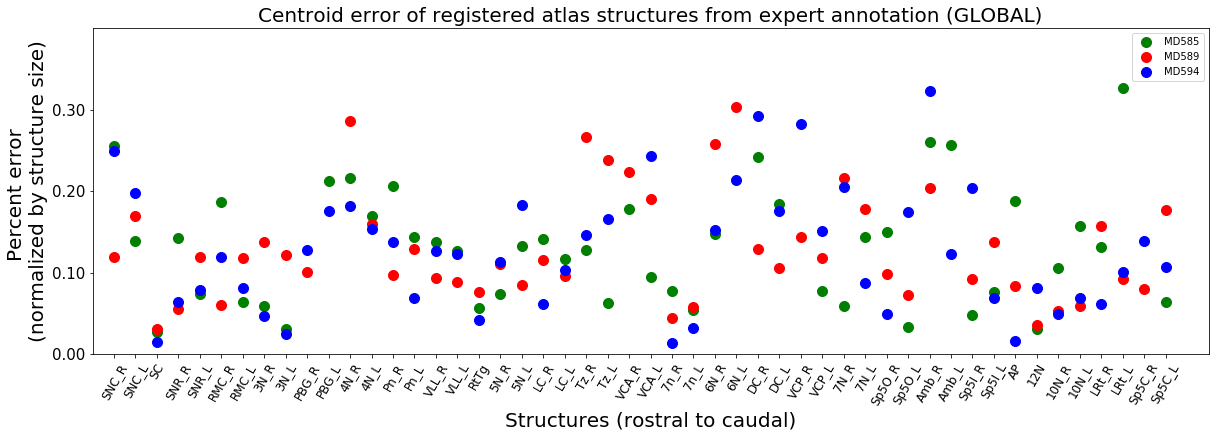

In [58]:
plot_by_stack_by_structure(diffperc_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0, 0.35, 0.1), 
                                                      xlabel='Structures (rostral to caudal)',
                           ylabel='Percent error \n(normalized by structure size)',
                          title='Centroid error of registered atlas structures from expert annotation (GLOBAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

# Local registration metrics

In [59]:
local_registration_metrics_allStacks_allStructures_allLevels = \
load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/local_registration_metrics_allStacks_allStructures_allLevels.json')

## Jaccard

In [60]:
jaccard_all_stacks_all_structures = \
{stack: {s: np.nanmax([v['jac'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [61]:
print 'Median Jaccard index between aligned atlas and expert annotation:', np.median([y for x in jaccard_all_stacks_all_structures.values() for y in x.values()])

Median Jaccard index between aligned atlas and expert annotation: 0.6062672499056663


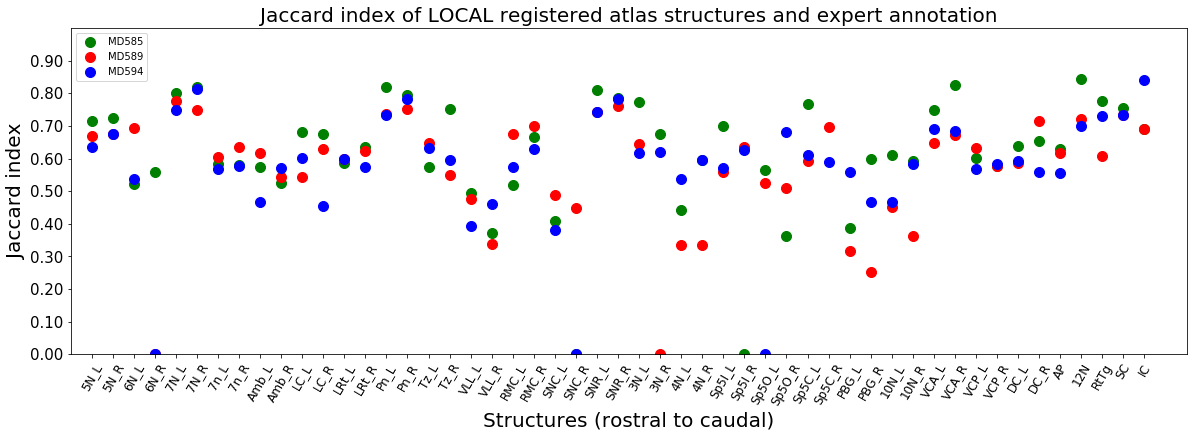

In [62]:
plot_by_stack_by_structure(jaccard_all_stacks_all_structures, 
                           structures=all_known_structures_sided,
                           yticks=np.arange(0, 1., 0.1), 
                           yticklabel_fmt='%.2f',
                           ylabel='Jaccard index',
                           xlabel='Structures (rostral to caudal)',
                          title='Jaccard index of LOCAL registered atlas structures and expert annotation',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

## Centroid error

In [63]:
diff_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_um'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: All-NaN axis encountered
  


In [64]:
print 'Median centroid error:', np.nanmedian([y for x in diff_all_stacks_all_structures.values() for y in x.values()]), 'um'

Median centroid error: 42.46399223685412 um


In [65]:
# Only show motor nuclei (for use together with CHAT figure).

diff_all_stacks_all_structures_motor_nuclei_only = {stack: {s: data_all_structures[s] 
                                                            for s in ['5N_L', '5N_R', '6N_L', '6N_R',
                                      '7N_L', '7N_R', 'Amb_L', 'Amb_R',
                                      '10N_L', '10N_R', '12N']} 
 for stack, data_all_structures in diff_all_stacks_all_structures.iteritems()}

In [66]:
pd.DataFrame(diff_all_stacks_all_structures_motor_nuclei_only).to_csv(\
'/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/centroid_difference_3d_wrt_human_annotation_um_motor_nuclei_only.csv')

NameError: name 'pd' is not defined

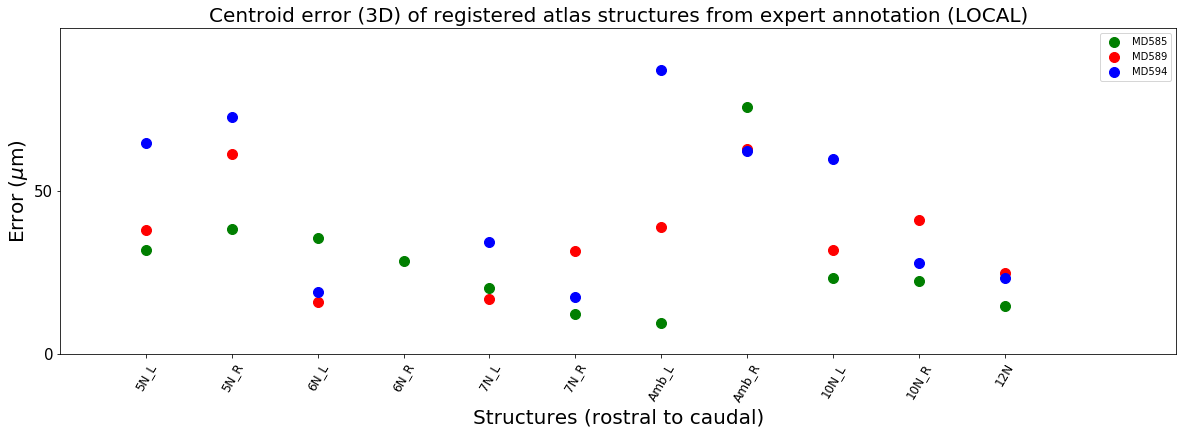

In [67]:
plot_by_stack_by_structure(diff_all_stacks_all_structures, 
                           structures=['5N_L', '5N_R', '6N_L', '6N_R',
                                      '7N_L', '7N_R', 'Amb_L', 'Amb_R',
                                      '10N_L', '10N_R', '12N'],
                           yticks=np.arange(0, 100, 50), 
                           yticklabel_fmt='%d',
                           ylabel='Error ($\mu$m)',
                           xlabel='Structures (rostral to caudal)',
                          title='Centroid error (3D) of registered atlas structures from expert annotation (LOCAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

In [68]:
# Show all structures

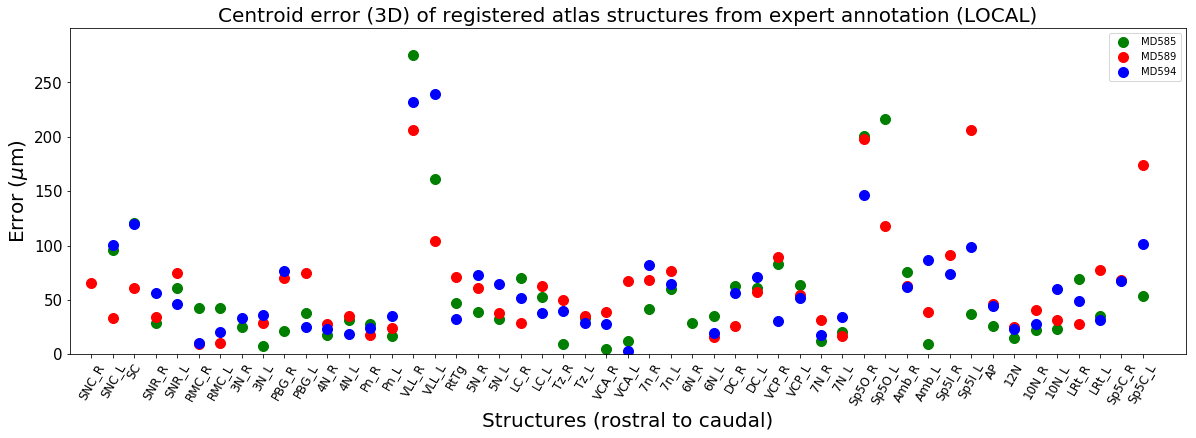

In [69]:
plot_by_stack_by_structure(diff_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0, 300, 50), 
                           yticklabel_fmt='%d',
                           ylabel='Error ($\mu$m)',
                           xlabel='Structures (rostral to caudal)',
                          title='Centroid error (3D) of registered atlas structures from expert annotation (LOCAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

In [70]:
pd.DataFrame(diff_all_stacks_all_structures).to_csv(\
'/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/centroid_difference_3d_wrt_human_annotation_um.csv')

NameError: name 'pd' is not defined

## Centroid error normalized by structure size

In [71]:
diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_percentage'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN axis encountered
  """Entry point for launching an IPython kernel.


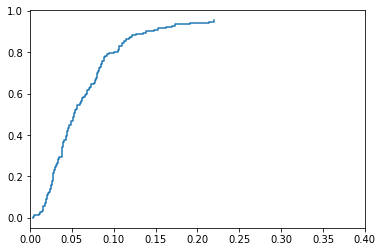

In [72]:
sorted_data = np.sort(([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()]))
plt.step(sorted_data, np.arange(sorted_data.size)/float(len(sorted_data)));  # From 0 to the number of data points-1
plt.xlim([0, 0.4]);
# plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

In [73]:
print 'Median centroid error (normalized by structure size):', np.nanmedian([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()])

Median centroid error (normalized by structure size): 0.05117729596793107


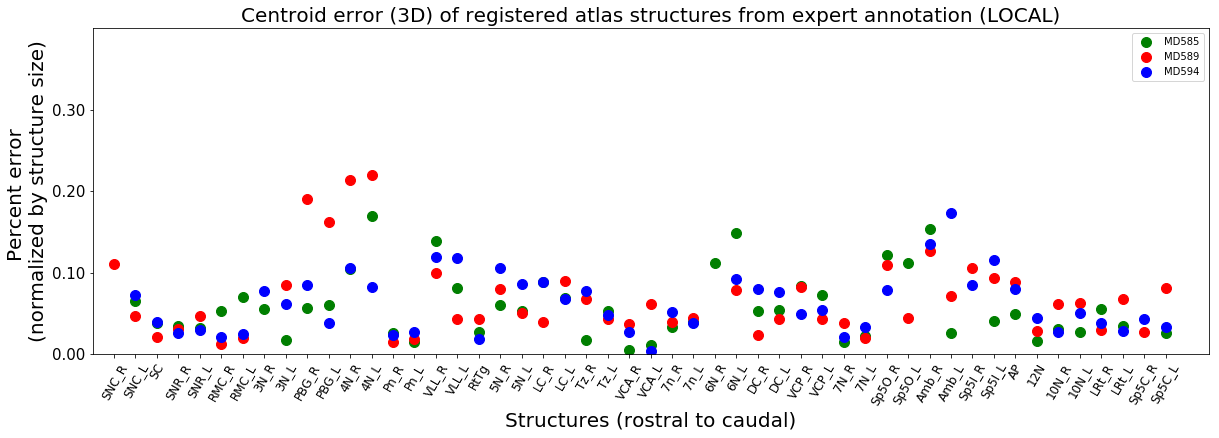

In [74]:
plot_by_stack_by_structure(diffperc_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0, 0.35, 0.1), 
                                                      xlabel='Structures (rostral to caudal)',
                           ylabel='Percent error \n(normalized by structure size)',
                          title='Centroid error (3D) of registered atlas structures from expert annotation (LOCAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

## Measure voxel value difference 

In [75]:
meandiff_all_stacks_all_structures = \
{stack: {s: x_all_levels[0.5]['mean_diff']
         for s, x_all_levels in x_all_s_all_levels.iteritems()}
 for stack, x_all_s_all_levels in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [76]:
print 'Mean voxel value difference:', np.median([y for x in meandiff_all_stacks_all_structures.values() for y in x.values()])

Mean voxel value difference: 0.26968881838522063


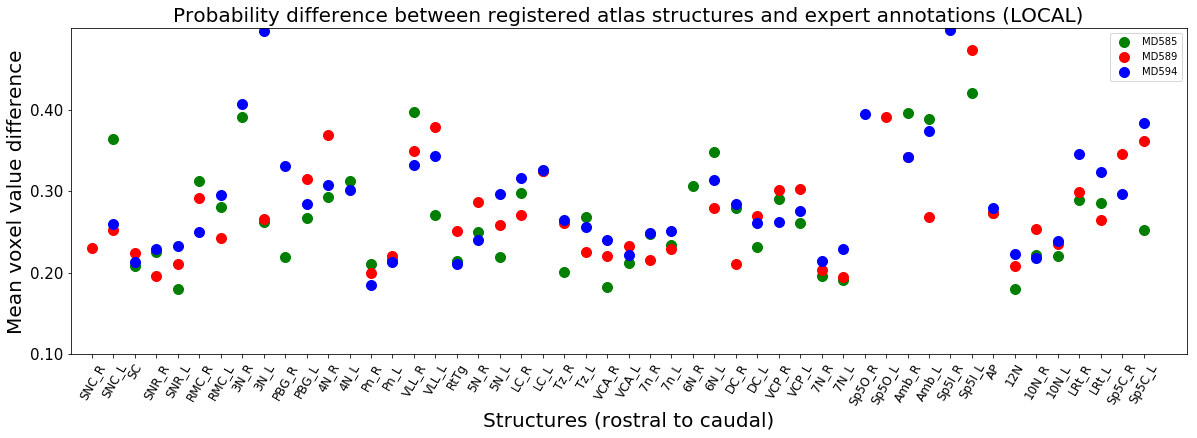

In [80]:
plot_by_stack_by_structure(meandiff_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0.1, 0.5, 0.1), 
                            xlabel='Structures (rostral to caudal)',
                           ylabel='Mean voxel value difference',
                          title='Probability difference between registered atlas structures and expert annotations (LOCAL)',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});